In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch import Tensor
import torch.nn.functional as F
from torch.optim.lr_scheduler import MultiStepLR
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import accuracy_score
from torch.optim import lr_scheduler

In [2]:
# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

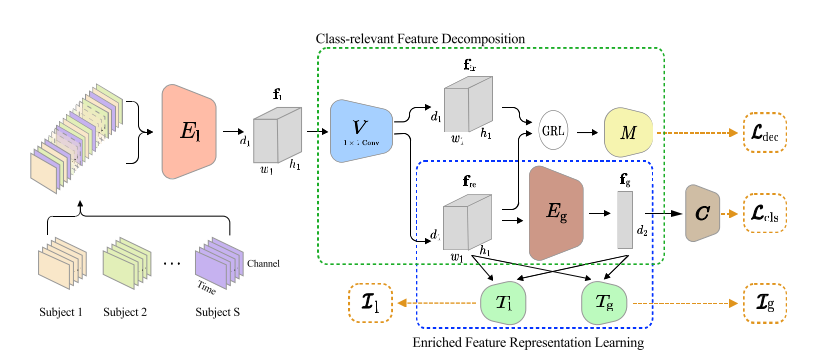

# Read Data

In [4]:
train_set = pd.read_csv("data/64_640data/train_set.csv",header=None).to_numpy()
train_label = pd.read_csv("data/64_640data/train_label.csv",header=None).to_numpy()
test_set = pd.read_csv("data/64_640data/test_set.csv",header=None).to_numpy()
test_label = pd.read_csv("data/64_640data/test_label.csv",header=None).to_numpy()

In [5]:
#delet first row data
train_set = train_set[1:]
train_label = train_label[1:]
test_set = test_set[1:]
test_label = test_label[1:]
print(train_set.shape, train_label.shape, test_set.shape, test_label.shape)

(14392, 4096) (14392, 1) (3598, 4096) (3598, 1)


In [6]:
train_set = train_set.reshape((-1,1,64,640))
test_set = test_set.reshape((-1,1,64,640))
train_label = train_label.reshape(-1)
test_label = test_label.reshape(-1)

In [7]:
print(train_set.shape, train_label.shape, test_set.shape, test_label.shape)

(14392, 1, 64, 64) (14392,) (3598, 1, 64, 64) (3598,)


In [8]:
train_set_tensor = Tensor(train_set) 
train_label_tensor = Tensor(train_label).type(torch.LongTensor)

train_dataset = TensorDataset(train_set_tensor,train_label_tensor) 
train_loader = DataLoader(train_dataset, batch_size=64) 

test_set_tensor = Tensor(test_set) 
test_label_tensor = Tensor(test_label).type(torch.LongTensor)

test_dataset = TensorDataset(test_set_tensor,test_label_tensor) 
test_loader = DataLoader(test_dataset, batch_size=64) 

# construct model

In [11]:
F1 = 8
D = 2
F2 = 16
drop_prob = 0.5

In [12]:
class Conv2dWithConstraint(nn.Conv2d):
    def __init__(self, *args, max_norm=1, **kwargs):
        self.max_norm = max_norm
        super(Conv2dWithConstraint, self).__init__(*args, **kwargs)
    def forward(self, x):
        self.weight.data = torch.renorm(self.weight.data, p=2, dim=0, maxnorm=self.max_norm)
        return super(Conv2dWithConstraint, self).forward(x)

In [13]:
class LocalEncoder_EEGNet(nn.Module):
    def __init__(self, fs, num_ch, num_time):
        super(LocalEncoder_EEGNet, self).__init__()
        self.c1 = nn.Conv2d(in_channels=1, out_channels=F1, kernel_size=(1, int(fs / 2)), stride=1, bias=False,
                            padding=(0, (int(fs / 2) // 2) - 1))  # []
        self.b1 = nn.BatchNorm2d(F1)
        self.c2 = Conv2dWithConstraint(in_channels=F1, out_channels=F1 * D, kernel_size=(num_ch, 1), stride=1,
                                       bias=False, groups=F1, padding=(0, 0), max_norm=1)
        self.b2 = nn.BatchNorm2d(F1 * D)
        self.p2 = nn.AvgPool2d(kernel_size=(1, 4), stride=(1, 4))
        self.d2 = nn.Dropout(drop_prob)

    def forward(self, input):
        h1 = self.b1(self.c1(input))
        h2 = self.d2(self.p2(F.elu(self.b2(self.c2(h1)))))
        return h2

In [ ]:
# local_enc = LocalEncoder_EEGNet(fs=160, num_ch=64, num_time = 640)
# a = torch.randn((10,1,64,64))
# b = local_enc(a)
# b.shape

In [ ]:
# testlocal_enc = LocalEncoder_EEGNet(fs=512, num_ch=64, num_time = 1024)
# testa = torch.randn((10,1,64,1024))
# testb = local_enc(testa)
# testb.shape

In [14]:
class Decomposer(nn.Module):
    def __init__(self, nfeat):
        super(Decomposer, self).__init__()
        self.nfeat = nfeat
        self.embed_layer = nn.Sequential(nn.Conv2d(nfeat, nfeat*2, kernel_size=1, bias=False),
                                         nn.BatchNorm2d(nfeat*2), nn.ELU(), nn.Dropout())

    def forward(self, x):
        embedded = self.embed_layer(x)
        #print(embedded.shape)
        rele, irre = torch.split(embedded, [int(self.nfeat), int(self.nfeat)], dim=1)

        return rele, irre

In [ ]:
# decomposer = Decomposer(16)
# c, d = decomposer(b)
# print(c.shape,d.shape)

In [15]:
class GlobalEncoder_EEGNet(nn.Module):
    def __init__(self, num_ch, num_time, nfeatl):
        super(GlobalEncoder_EEGNet, self).__init__()
        self.c3 = nn.Conv2d(in_channels=nfeatl, out_channels=F1 * D, kernel_size=(1, 16), stride=1, bias=False,
                            groups=(nfeatl), padding=(0, 16 // 2))
        self.b3 = nn.BatchNorm2d(F1 * D)
        self.p3 = nn.AvgPool2d(kernel_size=(1, 8), stride=(1, 8))
        self.d3 = nn.Dropout(drop_prob)

    def forward(self, x):
        h3 = self.d3(self.p3(F.elu(self.b3(self.c3(x)))))
        h3_ = torch.flatten(h3, start_dim=1)
        return h3_


In [16]:
# global_enc = GlobalEncoder_EEGNet()
# e = global_enc(c)
# e.shape

In [17]:
class Classifier(nn.Module):
    def __init__(self, nfeatr):
        super(Classifier, self).__init__()
        self.dense1 = nn.Linear(nfeatr, 4)

    def forward(self, latent):
        out = self.dense1(latent)

        return out

In [ ]:
# classifier = Classifier()
# f = classifier(e)
# f.shape

In [18]:
class GradReverse(torch.autograd.Function):
    """
    Extension of grad reverse layer
    """
    @staticmethod
    def forward(ctx, x, constant):
        ctx.constant = constant
        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        grad_output = grad_output.neg() * ctx.constant
        return grad_output, None

    def grad_reverse(x, constant):
        return GradReverse.apply(x, constant)

In [19]:
class MINE(nn.Module):
    def __init__(self, nfeatr, nfeati):
        super(MINE, self).__init__()
        self.fc1_x = nn.Linear(nfeatr, int(nfeatr/16))
        self.bn1_x = nn.BatchNorm1d(int(nfeatr/16))
        self.fc1_y = nn.Linear(nfeati, int(nfeati/16))
        self.bn1_y = nn.BatchNorm1d(int(nfeati/16))

        self.fc2 = nn.Linear(int(nfeati/16) + int(nfeatr/16),int(nfeati/16) + int(nfeatr/16))
        self.bn2 = nn.BatchNorm1d(int(nfeati/16) + int(nfeatr/16))

        self.fc3 = nn.Linear(int(nfeati/16) + int(nfeatr/16), 1)

    def forward(self, x, y, lambd=1):
        # GRL
        x = GradReverse.grad_reverse(x, lambd)
        y = GradReverse.grad_reverse(y, lambd)
        #print(x.shape,y.shape)
        #x = x.reshape(10,-1)
        #y = y.reshape(10,-1)
        x = F.dropout(self.bn1_x(self.fc1_x(x)))
        y = F.dropout(self.bn1_y(self.fc1_y(y)))

        h = F.elu(torch.cat((x,y), dim=-1))
        h = F.elu(self.bn2(self.fc2(h)))
        h = self.fc3(h)

        return h

In [ ]:
# mine = MINE(nfeatr=int(16 * 15), nfeati=int(16 * 15))
# g = mine(c,d)
# g.shape

In [20]:
class Global_disc_EEGNet(nn.Module):
    def __init__(self, nfeatl, nfeatg, num_ch):
        super(Global_disc_EEGNet, self).__init__()
        self.local_conv = nn.Sequential(
            nn.Conv2d(in_channels=nfeatl, out_channels=F1 * D, kernel_size=(1, 16), stride=1, bias=False,
                      groups=(nfeatl), padding=(0, 16 // 2)),
            nn.BatchNorm2d(F1 * D),
            nn.AvgPool2d(kernel_size=(1, 8), stride=(1, 8)),
            nn.Dropout(drop_prob)
        )
        self.dense1 = nn.Linear(int(nfeatg*2), 1)
        self.drop1 = nn.Dropout()

    def forward(self, localf, globalf):
        localff = self.local_conv(localf)
        localff = localff.view(localf.shape[0], -1)

        concat = torch.cat((localff, globalf), dim=-1)
        #print(concat.shape)
        out = self.drop1(self.dense1(concat))

        return out

In [21]:
# global_disc = Global_disc_EEGNet(nfeatl=16, nfeatg=32, num_ch=64)
# h = global_disc(c,e)
# h.shape

In [33]:
class Local_disc_EEGNet(nn.Module):
    def __init__(self, nfeatl, nfeatg, nfeatl2, num_ch):
        super(Local_disc_EEGNet, self).__init__()
        self.num_ch = num_ch
        self.nfeatl = nfeatl
        self.nfeatl2 = nfeatl2
        self.nfeatg = nfeatg

        self.drop1 = nn.Dropout()
        self.conv = nn.Conv2d(int(self.nfeatg+self.nfeatl), 1, kernel_size=1)

    def forward(self, localf, globalf):
        #print(localf.shape,globalf.shape)
        # Concat-and-convolve architecture
        globalff = globalf.unsqueeze(2).unsqueeze(3)
        #print(globalff.shape)
        globalff = globalff.repeat(1,1,1,self.nfeatl2)
        concat = torch.cat((localf, globalff), dim=1)
        out = self.drop1(self.conv(concat))
        out = out.view(out.shape[0],-1)

        return out

In [ ]:
# local_disc = Local_disc_EEGNet(nfeatl=16, nfeatg=32, nfeatl2=15, num_ch=64)
# i = local_disc(c,e)
# i.shape

# function and model define

In [27]:
""" Hyperparameter """
lr = 1e-3
n_class = 4
drop = 0.5
total_epoch = 100
w_decay = 0.05
alpha = 0.5
beta = 0.3
gamma = 0.5
bs = 40
fs = 160
num_ch = 64
num_time = 64
nfeatl = 16
nfeatg = 32
nfeatl2 = 15

In [34]:
local_enc = LocalEncoder_EEGNet(fs=fs, num_ch=num_ch, num_time=num_time).to(device)
global_enc = GlobalEncoder_EEGNet(num_ch=num_ch, num_time=num_time, nfeatl=nfeatl).to(device)
local_disc = Local_disc_EEGNet(nfeatl=nfeatl, nfeatg=nfeatg, nfeatl2=nfeatl2, num_ch=num_ch).to(device)
global_disc = Global_disc_EEGNet(nfeatl=nfeatl, nfeatg=nfeatg, num_ch=num_ch).to(device)
decomposer = Decomposer(nfeatl).to(device)
mine = MINE(nfeatr=int(nfeatl * nfeatl2), nfeati=int(nfeatl * nfeatl2)).to(device)
classifier = Classifier(nfeatg).to(device)

In [35]:
cls_criterion = nn.CrossEntropyLoss().cuda()
parameters = list(local_enc.parameters()) + list(global_enc.parameters()) + list(local_disc.parameters()) + list(
    global_disc.parameters()) + list(classifier.parameters()) + list(mine.parameters()) + list(decomposer.parameters())
opt = torch.optim.RAdam(parameters, lr=lr, weight_decay=w_decay)
scheduler = lr_scheduler.ExponentialLR(opt, gamma=0.99)

In [36]:
def estimate_JSD_MI(joint, marginal, mean=False):
    joint = (torch.log(torch.tensor(2.0)) - F.softplus(-joint))
    marginal = (F.softplus(-marginal)+marginal - torch.log(torch.tensor(2.0)))

    out = joint - marginal
    if mean:
        out = out.mean()
    return out

In [39]:
# Train
total_step = len(train_loader)
for ep in range(total_epoch):
    global_enc.train(), local_enc.train(), local_disc.train(), global_disc.train(), mine.train(), decomposer.train(), classifier.train()
    correct=0
    total=0
    running_loss = 0
    for bidx, (batchx, batchy) in enumerate(train_loader):
        batchx = batchx.to(device)
        batchy = batchy.to(device)
        # Reset gradient
        opt.zero_grad()

        # Feed input to enocders and then obtain local feature (relevant, irrelevant) and global feature
        localf = local_enc(batchx) #[batch, d1, 1, t1]
        rele, irre = decomposer(localf) #[batch, d1, 1, t1], #[batch, depth, 1, t1]
        globalf = global_enc(rele) #[batch, d2]

        # Feed the relevant feature to classifier
        logits = classifier(globalf) #[batch, 4]
        loss_class = cls_criterion(logits, batchy)

        # To ensure good decomposition, estimate MI between relevant feature and irrelevant feature
        rele_ = torch.reshape(rele, (rele.shape[0], -1)) #[batch, d1*t1]
        irre_ = torch.reshape(irre, (irre.shape[0], -1)) #[batch, d1*t1]
        ishuffle = torch.index_select(irre_, 0, torch.randperm(irre_.shape[0]).to(device))
        djoint = mine(rele_, irre_) #[batch, 1]
        dmarginal = mine(rele_, ishuffle) #[batch, 1]
        loss_decomposition = - estimate_JSD_MI(djoint, dmarginal, True)

        # Estimate global MI
        gshuffle = torch.index_select(globalf, 0, torch.randperm(globalf.shape[0]).to(device)) #[batch, d2]
        gjoint = global_disc(rele, globalf) #[batch, 1]
        gmarginal = global_disc(rele, gshuffle) #[batch, 1]
        loss_global_mi = estimate_JSD_MI(gjoint, gmarginal, True)

        # Estimate local MI
        ljoint = local_disc(rele, globalf)
        lmarginal = local_disc(rele, gshuffle)
        temp = estimate_JSD_MI(ljoint, lmarginal, False)
        loss_local_mi = temp.mean()

        loss_dim = - (loss_global_mi + loss_local_mi)

        # All objective function
        loss_all = alpha * loss_class + beta * loss_decomposition + gamma * loss_dim

        loss_all.backward()
        opt.step()
        opt.zero_grad()
        
        _, predicted = logits.max(1)
        total += batchy.size(0)
        correct += predicted.eq(batchy).sum().item()
        running_loss += loss_all.item()
        accu=100.*correct/total
        train_loss = running_loss/(bidx+1)
        print ('Epoch [{}/{}], Step [{}/{}], Training Accuracy: {:.4f}%, Training Loss: {:.4f}%'.format(ep+1, total_epoch, bidx+1, total_step, accu, train_loss))

    scheduler.step()  # learning rate decay



Epoch [1/100], Step [1/225], Training Accuracy: 25.0000%, Training Loss: 0.8518%
Epoch [1/100], Step [2/225], Training Accuracy: 32.8125%, Training Loss: 0.7992%
Epoch [1/100], Step [3/225], Training Accuracy: 32.8125%, Training Loss: 0.7942%
Epoch [1/100], Step [4/225], Training Accuracy: 29.2969%, Training Loss: 0.7939%
Epoch [1/100], Step [5/225], Training Accuracy: 29.3750%, Training Loss: 0.7849%
Epoch [1/100], Step [6/225], Training Accuracy: 28.6458%, Training Loss: 0.7862%
Epoch [1/100], Step [7/225], Training Accuracy: 29.0179%, Training Loss: 0.7929%
Epoch [1/100], Step [8/225], Training Accuracy: 28.5156%, Training Loss: 0.7928%
Epoch [1/100], Step [9/225], Training Accuracy: 27.0833%, Training Loss: 0.7901%
Epoch [1/100], Step [10/225], Training Accuracy: 26.7188%, Training Loss: 0.7938%
Epoch [1/100], Step [11/225], Training Accuracy: 26.4205%, Training Loss: 0.7921%
Epoch [1/100], Step [12/225], Training Accuracy: 26.3021%, Training Loss: 0.7994%
Epoch [1/100], Step [13/2

Epoch [1/100], Step [114/225], Training Accuracy: 25.4249%, Training Loss: 0.7716%
Epoch [1/100], Step [115/225], Training Accuracy: 25.4755%, Training Loss: 0.7714%
Epoch [1/100], Step [116/225], Training Accuracy: 25.5119%, Training Loss: 0.7711%
Epoch [1/100], Step [117/225], Training Accuracy: 25.5075%, Training Loss: 0.7710%
Epoch [1/100], Step [118/225], Training Accuracy: 25.5297%, Training Loss: 0.7709%
Epoch [1/100], Step [119/225], Training Accuracy: 25.5383%, Training Loss: 0.7708%
Epoch [1/100], Step [120/225], Training Accuracy: 25.4948%, Training Loss: 0.7709%
Epoch [1/100], Step [121/225], Training Accuracy: 25.5036%, Training Loss: 0.7707%
Epoch [1/100], Step [122/225], Training Accuracy: 25.4611%, Training Loss: 0.7706%
Epoch [1/100], Step [123/225], Training Accuracy: 25.3557%, Training Loss: 0.7706%
Epoch [1/100], Step [124/225], Training Accuracy: 25.3528%, Training Loss: 0.7704%
Epoch [1/100], Step [125/225], Training Accuracy: 25.4750%, Training Loss: 0.7702%
Epoc

Epoch [1/100], Step [216/225], Training Accuracy: 26.0272%, Training Loss: 0.7561%
Epoch [1/100], Step [217/225], Training Accuracy: 26.0369%, Training Loss: 0.7559%
Epoch [1/100], Step [218/225], Training Accuracy: 26.0034%, Training Loss: 0.7559%
Epoch [1/100], Step [219/225], Training Accuracy: 26.0131%, Training Loss: 0.7557%
Epoch [1/100], Step [220/225], Training Accuracy: 26.0227%, Training Loss: 0.7556%
Epoch [1/100], Step [221/225], Training Accuracy: 26.0040%, Training Loss: 0.7556%
Epoch [1/100], Step [222/225], Training Accuracy: 26.0206%, Training Loss: 0.7555%
Epoch [1/100], Step [223/225], Training Accuracy: 25.9879%, Training Loss: 0.7554%
Epoch [1/100], Step [224/225], Training Accuracy: 25.9835%, Training Loss: 0.7553%
Epoch [1/100], Step [225/225], Training Accuracy: 25.9589%, Training Loss: 0.7551%
Epoch [2/100], Step [1/225], Training Accuracy: 31.2500%, Training Loss: 0.6857%
Epoch [2/100], Step [2/225], Training Accuracy: 28.1250%, Training Loss: 0.7015%
Epoch [2

Epoch [2/100], Step [97/225], Training Accuracy: 26.3209%, Training Loss: 0.7149%
Epoch [2/100], Step [98/225], Training Accuracy: 26.2436%, Training Loss: 0.7148%
Epoch [2/100], Step [99/225], Training Accuracy: 26.3258%, Training Loss: 0.7145%
Epoch [2/100], Step [100/225], Training Accuracy: 26.2500%, Training Loss: 0.7146%
Epoch [2/100], Step [101/225], Training Accuracy: 26.3459%, Training Loss: 0.7145%
Epoch [2/100], Step [102/225], Training Accuracy: 26.2868%, Training Loss: 0.7146%
Epoch [2/100], Step [103/225], Training Accuracy: 26.3653%, Training Loss: 0.7144%
Epoch [2/100], Step [104/225], Training Accuracy: 26.3672%, Training Loss: 0.7144%
Epoch [2/100], Step [105/225], Training Accuracy: 26.3393%, Training Loss: 0.7144%
Epoch [2/100], Step [106/225], Training Accuracy: 26.2972%, Training Loss: 0.7146%
Epoch [2/100], Step [107/225], Training Accuracy: 26.2704%, Training Loss: 0.7144%
Epoch [2/100], Step [108/225], Training Accuracy: 26.2731%, Training Loss: 0.7145%
Epoch [

Epoch [2/100], Step [202/225], Training Accuracy: 26.4078%, Training Loss: 0.7087%
Epoch [2/100], Step [203/225], Training Accuracy: 26.4317%, Training Loss: 0.7087%
Epoch [2/100], Step [204/225], Training Accuracy: 26.4782%, Training Loss: 0.7085%
Epoch [2/100], Step [205/225], Training Accuracy: 26.5091%, Training Loss: 0.7085%
Epoch [2/100], Step [206/225], Training Accuracy: 26.5397%, Training Loss: 0.7084%
Epoch [2/100], Step [207/225], Training Accuracy: 26.5172%, Training Loss: 0.7084%
Epoch [2/100], Step [208/225], Training Accuracy: 26.4949%, Training Loss: 0.7084%
Epoch [2/100], Step [209/225], Training Accuracy: 26.5027%, Training Loss: 0.7083%
Epoch [2/100], Step [210/225], Training Accuracy: 26.5253%, Training Loss: 0.7082%
Epoch [2/100], Step [211/225], Training Accuracy: 26.5255%, Training Loss: 0.7082%
Epoch [2/100], Step [212/225], Training Accuracy: 26.5330%, Training Loss: 0.7081%
Epoch [2/100], Step [213/225], Training Accuracy: 26.5625%, Training Loss: 0.7081%
Epoc

Epoch [3/100], Step [87/225], Training Accuracy: 27.8376%, Training Loss: 0.6933%
Epoch [3/100], Step [88/225], Training Accuracy: 27.8232%, Training Loss: 0.6934%
Epoch [3/100], Step [89/225], Training Accuracy: 27.7563%, Training Loss: 0.6936%
Epoch [3/100], Step [90/225], Training Accuracy: 27.8993%, Training Loss: 0.6934%
Epoch [3/100], Step [91/225], Training Accuracy: 27.9533%, Training Loss: 0.6933%
Epoch [3/100], Step [92/225], Training Accuracy: 27.9552%, Training Loss: 0.6933%
Epoch [3/100], Step [93/225], Training Accuracy: 28.1250%, Training Loss: 0.6933%
Epoch [3/100], Step [94/225], Training Accuracy: 28.1250%, Training Loss: 0.6933%
Epoch [3/100], Step [95/225], Training Accuracy: 28.0921%, Training Loss: 0.6935%
Epoch [3/100], Step [96/225], Training Accuracy: 28.1250%, Training Loss: 0.6935%
Epoch [3/100], Step [97/225], Training Accuracy: 28.1894%, Training Loss: 0.6936%
Epoch [3/100], Step [98/225], Training Accuracy: 28.2047%, Training Loss: 0.6934%
Epoch [3/100], S

Epoch [3/100], Step [193/225], Training Accuracy: 28.3760%, Training Loss: 0.6917%
Epoch [3/100], Step [194/225], Training Accuracy: 28.3666%, Training Loss: 0.6917%
Epoch [3/100], Step [195/225], Training Accuracy: 28.3494%, Training Loss: 0.6917%
Epoch [3/100], Step [196/225], Training Accuracy: 28.3323%, Training Loss: 0.6917%
Epoch [3/100], Step [197/225], Training Accuracy: 28.3471%, Training Loss: 0.6916%
Epoch [3/100], Step [198/225], Training Accuracy: 28.3854%, Training Loss: 0.6917%
Epoch [3/100], Step [199/225], Training Accuracy: 28.3998%, Training Loss: 0.6916%
Epoch [3/100], Step [200/225], Training Accuracy: 28.3438%, Training Loss: 0.6916%
Epoch [3/100], Step [201/225], Training Accuracy: 28.3738%, Training Loss: 0.6916%
Epoch [3/100], Step [202/225], Training Accuracy: 28.3493%, Training Loss: 0.6916%
Epoch [3/100], Step [203/225], Training Accuracy: 28.3328%, Training Loss: 0.6916%
Epoch [3/100], Step [204/225], Training Accuracy: 28.3395%, Training Loss: 0.6915%
Epoc

Epoch [4/100], Step [74/225], Training Accuracy: 31.9890%, Training Loss: 0.6808%
Epoch [4/100], Step [75/225], Training Accuracy: 31.8958%, Training Loss: 0.6806%
Epoch [4/100], Step [76/225], Training Accuracy: 31.8257%, Training Loss: 0.6806%
Epoch [4/100], Step [77/225], Training Accuracy: 31.7573%, Training Loss: 0.6808%
Epoch [4/100], Step [78/225], Training Accuracy: 31.8109%, Training Loss: 0.6806%
Epoch [4/100], Step [79/225], Training Accuracy: 31.6851%, Training Loss: 0.6805%
Epoch [4/100], Step [80/225], Training Accuracy: 31.7773%, Training Loss: 0.6804%
Epoch [4/100], Step [81/225], Training Accuracy: 31.6358%, Training Loss: 0.6805%
Epoch [4/100], Step [82/225], Training Accuracy: 31.6692%, Training Loss: 0.6803%
Epoch [4/100], Step [83/225], Training Accuracy: 31.6830%, Training Loss: 0.6805%
Epoch [4/100], Step [84/225], Training Accuracy: 31.7336%, Training Loss: 0.6803%
Epoch [4/100], Step [85/225], Training Accuracy: 31.7463%, Training Loss: 0.6805%
Epoch [4/100], S

Epoch [4/100], Step [182/225], Training Accuracy: 31.4646%, Training Loss: 0.6795%
Epoch [4/100], Step [183/225], Training Accuracy: 31.4464%, Training Loss: 0.6795%
Epoch [4/100], Step [184/225], Training Accuracy: 31.4283%, Training Loss: 0.6795%
Epoch [4/100], Step [185/225], Training Accuracy: 31.3682%, Training Loss: 0.6795%
Epoch [4/100], Step [186/225], Training Accuracy: 31.3424%, Training Loss: 0.6794%
Epoch [4/100], Step [187/225], Training Accuracy: 31.3085%, Training Loss: 0.6794%
Epoch [4/100], Step [188/225], Training Accuracy: 31.3664%, Training Loss: 0.6793%
Epoch [4/100], Step [189/225], Training Accuracy: 31.3823%, Training Loss: 0.6794%
Epoch [4/100], Step [190/225], Training Accuracy: 31.3405%, Training Loss: 0.6795%
Epoch [4/100], Step [191/225], Training Accuracy: 31.3482%, Training Loss: 0.6794%
Epoch [4/100], Step [192/225], Training Accuracy: 31.3151%, Training Loss: 0.6794%
Epoch [4/100], Step [193/225], Training Accuracy: 31.3148%, Training Loss: 0.6793%
Epoc

Epoch [5/100], Step [61/225], Training Accuracy: 32.8893%, Training Loss: 0.6720%
Epoch [5/100], Step [62/225], Training Accuracy: 32.8377%, Training Loss: 0.6719%
Epoch [5/100], Step [63/225], Training Accuracy: 32.9365%, Training Loss: 0.6719%
Epoch [5/100], Step [64/225], Training Accuracy: 33.0566%, Training Loss: 0.6719%
Epoch [5/100], Step [65/225], Training Accuracy: 32.9808%, Training Loss: 0.6719%
Epoch [5/100], Step [66/225], Training Accuracy: 32.9545%, Training Loss: 0.6716%
Epoch [5/100], Step [67/225], Training Accuracy: 32.9757%, Training Loss: 0.6714%
Epoch [5/100], Step [68/225], Training Accuracy: 32.9044%, Training Loss: 0.6713%
Epoch [5/100], Step [69/225], Training Accuracy: 32.9484%, Training Loss: 0.6708%
Epoch [5/100], Step [70/225], Training Accuracy: 32.9911%, Training Loss: 0.6707%
Epoch [5/100], Step [71/225], Training Accuracy: 32.9665%, Training Loss: 0.6709%
Epoch [5/100], Step [72/225], Training Accuracy: 32.8559%, Training Loss: 0.6715%
Epoch [5/100], S

Epoch [5/100], Step [168/225], Training Accuracy: 32.7939%, Training Loss: 0.6728%
Epoch [5/100], Step [169/225], Training Accuracy: 32.7663%, Training Loss: 0.6728%
Epoch [5/100], Step [170/225], Training Accuracy: 32.7482%, Training Loss: 0.6729%
Epoch [5/100], Step [171/225], Training Accuracy: 32.7942%, Training Loss: 0.6727%
Epoch [5/100], Step [172/225], Training Accuracy: 32.8307%, Training Loss: 0.6727%
Epoch [5/100], Step [173/225], Training Accuracy: 32.8215%, Training Loss: 0.6727%
Epoch [5/100], Step [174/225], Training Accuracy: 32.8125%, Training Loss: 0.6726%
Epoch [5/100], Step [175/225], Training Accuracy: 32.8571%, Training Loss: 0.6725%
Epoch [5/100], Step [176/225], Training Accuracy: 32.8658%, Training Loss: 0.6725%
Epoch [5/100], Step [177/225], Training Accuracy: 32.8655%, Training Loss: 0.6725%
Epoch [5/100], Step [178/225], Training Accuracy: 32.8476%, Training Loss: 0.6724%
Epoch [5/100], Step [179/225], Training Accuracy: 32.8823%, Training Loss: 0.6724%
Epoc

Epoch [6/100], Step [49/225], Training Accuracy: 33.7691%, Training Loss: 0.6685%
Epoch [6/100], Step [50/225], Training Accuracy: 33.8750%, Training Loss: 0.6682%
Epoch [6/100], Step [51/225], Training Accuracy: 33.9461%, Training Loss: 0.6678%
Epoch [6/100], Step [52/225], Training Accuracy: 34.0445%, Training Loss: 0.6676%
Epoch [6/100], Step [53/225], Training Accuracy: 33.9033%, Training Loss: 0.6676%
Epoch [6/100], Step [54/225], Training Accuracy: 33.7674%, Training Loss: 0.6675%
Epoch [6/100], Step [55/225], Training Accuracy: 33.8920%, Training Loss: 0.6671%
Epoch [6/100], Step [56/225], Training Accuracy: 33.9565%, Training Loss: 0.6671%
Epoch [6/100], Step [57/225], Training Accuracy: 34.1557%, Training Loss: 0.6668%
Epoch [6/100], Step [58/225], Training Accuracy: 34.1325%, Training Loss: 0.6667%
Epoch [6/100], Step [59/225], Training Accuracy: 34.4015%, Training Loss: 0.6659%
Epoch [6/100], Step [60/225], Training Accuracy: 34.5573%, Training Loss: 0.6656%
Epoch [6/100], S

Epoch [6/100], Step [152/225], Training Accuracy: 34.0769%, Training Loss: 0.6678%
Epoch [6/100], Step [153/225], Training Accuracy: 34.0788%, Training Loss: 0.6678%
Epoch [6/100], Step [154/225], Training Accuracy: 34.0402%, Training Loss: 0.6679%
Epoch [6/100], Step [155/225], Training Accuracy: 34.0020%, Training Loss: 0.6680%
Epoch [6/100], Step [156/225], Training Accuracy: 34.0044%, Training Loss: 0.6682%
Epoch [6/100], Step [157/225], Training Accuracy: 34.0068%, Training Loss: 0.6683%
Epoch [6/100], Step [158/225], Training Accuracy: 33.9794%, Training Loss: 0.6684%
Epoch [6/100], Step [159/225], Training Accuracy: 33.9721%, Training Loss: 0.6683%
Epoch [6/100], Step [160/225], Training Accuracy: 33.9160%, Training Loss: 0.6685%
Epoch [6/100], Step [161/225], Training Accuracy: 33.9674%, Training Loss: 0.6684%
Epoch [6/100], Step [162/225], Training Accuracy: 33.9892%, Training Loss: 0.6684%
Epoch [6/100], Step [163/225], Training Accuracy: 34.0203%, Training Loss: 0.6683%
Epoc

Epoch [7/100], Step [31/225], Training Accuracy: 34.5766%, Training Loss: 0.6664%
Epoch [7/100], Step [32/225], Training Accuracy: 34.8633%, Training Loss: 0.6656%
Epoch [7/100], Step [33/225], Training Accuracy: 34.9905%, Training Loss: 0.6650%
Epoch [7/100], Step [34/225], Training Accuracy: 34.8346%, Training Loss: 0.6649%
Epoch [7/100], Step [35/225], Training Accuracy: 34.9107%, Training Loss: 0.6654%
Epoch [7/100], Step [36/225], Training Accuracy: 34.6788%, Training Loss: 0.6662%
Epoch [7/100], Step [37/225], Training Accuracy: 34.7128%, Training Loss: 0.6668%
Epoch [7/100], Step [38/225], Training Accuracy: 34.7862%, Training Loss: 0.6668%
Epoch [7/100], Step [39/225], Training Accuracy: 34.7756%, Training Loss: 0.6667%
Epoch [7/100], Step [40/225], Training Accuracy: 34.5703%, Training Loss: 0.6673%
Epoch [7/100], Step [41/225], Training Accuracy: 34.6037%, Training Loss: 0.6671%
Epoch [7/100], Step [42/225], Training Accuracy: 34.3006%, Training Loss: 0.6676%
Epoch [7/100], S

Epoch [7/100], Step [134/225], Training Accuracy: 33.4422%, Training Loss: 0.6670%
Epoch [7/100], Step [135/225], Training Accuracy: 33.4722%, Training Loss: 0.6671%
Epoch [7/100], Step [136/225], Training Accuracy: 33.4903%, Training Loss: 0.6670%
Epoch [7/100], Step [137/225], Training Accuracy: 33.5652%, Training Loss: 0.6670%
Epoch [7/100], Step [138/225], Training Accuracy: 33.6504%, Training Loss: 0.6671%
Epoch [7/100], Step [139/225], Training Accuracy: 33.6331%, Training Loss: 0.6672%
Epoch [7/100], Step [140/225], Training Accuracy: 33.6719%, Training Loss: 0.6672%
Epoch [7/100], Step [141/225], Training Accuracy: 33.7766%, Training Loss: 0.6671%
Epoch [7/100], Step [142/225], Training Accuracy: 33.7588%, Training Loss: 0.6670%
Epoch [7/100], Step [143/225], Training Accuracy: 33.7740%, Training Loss: 0.6670%
Epoch [7/100], Step [144/225], Training Accuracy: 33.7565%, Training Loss: 0.6672%
Epoch [7/100], Step [145/225], Training Accuracy: 33.8254%, Training Loss: 0.6671%
Epoc

Epoch [8/100], Step [20/225], Training Accuracy: 33.8281%, Training Loss: 0.6705%
Epoch [8/100], Step [21/225], Training Accuracy: 34.0774%, Training Loss: 0.6699%
Epoch [8/100], Step [22/225], Training Accuracy: 33.5938%, Training Loss: 0.6695%
Epoch [8/100], Step [23/225], Training Accuracy: 33.6277%, Training Loss: 0.6690%
Epoch [8/100], Step [24/225], Training Accuracy: 33.2682%, Training Loss: 0.6694%
Epoch [8/100], Step [25/225], Training Accuracy: 33.8125%, Training Loss: 0.6687%
Epoch [8/100], Step [26/225], Training Accuracy: 34.1346%, Training Loss: 0.6683%
Epoch [8/100], Step [27/225], Training Accuracy: 34.0278%, Training Loss: 0.6680%
Epoch [8/100], Step [28/225], Training Accuracy: 33.7612%, Training Loss: 0.6683%
Epoch [8/100], Step [29/225], Training Accuracy: 33.8362%, Training Loss: 0.6677%
Epoch [8/100], Step [30/225], Training Accuracy: 33.9062%, Training Loss: 0.6673%
Epoch [8/100], Step [31/225], Training Accuracy: 33.7198%, Training Loss: 0.6671%
Epoch [8/100], S

Epoch [8/100], Step [128/225], Training Accuracy: 33.7524%, Training Loss: 0.6680%
Epoch [8/100], Step [129/225], Training Accuracy: 33.8057%, Training Loss: 0.6680%
Epoch [8/100], Step [130/225], Training Accuracy: 33.7019%, Training Loss: 0.6683%
Epoch [8/100], Step [131/225], Training Accuracy: 33.7309%, Training Loss: 0.6683%
Epoch [8/100], Step [132/225], Training Accuracy: 33.7003%, Training Loss: 0.6683%
Epoch [8/100], Step [133/225], Training Accuracy: 33.7289%, Training Loss: 0.6685%
Epoch [8/100], Step [134/225], Training Accuracy: 33.7803%, Training Loss: 0.6685%
Epoch [8/100], Step [135/225], Training Accuracy: 33.8426%, Training Loss: 0.6685%
Epoch [8/100], Step [136/225], Training Accuracy: 33.8925%, Training Loss: 0.6685%
Epoch [8/100], Step [137/225], Training Accuracy: 33.9530%, Training Loss: 0.6683%
Epoch [8/100], Step [138/225], Training Accuracy: 33.9221%, Training Loss: 0.6683%
Epoch [8/100], Step [139/225], Training Accuracy: 33.8467%, Training Loss: 0.6684%
Epoc

Epoch [9/100], Step [7/225], Training Accuracy: 34.5982%, Training Loss: 0.6675%
Epoch [9/100], Step [8/225], Training Accuracy: 33.7891%, Training Loss: 0.6674%
Epoch [9/100], Step [9/225], Training Accuracy: 33.5069%, Training Loss: 0.6680%
Epoch [9/100], Step [10/225], Training Accuracy: 34.5312%, Training Loss: 0.6666%
Epoch [9/100], Step [11/225], Training Accuracy: 34.0909%, Training Loss: 0.6666%
Epoch [9/100], Step [12/225], Training Accuracy: 34.1146%, Training Loss: 0.6668%
Epoch [9/100], Step [13/225], Training Accuracy: 34.4952%, Training Loss: 0.6673%
Epoch [9/100], Step [14/225], Training Accuracy: 34.1518%, Training Loss: 0.6707%
Epoch [9/100], Step [15/225], Training Accuracy: 33.7500%, Training Loss: 0.6716%
Epoch [9/100], Step [16/225], Training Accuracy: 34.1797%, Training Loss: 0.6705%
Epoch [9/100], Step [17/225], Training Accuracy: 34.2831%, Training Loss: 0.6712%
Epoch [9/100], Step [18/225], Training Accuracy: 34.2014%, Training Loss: 0.6714%
Epoch [9/100], Step

Epoch [9/100], Step [119/225], Training Accuracy: 33.0226%, Training Loss: 0.6707%
Epoch [9/100], Step [120/225], Training Accuracy: 33.0859%, Training Loss: 0.6707%
Epoch [9/100], Step [121/225], Training Accuracy: 33.0579%, Training Loss: 0.6708%
Epoch [9/100], Step [122/225], Training Accuracy: 33.1455%, Training Loss: 0.6707%
Epoch [9/100], Step [123/225], Training Accuracy: 33.1555%, Training Loss: 0.6708%
Epoch [9/100], Step [124/225], Training Accuracy: 33.1401%, Training Loss: 0.6709%
Epoch [9/100], Step [125/225], Training Accuracy: 33.0750%, Training Loss: 0.6712%
Epoch [9/100], Step [126/225], Training Accuracy: 33.0729%, Training Loss: 0.6711%
Epoch [9/100], Step [127/225], Training Accuracy: 33.0709%, Training Loss: 0.6711%
Epoch [9/100], Step [128/225], Training Accuracy: 32.9956%, Training Loss: 0.6713%
Epoch [9/100], Step [129/225], Training Accuracy: 32.9942%, Training Loss: 0.6713%
Epoch [9/100], Step [130/225], Training Accuracy: 32.9327%, Training Loss: 0.6714%
Epoc

Epoch [9/100], Step [219/225], Training Accuracy: 33.1122%, Training Loss: 0.6710%
Epoch [9/100], Step [220/225], Training Accuracy: 33.1463%, Training Loss: 0.6709%
Epoch [9/100], Step [221/225], Training Accuracy: 33.1165%, Training Loss: 0.6710%
Epoch [9/100], Step [222/225], Training Accuracy: 33.1363%, Training Loss: 0.6709%
Epoch [9/100], Step [223/225], Training Accuracy: 33.1348%, Training Loss: 0.6709%
Epoch [9/100], Step [224/225], Training Accuracy: 33.1124%, Training Loss: 0.6709%
Epoch [9/100], Step [225/225], Training Accuracy: 33.1226%, Training Loss: 0.6710%
Epoch [10/100], Step [1/225], Training Accuracy: 45.3125%, Training Loss: 0.6636%
Epoch [10/100], Step [2/225], Training Accuracy: 38.2812%, Training Loss: 0.6744%
Epoch [10/100], Step [3/225], Training Accuracy: 36.9792%, Training Loss: 0.6756%
Epoch [10/100], Step [4/225], Training Accuracy: 36.3281%, Training Loss: 0.6726%
Epoch [10/100], Step [5/225], Training Accuracy: 36.2500%, Training Loss: 0.6730%
Epoch [10

Epoch [10/100], Step [98/225], Training Accuracy: 33.0517%, Training Loss: 0.6711%
Epoch [10/100], Step [99/225], Training Accuracy: 33.0966%, Training Loss: 0.6711%
Epoch [10/100], Step [100/225], Training Accuracy: 33.1719%, Training Loss: 0.6712%
Epoch [10/100], Step [101/225], Training Accuracy: 33.2611%, Training Loss: 0.6711%
Epoch [10/100], Step [102/225], Training Accuracy: 33.2108%, Training Loss: 0.6711%
Epoch [10/100], Step [103/225], Training Accuracy: 33.1917%, Training Loss: 0.6713%
Epoch [10/100], Step [104/225], Training Accuracy: 33.1280%, Training Loss: 0.6714%
Epoch [10/100], Step [105/225], Training Accuracy: 33.0357%, Training Loss: 0.6715%
Epoch [10/100], Step [106/225], Training Accuracy: 33.1368%, Training Loss: 0.6714%
Epoch [10/100], Step [107/225], Training Accuracy: 33.0754%, Training Loss: 0.6715%
Epoch [10/100], Step [108/225], Training Accuracy: 33.1163%, Training Loss: 0.6715%
Epoch [10/100], Step [109/225], Training Accuracy: 33.0132%, Training Loss: 0.

Epoch [10/100], Step [204/225], Training Accuracy: 32.5751%, Training Loss: 0.6727%
Epoch [10/100], Step [205/225], Training Accuracy: 32.5381%, Training Loss: 0.6728%
Epoch [10/100], Step [206/225], Training Accuracy: 32.5243%, Training Loss: 0.6728%
Epoch [10/100], Step [207/225], Training Accuracy: 32.5106%, Training Loss: 0.6728%
Epoch [10/100], Step [208/225], Training Accuracy: 32.5346%, Training Loss: 0.6728%
Epoch [10/100], Step [209/225], Training Accuracy: 32.5733%, Training Loss: 0.6728%
Epoch [10/100], Step [210/225], Training Accuracy: 32.6116%, Training Loss: 0.6726%
Epoch [10/100], Step [211/225], Training Accuracy: 32.6200%, Training Loss: 0.6726%
Epoch [10/100], Step [212/225], Training Accuracy: 32.6430%, Training Loss: 0.6725%
Epoch [10/100], Step [213/225], Training Accuracy: 32.6144%, Training Loss: 0.6726%
Epoch [10/100], Step [214/225], Training Accuracy: 32.6227%, Training Loss: 0.6725%
Epoch [10/100], Step [215/225], Training Accuracy: 32.6017%, Training Loss: 

Epoch [11/100], Step [83/225], Training Accuracy: 31.9277%, Training Loss: 0.6744%
Epoch [11/100], Step [84/225], Training Accuracy: 32.0126%, Training Loss: 0.6743%
Epoch [11/100], Step [85/225], Training Accuracy: 31.9301%, Training Loss: 0.6745%
Epoch [11/100], Step [86/225], Training Accuracy: 31.9949%, Training Loss: 0.6746%
Epoch [11/100], Step [87/225], Training Accuracy: 32.0582%, Training Loss: 0.6746%
Epoch [11/100], Step [88/225], Training Accuracy: 31.9780%, Training Loss: 0.6749%
Epoch [11/100], Step [89/225], Training Accuracy: 31.8645%, Training Loss: 0.6750%
Epoch [11/100], Step [90/225], Training Accuracy: 31.8403%, Training Loss: 0.6750%
Epoch [11/100], Step [91/225], Training Accuracy: 31.8681%, Training Loss: 0.6752%
Epoch [11/100], Step [92/225], Training Accuracy: 31.8614%, Training Loss: 0.6752%
Epoch [11/100], Step [93/225], Training Accuracy: 31.8548%, Training Loss: 0.6753%
Epoch [11/100], Step [94/225], Training Accuracy: 31.9481%, Training Loss: 0.6752%
Epoc

Epoch [11/100], Step [189/225], Training Accuracy: 31.8204%, Training Loss: 0.6770%
Epoch [11/100], Step [190/225], Training Accuracy: 31.7763%, Training Loss: 0.6771%
Epoch [11/100], Step [191/225], Training Accuracy: 31.7408%, Training Loss: 0.6771%
Epoch [11/100], Step [192/225], Training Accuracy: 31.6813%, Training Loss: 0.6771%
Epoch [11/100], Step [193/225], Training Accuracy: 31.6710%, Training Loss: 0.6770%
Epoch [11/100], Step [194/225], Training Accuracy: 31.7091%, Training Loss: 0.6770%
Epoch [11/100], Step [195/225], Training Accuracy: 31.6747%, Training Loss: 0.6770%
Epoch [11/100], Step [196/225], Training Accuracy: 31.6566%, Training Loss: 0.6769%
Epoch [11/100], Step [197/225], Training Accuracy: 31.6624%, Training Loss: 0.6770%
Epoch [11/100], Step [198/225], Training Accuracy: 31.6919%, Training Loss: 0.6769%
Epoch [11/100], Step [199/225], Training Accuracy: 31.6583%, Training Loss: 0.6769%
Epoch [11/100], Step [200/225], Training Accuracy: 31.6406%, Training Loss: 

Epoch [12/100], Step [69/225], Training Accuracy: 32.3822%, Training Loss: 0.6775%
Epoch [12/100], Step [70/225], Training Accuracy: 32.2991%, Training Loss: 0.6775%
Epoch [12/100], Step [71/225], Training Accuracy: 32.3283%, Training Loss: 0.6776%
Epoch [12/100], Step [72/225], Training Accuracy: 32.0747%, Training Loss: 0.6780%
Epoch [12/100], Step [73/225], Training Accuracy: 31.9777%, Training Loss: 0.6780%
Epoch [12/100], Step [74/225], Training Accuracy: 32.0735%, Training Loss: 0.6779%
Epoch [12/100], Step [75/225], Training Accuracy: 32.0208%, Training Loss: 0.6779%
Epoch [12/100], Step [76/225], Training Accuracy: 31.9490%, Training Loss: 0.6780%
Epoch [12/100], Step [77/225], Training Accuracy: 31.8994%, Training Loss: 0.6781%
Epoch [12/100], Step [78/225], Training Accuracy: 31.9111%, Training Loss: 0.6781%
Epoch [12/100], Step [79/225], Training Accuracy: 31.8434%, Training Loss: 0.6782%
Epoch [12/100], Step [80/225], Training Accuracy: 31.8164%, Training Loss: 0.6781%
Epoc

Epoch [12/100], Step [168/225], Training Accuracy: 31.3895%, Training Loss: 0.6800%
Epoch [12/100], Step [169/225], Training Accuracy: 31.3240%, Training Loss: 0.6800%
Epoch [12/100], Step [170/225], Training Accuracy: 31.2776%, Training Loss: 0.6801%
Epoch [12/100], Step [171/225], Training Accuracy: 31.3048%, Training Loss: 0.6800%
Epoch [12/100], Step [172/225], Training Accuracy: 31.3136%, Training Loss: 0.6800%
Epoch [12/100], Step [173/225], Training Accuracy: 31.3132%, Training Loss: 0.6800%
Epoch [12/100], Step [174/225], Training Accuracy: 31.3308%, Training Loss: 0.6800%
Epoch [12/100], Step [175/225], Training Accuracy: 31.3661%, Training Loss: 0.6800%
Epoch [12/100], Step [176/225], Training Accuracy: 31.3654%, Training Loss: 0.6800%
Epoch [12/100], Step [177/225], Training Accuracy: 31.3559%, Training Loss: 0.6801%
Epoch [12/100], Step [178/225], Training Accuracy: 31.3641%, Training Loss: 0.6801%
Epoch [12/100], Step [179/225], Training Accuracy: 31.3286%, Training Loss: 

Epoch [13/100], Step [48/225], Training Accuracy: 31.5755%, Training Loss: 0.6809%
Epoch [13/100], Step [49/225], Training Accuracy: 31.6327%, Training Loss: 0.6810%
Epoch [13/100], Step [50/225], Training Accuracy: 31.6250%, Training Loss: 0.6812%
Epoch [13/100], Step [51/225], Training Accuracy: 31.7708%, Training Loss: 0.6810%
Epoch [13/100], Step [52/225], Training Accuracy: 31.7608%, Training Loss: 0.6808%
Epoch [13/100], Step [53/225], Training Accuracy: 31.7512%, Training Loss: 0.6808%
Epoch [13/100], Step [54/225], Training Accuracy: 31.6840%, Training Loss: 0.6809%
Epoch [13/100], Step [55/225], Training Accuracy: 31.8750%, Training Loss: 0.6808%
Epoch [13/100], Step [56/225], Training Accuracy: 31.8917%, Training Loss: 0.6809%
Epoch [13/100], Step [57/225], Training Accuracy: 31.9353%, Training Loss: 0.6807%
Epoch [13/100], Step [58/225], Training Accuracy: 31.7619%, Training Loss: 0.6806%
Epoch [13/100], Step [59/225], Training Accuracy: 32.1769%, Training Loss: 0.6803%
Epoc

Epoch [13/100], Step [161/225], Training Accuracy: 31.4344%, Training Loss: 0.6826%
Epoch [13/100], Step [162/225], Training Accuracy: 31.4140%, Training Loss: 0.6826%
Epoch [13/100], Step [163/225], Training Accuracy: 31.4896%, Training Loss: 0.6826%
Epoch [13/100], Step [164/225], Training Accuracy: 31.4596%, Training Loss: 0.6826%
Epoch [13/100], Step [165/225], Training Accuracy: 31.4015%, Training Loss: 0.6826%
Epoch [13/100], Step [166/225], Training Accuracy: 31.4006%, Training Loss: 0.6826%
Epoch [13/100], Step [167/225], Training Accuracy: 31.4465%, Training Loss: 0.6826%
Epoch [13/100], Step [168/225], Training Accuracy: 31.4081%, Training Loss: 0.6826%
Epoch [13/100], Step [169/225], Training Accuracy: 31.3609%, Training Loss: 0.6826%
Epoch [13/100], Step [170/225], Training Accuracy: 31.3143%, Training Loss: 0.6826%
Epoch [13/100], Step [171/225], Training Accuracy: 31.3414%, Training Loss: 0.6826%
Epoch [13/100], Step [172/225], Training Accuracy: 31.3590%, Training Loss: 

Epoch [14/100], Step [41/225], Training Accuracy: 31.3643%, Training Loss: 0.6832%
Epoch [14/100], Step [42/225], Training Accuracy: 31.2872%, Training Loss: 0.6836%
Epoch [14/100], Step [43/225], Training Accuracy: 31.4317%, Training Loss: 0.6834%
Epoch [14/100], Step [44/225], Training Accuracy: 31.4276%, Training Loss: 0.6833%
Epoch [14/100], Step [45/225], Training Accuracy: 31.5278%, Training Loss: 0.6833%
Epoch [14/100], Step [46/225], Training Accuracy: 31.3859%, Training Loss: 0.6833%
Epoch [14/100], Step [47/225], Training Accuracy: 31.3830%, Training Loss: 0.6833%
Epoch [14/100], Step [48/225], Training Accuracy: 31.4779%, Training Loss: 0.6831%
Epoch [14/100], Step [49/225], Training Accuracy: 31.5370%, Training Loss: 0.6831%
Epoch [14/100], Step [50/225], Training Accuracy: 31.5312%, Training Loss: 0.6833%
Epoch [14/100], Step [51/225], Training Accuracy: 31.6789%, Training Loss: 0.6831%
Epoch [14/100], Step [52/225], Training Accuracy: 31.6106%, Training Loss: 0.6829%
Epoc

Epoch [14/100], Step [146/225], Training Accuracy: 31.1323%, Training Loss: 0.6841%
Epoch [14/100], Step [147/225], Training Accuracy: 31.1650%, Training Loss: 0.6840%
Epoch [14/100], Step [148/225], Training Accuracy: 31.1444%, Training Loss: 0.6841%
Epoch [14/100], Step [149/225], Training Accuracy: 31.1871%, Training Loss: 0.6841%
Epoch [14/100], Step [150/225], Training Accuracy: 31.2083%, Training Loss: 0.6840%
Epoch [14/100], Step [151/225], Training Accuracy: 31.2603%, Training Loss: 0.6840%
Epoch [14/100], Step [152/225], Training Accuracy: 31.2294%, Training Loss: 0.6840%
Epoch [14/100], Step [153/225], Training Accuracy: 31.1989%, Training Loss: 0.6840%
Epoch [14/100], Step [154/225], Training Accuracy: 31.2196%, Training Loss: 0.6840%
Epoch [14/100], Step [155/225], Training Accuracy: 31.2097%, Training Loss: 0.6840%
Epoch [14/100], Step [156/225], Training Accuracy: 31.2600%, Training Loss: 0.6841%
Epoch [14/100], Step [157/225], Training Accuracy: 31.2002%, Training Loss: 

Epoch [15/100], Step [30/225], Training Accuracy: 31.9792%, Training Loss: 0.6839%
Epoch [15/100], Step [31/225], Training Accuracy: 31.9052%, Training Loss: 0.6839%
Epoch [15/100], Step [32/225], Training Accuracy: 32.0801%, Training Loss: 0.6836%
Epoch [15/100], Step [33/225], Training Accuracy: 32.3390%, Training Loss: 0.6835%
Epoch [15/100], Step [34/225], Training Accuracy: 32.2610%, Training Loss: 0.6835%
Epoch [15/100], Step [35/225], Training Accuracy: 32.1875%, Training Loss: 0.6837%
Epoch [15/100], Step [36/225], Training Accuracy: 32.0312%, Training Loss: 0.6838%
Epoch [15/100], Step [37/225], Training Accuracy: 32.0101%, Training Loss: 0.6839%
Epoch [15/100], Step [38/225], Training Accuracy: 31.8257%, Training Loss: 0.6840%
Epoch [15/100], Step [39/225], Training Accuracy: 31.5705%, Training Loss: 0.6841%
Epoch [15/100], Step [40/225], Training Accuracy: 31.6406%, Training Loss: 0.6842%
Epoch [15/100], Step [41/225], Training Accuracy: 31.6692%, Training Loss: 0.6841%
Epoc

Epoch [15/100], Step [139/225], Training Accuracy: 31.2275%, Training Loss: 0.6850%
Epoch [15/100], Step [140/225], Training Accuracy: 31.2054%, Training Loss: 0.6850%
Epoch [15/100], Step [141/225], Training Accuracy: 31.1613%, Training Loss: 0.6851%
Epoch [15/100], Step [142/225], Training Accuracy: 31.2170%, Training Loss: 0.6850%
Epoch [15/100], Step [143/225], Training Accuracy: 31.2063%, Training Loss: 0.6850%
Epoch [15/100], Step [144/225], Training Accuracy: 31.2066%, Training Loss: 0.6850%
Epoch [15/100], Step [145/225], Training Accuracy: 31.2823%, Training Loss: 0.6850%
Epoch [15/100], Step [146/225], Training Accuracy: 31.3142%, Training Loss: 0.6850%
Epoch [15/100], Step [147/225], Training Accuracy: 31.3350%, Training Loss: 0.6850%
Epoch [15/100], Step [148/225], Training Accuracy: 31.3133%, Training Loss: 0.6850%
Epoch [15/100], Step [149/225], Training Accuracy: 31.3444%, Training Loss: 0.6850%
Epoch [15/100], Step [150/225], Training Accuracy: 31.3542%, Training Loss: 

Epoch [16/100], Step [13/225], Training Accuracy: 29.6875%, Training Loss: 0.6845%
Epoch [16/100], Step [14/225], Training Accuracy: 30.0223%, Training Loss: 0.6851%
Epoch [16/100], Step [15/225], Training Accuracy: 30.6250%, Training Loss: 0.6850%
Epoch [16/100], Step [16/225], Training Accuracy: 30.4688%, Training Loss: 0.6846%
Epoch [16/100], Step [17/225], Training Accuracy: 30.2390%, Training Loss: 0.6848%
Epoch [16/100], Step [18/225], Training Accuracy: 30.2083%, Training Loss: 0.6850%
Epoch [16/100], Step [19/225], Training Accuracy: 30.3454%, Training Loss: 0.6851%
Epoch [16/100], Step [20/225], Training Accuracy: 30.7812%, Training Loss: 0.6850%
Epoch [16/100], Step [21/225], Training Accuracy: 30.8780%, Training Loss: 0.6848%
Epoch [16/100], Step [22/225], Training Accuracy: 31.1080%, Training Loss: 0.6848%
Epoch [16/100], Step [23/225], Training Accuracy: 31.0462%, Training Loss: 0.6847%
Epoch [16/100], Step [24/225], Training Accuracy: 31.1849%, Training Loss: 0.6848%
Epoc

Epoch [16/100], Step [115/225], Training Accuracy: 31.1957%, Training Loss: 0.6851%
Epoch [16/100], Step [116/225], Training Accuracy: 31.2096%, Training Loss: 0.6851%
Epoch [16/100], Step [117/225], Training Accuracy: 31.1565%, Training Loss: 0.6852%
Epoch [16/100], Step [118/225], Training Accuracy: 31.1308%, Training Loss: 0.6852%
Epoch [16/100], Step [119/225], Training Accuracy: 31.0793%, Training Loss: 0.6852%
Epoch [16/100], Step [120/225], Training Accuracy: 31.1068%, Training Loss: 0.6852%
Epoch [16/100], Step [121/225], Training Accuracy: 31.0563%, Training Loss: 0.6852%
Epoch [16/100], Step [122/225], Training Accuracy: 31.0707%, Training Loss: 0.6852%
Epoch [16/100], Step [123/225], Training Accuracy: 31.1103%, Training Loss: 0.6852%
Epoch [16/100], Step [124/225], Training Accuracy: 31.1114%, Training Loss: 0.6852%
Epoch [16/100], Step [125/225], Training Accuracy: 31.1000%, Training Loss: 0.6853%
Epoch [16/100], Step [126/225], Training Accuracy: 31.0392%, Training Loss: 

Epoch [16/100], Step [225/225], Training Accuracy: 31.2118%, Training Loss: 0.6854%
Epoch [17/100], Step [1/225], Training Accuracy: 32.8125%, Training Loss: 0.6881%
Epoch [17/100], Step [2/225], Training Accuracy: 30.4688%, Training Loss: 0.6868%
Epoch [17/100], Step [3/225], Training Accuracy: 29.1667%, Training Loss: 0.6888%
Epoch [17/100], Step [4/225], Training Accuracy: 29.6875%, Training Loss: 0.6869%
Epoch [17/100], Step [5/225], Training Accuracy: 30.6250%, Training Loss: 0.6874%
Epoch [17/100], Step [6/225], Training Accuracy: 29.9479%, Training Loss: 0.6876%
Epoch [17/100], Step [7/225], Training Accuracy: 30.3571%, Training Loss: 0.6863%
Epoch [17/100], Step [8/225], Training Accuracy: 30.6641%, Training Loss: 0.6858%
Epoch [17/100], Step [9/225], Training Accuracy: 30.7292%, Training Loss: 0.6865%
Epoch [17/100], Step [10/225], Training Accuracy: 30.1562%, Training Loss: 0.6865%
Epoch [17/100], Step [11/225], Training Accuracy: 30.1136%, Training Loss: 0.6865%
Epoch [17/10

Epoch [17/100], Step [112/225], Training Accuracy: 31.2081%, Training Loss: 0.6857%
Epoch [17/100], Step [113/225], Training Accuracy: 31.2223%, Training Loss: 0.6858%
Epoch [17/100], Step [114/225], Training Accuracy: 31.2911%, Training Loss: 0.6857%
Epoch [17/100], Step [115/225], Training Accuracy: 31.2500%, Training Loss: 0.6857%
Epoch [17/100], Step [116/225], Training Accuracy: 31.2231%, Training Loss: 0.6857%
Epoch [17/100], Step [117/225], Training Accuracy: 31.1565%, Training Loss: 0.6858%
Epoch [17/100], Step [118/225], Training Accuracy: 31.1308%, Training Loss: 0.6858%
Epoch [17/100], Step [119/225], Training Accuracy: 31.0924%, Training Loss: 0.6858%
Epoch [17/100], Step [120/225], Training Accuracy: 31.1328%, Training Loss: 0.6858%
Epoch [17/100], Step [121/225], Training Accuracy: 31.1209%, Training Loss: 0.6858%
Epoch [17/100], Step [122/225], Training Accuracy: 31.1219%, Training Loss: 0.6858%
Epoch [17/100], Step [123/225], Training Accuracy: 31.1611%, Training Loss: 

Epoch [17/100], Step [220/225], Training Accuracy: 31.1861%, Training Loss: 0.6857%
Epoch [17/100], Step [221/225], Training Accuracy: 31.1793%, Training Loss: 0.6857%
Epoch [17/100], Step [222/225], Training Accuracy: 31.1867%, Training Loss: 0.6856%
Epoch [17/100], Step [223/225], Training Accuracy: 31.2220%, Training Loss: 0.6856%
Epoch [17/100], Step [224/225], Training Accuracy: 31.2221%, Training Loss: 0.6856%
Epoch [17/100], Step [225/225], Training Accuracy: 31.1909%, Training Loss: 0.6857%
Epoch [18/100], Step [1/225], Training Accuracy: 34.3750%, Training Loss: 0.6912%
Epoch [18/100], Step [2/225], Training Accuracy: 30.4688%, Training Loss: 0.6879%
Epoch [18/100], Step [3/225], Training Accuracy: 30.2083%, Training Loss: 0.6883%
Epoch [18/100], Step [4/225], Training Accuracy: 30.4688%, Training Loss: 0.6858%
Epoch [18/100], Step [5/225], Training Accuracy: 31.8750%, Training Loss: 0.6855%
Epoch [18/100], Step [6/225], Training Accuracy: 30.9896%, Training Loss: 0.6858%
Epoc

Epoch [18/100], Step [103/225], Training Accuracy: 31.4775%, Training Loss: 0.6860%
Epoch [18/100], Step [104/225], Training Accuracy: 31.4603%, Training Loss: 0.6861%
Epoch [18/100], Step [105/225], Training Accuracy: 31.4286%, Training Loss: 0.6861%
Epoch [18/100], Step [106/225], Training Accuracy: 31.3974%, Training Loss: 0.6861%
Epoch [18/100], Step [107/225], Training Accuracy: 31.3230%, Training Loss: 0.6861%
Epoch [18/100], Step [108/225], Training Accuracy: 31.3947%, Training Loss: 0.6861%
Epoch [18/100], Step [109/225], Training Accuracy: 31.2930%, Training Loss: 0.6861%
Epoch [18/100], Step [110/225], Training Accuracy: 31.3068%, Training Loss: 0.6861%
Epoch [18/100], Step [111/225], Training Accuracy: 31.2078%, Training Loss: 0.6862%
Epoch [18/100], Step [112/225], Training Accuracy: 31.2500%, Training Loss: 0.6862%
Epoch [18/100], Step [113/225], Training Accuracy: 31.2362%, Training Loss: 0.6862%
Epoch [18/100], Step [114/225], Training Accuracy: 31.3322%, Training Loss: 

Epoch [18/100], Step [210/225], Training Accuracy: 31.2351%, Training Loss: 0.6864%
Epoch [18/100], Step [211/225], Training Accuracy: 31.2352%, Training Loss: 0.6864%
Epoch [18/100], Step [212/225], Training Accuracy: 31.2869%, Training Loss: 0.6863%
Epoch [18/100], Step [213/225], Training Accuracy: 31.2573%, Training Loss: 0.6864%
Epoch [18/100], Step [214/225], Training Accuracy: 31.2865%, Training Loss: 0.6863%
Epoch [18/100], Step [215/225], Training Accuracy: 31.2427%, Training Loss: 0.6863%
Epoch [18/100], Step [216/225], Training Accuracy: 31.1849%, Training Loss: 0.6864%
Epoch [18/100], Step [217/225], Training Accuracy: 31.1852%, Training Loss: 0.6863%
Epoch [18/100], Step [218/225], Training Accuracy: 31.1640%, Training Loss: 0.6863%
Epoch [18/100], Step [219/225], Training Accuracy: 31.2215%, Training Loss: 0.6863%
Epoch [18/100], Step [220/225], Training Accuracy: 31.2429%, Training Loss: 0.6863%
Epoch [18/100], Step [221/225], Training Accuracy: 31.2288%, Training Loss: 

Epoch [19/100], Step [92/225], Training Accuracy: 31.3519%, Training Loss: 0.6857%
Epoch [19/100], Step [93/225], Training Accuracy: 31.3508%, Training Loss: 0.6856%
Epoch [19/100], Step [94/225], Training Accuracy: 31.3996%, Training Loss: 0.6856%
Epoch [19/100], Step [95/225], Training Accuracy: 31.2664%, Training Loss: 0.6857%
Epoch [19/100], Step [96/225], Training Accuracy: 31.3477%, Training Loss: 0.6857%
Epoch [19/100], Step [97/225], Training Accuracy: 31.3789%, Training Loss: 0.6857%
Epoch [19/100], Step [98/225], Training Accuracy: 31.3935%, Training Loss: 0.6857%
Epoch [19/100], Step [99/225], Training Accuracy: 31.5341%, Training Loss: 0.6857%
Epoch [19/100], Step [100/225], Training Accuracy: 31.5312%, Training Loss: 0.6857%
Epoch [19/100], Step [101/225], Training Accuracy: 31.6522%, Training Loss: 0.6856%
Epoch [19/100], Step [102/225], Training Accuracy: 31.5564%, Training Loss: 0.6857%
Epoch [19/100], Step [103/225], Training Accuracy: 31.5989%, Training Loss: 0.6857%


Epoch [19/100], Step [202/225], Training Accuracy: 31.2268%, Training Loss: 0.6859%
Epoch [19/100], Step [203/225], Training Accuracy: 31.2115%, Training Loss: 0.6859%
Epoch [19/100], Step [204/225], Training Accuracy: 31.2500%, Training Loss: 0.6859%
Epoch [19/100], Step [205/225], Training Accuracy: 31.2729%, Training Loss: 0.6860%
Epoch [19/100], Step [206/225], Training Accuracy: 31.2803%, Training Loss: 0.6859%
Epoch [19/100], Step [207/225], Training Accuracy: 31.2500%, Training Loss: 0.6860%
Epoch [19/100], Step [208/225], Training Accuracy: 31.2876%, Training Loss: 0.6859%
Epoch [19/100], Step [209/225], Training Accuracy: 31.3248%, Training Loss: 0.6859%
Epoch [19/100], Step [210/225], Training Accuracy: 31.3542%, Training Loss: 0.6859%
Epoch [19/100], Step [211/225], Training Accuracy: 31.3315%, Training Loss: 0.6859%
Epoch [19/100], Step [212/225], Training Accuracy: 31.3606%, Training Loss: 0.6858%
Epoch [19/100], Step [213/225], Training Accuracy: 31.3380%, Training Loss: 

Epoch [20/100], Step [84/225], Training Accuracy: 31.3058%, Training Loss: 0.6852%
Epoch [20/100], Step [85/225], Training Accuracy: 31.2500%, Training Loss: 0.6853%
Epoch [20/100], Step [86/225], Training Accuracy: 31.3045%, Training Loss: 0.6853%
Epoch [20/100], Step [87/225], Training Accuracy: 31.3398%, Training Loss: 0.6853%
Epoch [20/100], Step [88/225], Training Accuracy: 31.2855%, Training Loss: 0.6854%
Epoch [20/100], Step [89/225], Training Accuracy: 31.1798%, Training Loss: 0.6854%
Epoch [20/100], Step [90/225], Training Accuracy: 31.0938%, Training Loss: 0.6854%
Epoch [20/100], Step [91/225], Training Accuracy: 31.1126%, Training Loss: 0.6854%
Epoch [20/100], Step [92/225], Training Accuracy: 31.0802%, Training Loss: 0.6854%
Epoch [20/100], Step [93/225], Training Accuracy: 31.1156%, Training Loss: 0.6854%
Epoch [20/100], Step [94/225], Training Accuracy: 31.1669%, Training Loss: 0.6854%
Epoch [20/100], Step [95/225], Training Accuracy: 31.0526%, Training Loss: 0.6855%
Epoc

Epoch [20/100], Step [190/225], Training Accuracy: 31.0362%, Training Loss: 0.6860%
Epoch [20/100], Step [191/225], Training Accuracy: 31.0128%, Training Loss: 0.6860%
Epoch [20/100], Step [192/225], Training Accuracy: 30.9489%, Training Loss: 0.6860%
Epoch [20/100], Step [193/225], Training Accuracy: 30.9424%, Training Loss: 0.6860%
Epoch [20/100], Step [194/225], Training Accuracy: 30.9601%, Training Loss: 0.6860%
Epoch [20/100], Step [195/225], Training Accuracy: 30.9375%, Training Loss: 0.6860%
Epoch [20/100], Step [196/225], Training Accuracy: 30.9152%, Training Loss: 0.6860%
Epoch [20/100], Step [197/225], Training Accuracy: 30.9486%, Training Loss: 0.6860%
Epoch [20/100], Step [198/225], Training Accuracy: 30.9738%, Training Loss: 0.6860%
Epoch [20/100], Step [199/225], Training Accuracy: 30.9516%, Training Loss: 0.6860%
Epoch [20/100], Step [200/225], Training Accuracy: 30.9453%, Training Loss: 0.6859%
Epoch [20/100], Step [201/225], Training Accuracy: 30.9624%, Training Loss: 

Epoch [21/100], Step [76/225], Training Accuracy: 31.8257%, Training Loss: 0.6850%
Epoch [21/100], Step [77/225], Training Accuracy: 31.7167%, Training Loss: 0.6851%
Epoch [21/100], Step [78/225], Training Accuracy: 31.7508%, Training Loss: 0.6850%
Epoch [21/100], Step [79/225], Training Accuracy: 31.6653%, Training Loss: 0.6850%
Epoch [21/100], Step [80/225], Training Accuracy: 31.6211%, Training Loss: 0.6849%
Epoch [21/100], Step [81/225], Training Accuracy: 31.5008%, Training Loss: 0.6850%
Epoch [21/100], Step [82/225], Training Accuracy: 31.4977%, Training Loss: 0.6850%
Epoch [21/100], Step [83/225], Training Accuracy: 31.4194%, Training Loss: 0.6850%
Epoch [21/100], Step [84/225], Training Accuracy: 31.4918%, Training Loss: 0.6850%
Epoch [21/100], Step [85/225], Training Accuracy: 31.4154%, Training Loss: 0.6851%
Epoch [21/100], Step [86/225], Training Accuracy: 31.4680%, Training Loss: 0.6850%
Epoch [21/100], Step [87/225], Training Accuracy: 31.4835%, Training Loss: 0.6851%
Epoc

Epoch [21/100], Step [185/225], Training Accuracy: 31.1824%, Training Loss: 0.6860%
Epoch [21/100], Step [186/225], Training Accuracy: 31.2248%, Training Loss: 0.6860%
Epoch [21/100], Step [187/225], Training Accuracy: 31.2082%, Training Loss: 0.6860%
Epoch [21/100], Step [188/225], Training Accuracy: 31.2001%, Training Loss: 0.6860%
Epoch [21/100], Step [189/225], Training Accuracy: 31.2335%, Training Loss: 0.6860%
Epoch [21/100], Step [190/225], Training Accuracy: 31.1924%, Training Loss: 0.6860%
Epoch [21/100], Step [191/225], Training Accuracy: 31.1600%, Training Loss: 0.6860%
Epoch [21/100], Step [192/225], Training Accuracy: 31.0954%, Training Loss: 0.6860%
Epoch [21/100], Step [193/225], Training Accuracy: 31.1043%, Training Loss: 0.6860%
Epoch [21/100], Step [194/225], Training Accuracy: 31.1211%, Training Loss: 0.6860%
Epoch [21/100], Step [195/225], Training Accuracy: 31.1138%, Training Loss: 0.6860%
Epoch [21/100], Step [196/225], Training Accuracy: 31.0826%, Training Loss: 

Epoch [22/100], Step [67/225], Training Accuracy: 31.8563%, Training Loss: 0.6848%
Epoch [22/100], Step [68/225], Training Accuracy: 31.9164%, Training Loss: 0.6847%
Epoch [22/100], Step [69/225], Training Accuracy: 31.9067%, Training Loss: 0.6846%
Epoch [22/100], Step [70/225], Training Accuracy: 31.8750%, Training Loss: 0.6848%
Epoch [22/100], Step [71/225], Training Accuracy: 31.9102%, Training Loss: 0.6848%
Epoch [22/100], Step [72/225], Training Accuracy: 31.6623%, Training Loss: 0.6851%
Epoch [22/100], Step [73/225], Training Accuracy: 31.5711%, Training Loss: 0.6851%
Epoch [22/100], Step [74/225], Training Accuracy: 31.6723%, Training Loss: 0.6850%
Epoch [22/100], Step [75/225], Training Accuracy: 31.6458%, Training Loss: 0.6850%
Epoch [22/100], Step [76/225], Training Accuracy: 31.5995%, Training Loss: 0.6850%
Epoch [22/100], Step [77/225], Training Accuracy: 31.5341%, Training Loss: 0.6851%
Epoch [22/100], Step [78/225], Training Accuracy: 31.5505%, Training Loss: 0.6851%
Epoc

Epoch [22/100], Step [166/225], Training Accuracy: 31.2029%, Training Loss: 0.6860%
Epoch [22/100], Step [167/225], Training Accuracy: 31.2313%, Training Loss: 0.6860%
Epoch [22/100], Step [168/225], Training Accuracy: 31.1849%, Training Loss: 0.6860%
Epoch [22/100], Step [169/225], Training Accuracy: 31.1298%, Training Loss: 0.6860%
Epoch [22/100], Step [170/225], Training Accuracy: 31.0846%, Training Loss: 0.6860%
Epoch [22/100], Step [171/225], Training Accuracy: 31.1129%, Training Loss: 0.6860%
Epoch [22/100], Step [172/225], Training Accuracy: 31.1319%, Training Loss: 0.6860%
Epoch [22/100], Step [173/225], Training Accuracy: 31.1145%, Training Loss: 0.6860%
Epoch [22/100], Step [174/225], Training Accuracy: 31.1512%, Training Loss: 0.6860%
Epoch [22/100], Step [175/225], Training Accuracy: 31.1964%, Training Loss: 0.6859%
Epoch [22/100], Step [176/225], Training Accuracy: 31.2234%, Training Loss: 0.6860%
Epoch [22/100], Step [177/225], Training Accuracy: 31.2235%, Training Loss: 

Epoch [23/100], Step [41/225], Training Accuracy: 31.6692%, Training Loss: 0.6853%
Epoch [23/100], Step [42/225], Training Accuracy: 31.6220%, Training Loss: 0.6856%
Epoch [23/100], Step [43/225], Training Accuracy: 31.6497%, Training Loss: 0.6855%
Epoch [23/100], Step [44/225], Training Accuracy: 31.7472%, Training Loss: 0.6855%
Epoch [23/100], Step [45/225], Training Accuracy: 31.8403%, Training Loss: 0.6854%
Epoch [23/100], Step [46/225], Training Accuracy: 31.7595%, Training Loss: 0.6855%
Epoch [23/100], Step [47/225], Training Accuracy: 31.7487%, Training Loss: 0.6855%
Epoch [23/100], Step [48/225], Training Accuracy: 31.8359%, Training Loss: 0.6853%
Epoch [23/100], Step [49/225], Training Accuracy: 31.8240%, Training Loss: 0.6854%
Epoch [23/100], Step [50/225], Training Accuracy: 31.7500%, Training Loss: 0.6856%
Epoch [23/100], Step [51/225], Training Accuracy: 31.8627%, Training Loss: 0.6855%
Epoch [23/100], Step [52/225], Training Accuracy: 31.9111%, Training Loss: 0.6854%
Epoc

Epoch [23/100], Step [150/225], Training Accuracy: 31.5104%, Training Loss: 0.6862%
Epoch [23/100], Step [151/225], Training Accuracy: 31.5604%, Training Loss: 0.6862%
Epoch [23/100], Step [152/225], Training Accuracy: 31.5687%, Training Loss: 0.6862%
Epoch [23/100], Step [153/225], Training Accuracy: 31.5462%, Training Loss: 0.6861%
Epoch [23/100], Step [154/225], Training Accuracy: 31.5544%, Training Loss: 0.6862%
Epoch [23/100], Step [155/225], Training Accuracy: 31.5222%, Training Loss: 0.6862%
Epoch [23/100], Step [156/225], Training Accuracy: 31.5304%, Training Loss: 0.6862%
Epoch [23/100], Step [157/225], Training Accuracy: 31.4590%, Training Loss: 0.6862%
Epoch [23/100], Step [158/225], Training Accuracy: 31.4478%, Training Loss: 0.6863%
Epoch [23/100], Step [159/225], Training Accuracy: 31.5153%, Training Loss: 0.6863%
Epoch [23/100], Step [160/225], Training Accuracy: 31.4844%, Training Loss: 0.6863%
Epoch [23/100], Step [161/225], Training Accuracy: 31.5314%, Training Loss: 

Epoch [24/100], Step [28/225], Training Accuracy: 30.9152%, Training Loss: 0.6861%
Epoch [24/100], Step [29/225], Training Accuracy: 31.2500%, Training Loss: 0.6857%
Epoch [24/100], Step [30/225], Training Accuracy: 31.2500%, Training Loss: 0.6855%
Epoch [24/100], Step [31/225], Training Accuracy: 31.2500%, Training Loss: 0.6855%
Epoch [24/100], Step [32/225], Training Accuracy: 31.4941%, Training Loss: 0.6852%
Epoch [24/100], Step [33/225], Training Accuracy: 31.5814%, Training Loss: 0.6851%
Epoch [24/100], Step [34/225], Training Accuracy: 31.4338%, Training Loss: 0.6851%
Epoch [24/100], Step [35/225], Training Accuracy: 31.3839%, Training Loss: 0.6853%
Epoch [24/100], Step [36/225], Training Accuracy: 31.2500%, Training Loss: 0.6854%
Epoch [24/100], Step [37/225], Training Accuracy: 31.3345%, Training Loss: 0.6856%
Epoch [24/100], Step [38/225], Training Accuracy: 31.1266%, Training Loss: 0.6856%
Epoch [24/100], Step [39/225], Training Accuracy: 30.9295%, Training Loss: 0.6857%
Epoc

Epoch [24/100], Step [136/225], Training Accuracy: 30.9628%, Training Loss: 0.6865%
Epoch [24/100], Step [137/225], Training Accuracy: 31.0219%, Training Loss: 0.6865%
Epoch [24/100], Step [138/225], Training Accuracy: 31.0462%, Training Loss: 0.6865%
Epoch [24/100], Step [139/225], Training Accuracy: 31.0139%, Training Loss: 0.6865%
Epoch [24/100], Step [140/225], Training Accuracy: 31.0045%, Training Loss: 0.6865%
Epoch [24/100], Step [141/225], Training Accuracy: 30.9730%, Training Loss: 0.6866%
Epoch [24/100], Step [142/225], Training Accuracy: 31.0299%, Training Loss: 0.6865%
Epoch [24/100], Step [143/225], Training Accuracy: 31.0096%, Training Loss: 0.6865%
Epoch [24/100], Step [144/225], Training Accuracy: 31.0221%, Training Loss: 0.6865%
Epoch [24/100], Step [145/225], Training Accuracy: 31.0776%, Training Loss: 0.6865%
Epoch [24/100], Step [146/225], Training Accuracy: 31.1002%, Training Loss: 0.6865%
Epoch [24/100], Step [147/225], Training Accuracy: 31.1118%, Training Loss: 

Epoch [25/100], Step [15/225], Training Accuracy: 31.1458%, Training Loss: 0.6876%
Epoch [25/100], Step [16/225], Training Accuracy: 31.1523%, Training Loss: 0.6871%
Epoch [25/100], Step [17/225], Training Accuracy: 30.9743%, Training Loss: 0.6874%
Epoch [25/100], Step [18/225], Training Accuracy: 31.0764%, Training Loss: 0.6874%
Epoch [25/100], Step [19/225], Training Accuracy: 31.4967%, Training Loss: 0.6874%
Epoch [25/100], Step [20/225], Training Accuracy: 31.8750%, Training Loss: 0.6872%
Epoch [25/100], Step [21/225], Training Accuracy: 31.8452%, Training Loss: 0.6869%
Epoch [25/100], Step [22/225], Training Accuracy: 32.0312%, Training Loss: 0.6866%
Epoch [25/100], Step [23/225], Training Accuracy: 31.8614%, Training Loss: 0.6866%
Epoch [25/100], Step [24/225], Training Accuracy: 32.0312%, Training Loss: 0.6863%
Epoch [25/100], Step [25/225], Training Accuracy: 32.3125%, Training Loss: 0.6860%
Epoch [25/100], Step [26/225], Training Accuracy: 32.6923%, Training Loss: 0.6857%
Epoc

Epoch [25/100], Step [120/225], Training Accuracy: 31.1198%, Training Loss: 0.6860%
Epoch [25/100], Step [121/225], Training Accuracy: 31.1080%, Training Loss: 0.6860%
Epoch [25/100], Step [122/225], Training Accuracy: 31.1219%, Training Loss: 0.6860%
Epoch [25/100], Step [123/225], Training Accuracy: 31.1484%, Training Loss: 0.6860%
Epoch [25/100], Step [124/225], Training Accuracy: 31.1618%, Training Loss: 0.6860%
Epoch [25/100], Step [125/225], Training Accuracy: 31.1375%, Training Loss: 0.6861%
Epoch [25/100], Step [126/225], Training Accuracy: 31.1012%, Training Loss: 0.6861%
Epoch [25/100], Step [127/225], Training Accuracy: 31.0531%, Training Loss: 0.6861%
Epoch [25/100], Step [128/225], Training Accuracy: 31.0303%, Training Loss: 0.6862%
Epoch [25/100], Step [129/225], Training Accuracy: 31.0804%, Training Loss: 0.6862%
Epoch [25/100], Step [130/225], Training Accuracy: 31.0096%, Training Loss: 0.6862%
Epoch [25/100], Step [131/225], Training Accuracy: 30.9757%, Training Loss: 

Epoch [26/100], Step [4/225], Training Accuracy: 32.8125%, Training Loss: 0.6857%
Epoch [26/100], Step [5/225], Training Accuracy: 33.1250%, Training Loss: 0.6858%
Epoch [26/100], Step [6/225], Training Accuracy: 32.5521%, Training Loss: 0.6863%
Epoch [26/100], Step [7/225], Training Accuracy: 32.3661%, Training Loss: 0.6851%
Epoch [26/100], Step [8/225], Training Accuracy: 31.6406%, Training Loss: 0.6849%
Epoch [26/100], Step [9/225], Training Accuracy: 31.4236%, Training Loss: 0.6856%
Epoch [26/100], Step [10/225], Training Accuracy: 30.7812%, Training Loss: 0.6852%
Epoch [26/100], Step [11/225], Training Accuracy: 30.6818%, Training Loss: 0.6853%
Epoch [26/100], Step [12/225], Training Accuracy: 30.0781%, Training Loss: 0.6851%
Epoch [26/100], Step [13/225], Training Accuracy: 30.0481%, Training Loss: 0.6849%
Epoch [26/100], Step [14/225], Training Accuracy: 30.2455%, Training Loss: 0.6856%
Epoch [26/100], Step [15/225], Training Accuracy: 30.6250%, Training Loss: 0.6860%
Epoch [26/

Epoch [26/100], Step [113/225], Training Accuracy: 30.9596%, Training Loss: 0.6862%
Epoch [26/100], Step [114/225], Training Accuracy: 31.0033%, Training Loss: 0.6861%
Epoch [26/100], Step [115/225], Training Accuracy: 30.9783%, Training Loss: 0.6861%
Epoch [26/100], Step [116/225], Training Accuracy: 30.9806%, Training Loss: 0.6861%
Epoch [26/100], Step [117/225], Training Accuracy: 30.9161%, Training Loss: 0.6862%
Epoch [26/100], Step [118/225], Training Accuracy: 30.8792%, Training Loss: 0.6862%
Epoch [26/100], Step [119/225], Training Accuracy: 30.8036%, Training Loss: 0.6862%
Epoch [26/100], Step [120/225], Training Accuracy: 30.8333%, Training Loss: 0.6862%
Epoch [26/100], Step [121/225], Training Accuracy: 30.8755%, Training Loss: 0.6862%
Epoch [26/100], Step [122/225], Training Accuracy: 30.8914%, Training Loss: 0.6862%
Epoch [26/100], Step [123/225], Training Accuracy: 30.9324%, Training Loss: 0.6861%
Epoch [26/100], Step [124/225], Training Accuracy: 30.9098%, Training Loss: 

Epoch [26/100], Step [219/225], Training Accuracy: 30.8719%, Training Loss: 0.6862%
Epoch [26/100], Step [220/225], Training Accuracy: 30.8949%, Training Loss: 0.6862%
Epoch [26/100], Step [221/225], Training Accuracy: 30.8753%, Training Loss: 0.6863%
Epoch [26/100], Step [222/225], Training Accuracy: 30.8981%, Training Loss: 0.6862%
Epoch [26/100], Step [223/225], Training Accuracy: 30.9347%, Training Loss: 0.6862%
Epoch [26/100], Step [224/225], Training Accuracy: 30.9291%, Training Loss: 0.6862%
Epoch [26/100], Step [225/225], Training Accuracy: 30.9061%, Training Loss: 0.6862%
Epoch [27/100], Step [1/225], Training Accuracy: 35.9375%, Training Loss: 0.6924%
Epoch [27/100], Step [2/225], Training Accuracy: 32.8125%, Training Loss: 0.6883%
Epoch [27/100], Step [3/225], Training Accuracy: 31.7708%, Training Loss: 0.6899%
Epoch [27/100], Step [4/225], Training Accuracy: 31.2500%, Training Loss: 0.6882%
Epoch [27/100], Step [5/225], Training Accuracy: 32.1875%, Training Loss: 0.6882%
Ep

Epoch [27/100], Step [102/225], Training Accuracy: 31.7249%, Training Loss: 0.6855%
Epoch [27/100], Step [103/225], Training Accuracy: 31.7809%, Training Loss: 0.6855%
Epoch [27/100], Step [104/225], Training Accuracy: 31.7608%, Training Loss: 0.6856%
Epoch [27/100], Step [105/225], Training Accuracy: 31.6964%, Training Loss: 0.6857%
Epoch [27/100], Step [106/225], Training Accuracy: 31.6775%, Training Loss: 0.6857%
Epoch [27/100], Step [107/225], Training Accuracy: 31.5713%, Training Loss: 0.6857%
Epoch [27/100], Step [108/225], Training Accuracy: 31.6406%, Training Loss: 0.6858%
Epoch [27/100], Step [109/225], Training Accuracy: 31.5224%, Training Loss: 0.6858%
Epoch [27/100], Step [110/225], Training Accuracy: 31.5341%, Training Loss: 0.6858%
Epoch [27/100], Step [111/225], Training Accuracy: 31.4048%, Training Loss: 0.6859%
Epoch [27/100], Step [112/225], Training Accuracy: 31.4732%, Training Loss: 0.6859%
Epoch [27/100], Step [113/225], Training Accuracy: 31.4574%, Training Loss: 

Epoch [27/100], Step [206/225], Training Accuracy: 31.1666%, Training Loss: 0.6861%
Epoch [27/100], Step [207/225], Training Accuracy: 31.1594%, Training Loss: 0.6861%
Epoch [27/100], Step [208/225], Training Accuracy: 31.1749%, Training Loss: 0.6860%
Epoch [27/100], Step [209/225], Training Accuracy: 31.2201%, Training Loss: 0.6860%
Epoch [27/100], Step [210/225], Training Accuracy: 31.2500%, Training Loss: 0.6860%
Epoch [27/100], Step [211/225], Training Accuracy: 31.2278%, Training Loss: 0.6860%
Epoch [27/100], Step [212/225], Training Accuracy: 31.2647%, Training Loss: 0.6859%
Epoch [27/100], Step [213/225], Training Accuracy: 31.2500%, Training Loss: 0.6860%
Epoch [27/100], Step [214/225], Training Accuracy: 31.2646%, Training Loss: 0.6859%
Epoch [27/100], Step [215/225], Training Accuracy: 31.2427%, Training Loss: 0.6859%
Epoch [27/100], Step [216/225], Training Accuracy: 31.1777%, Training Loss: 0.6860%
Epoch [27/100], Step [217/225], Training Accuracy: 31.1780%, Training Loss: 

Epoch [28/100], Step [86/225], Training Accuracy: 31.0865%, Training Loss: 0.6851%
Epoch [28/100], Step [87/225], Training Accuracy: 31.0884%, Training Loss: 0.6851%
Epoch [28/100], Step [88/225], Training Accuracy: 31.0369%, Training Loss: 0.6853%
Epoch [28/100], Step [89/225], Training Accuracy: 30.9691%, Training Loss: 0.6853%
Epoch [28/100], Step [90/225], Training Accuracy: 30.8854%, Training Loss: 0.6853%
Epoch [28/100], Step [91/225], Training Accuracy: 30.8894%, Training Loss: 0.6852%
Epoch [28/100], Step [92/225], Training Accuracy: 30.8594%, Training Loss: 0.6852%
Epoch [28/100], Step [93/225], Training Accuracy: 30.8468%, Training Loss: 0.6852%
Epoch [28/100], Step [94/225], Training Accuracy: 30.9009%, Training Loss: 0.6852%
Epoch [28/100], Step [95/225], Training Accuracy: 30.7730%, Training Loss: 0.6853%
Epoch [28/100], Step [96/225], Training Accuracy: 30.8919%, Training Loss: 0.6853%
Epoch [28/100], Step [97/225], Training Accuracy: 30.9117%, Training Loss: 0.6853%
Epoc

Epoch [28/100], Step [193/225], Training Accuracy: 30.7157%, Training Loss: 0.6857%
Epoch [28/100], Step [194/225], Training Accuracy: 30.7265%, Training Loss: 0.6857%
Epoch [28/100], Step [195/225], Training Accuracy: 30.7051%, Training Loss: 0.6857%
Epoch [28/100], Step [196/225], Training Accuracy: 30.6601%, Training Loss: 0.6857%
Epoch [28/100], Step [197/225], Training Accuracy: 30.6710%, Training Loss: 0.6857%
Epoch [28/100], Step [198/225], Training Accuracy: 30.6897%, Training Loss: 0.6857%
Epoch [28/100], Step [199/225], Training Accuracy: 30.6690%, Training Loss: 0.6857%
Epoch [28/100], Step [200/225], Training Accuracy: 30.6641%, Training Loss: 0.6857%
Epoch [28/100], Step [201/225], Training Accuracy: 30.6903%, Training Loss: 0.6857%
Epoch [28/100], Step [202/225], Training Accuracy: 30.6931%, Training Loss: 0.6857%
Epoch [28/100], Step [203/225], Training Accuracy: 30.6881%, Training Loss: 0.6857%
Epoch [28/100], Step [204/225], Training Accuracy: 30.7292%, Training Loss: 

Epoch [29/100], Step [72/225], Training Accuracy: 31.7057%, Training Loss: 0.6847%
Epoch [29/100], Step [73/225], Training Accuracy: 31.6139%, Training Loss: 0.6847%
Epoch [29/100], Step [74/225], Training Accuracy: 31.7145%, Training Loss: 0.6846%
Epoch [29/100], Step [75/225], Training Accuracy: 31.7292%, Training Loss: 0.6846%
Epoch [29/100], Step [76/225], Training Accuracy: 31.6612%, Training Loss: 0.6846%
Epoch [29/100], Step [77/225], Training Accuracy: 31.5747%, Training Loss: 0.6847%
Epoch [29/100], Step [78/225], Training Accuracy: 31.6306%, Training Loss: 0.6847%
Epoch [29/100], Step [79/225], Training Accuracy: 31.5665%, Training Loss: 0.6847%
Epoch [29/100], Step [80/225], Training Accuracy: 31.5234%, Training Loss: 0.6847%
Epoch [29/100], Step [81/225], Training Accuracy: 31.4429%, Training Loss: 0.6849%
Epoch [29/100], Step [82/225], Training Accuracy: 31.4596%, Training Loss: 0.6849%
Epoch [29/100], Step [83/225], Training Accuracy: 31.3818%, Training Loss: 0.6849%
Epoc

Epoch [29/100], Step [179/225], Training Accuracy: 31.1976%, Training Loss: 0.6860%
Epoch [29/100], Step [180/225], Training Accuracy: 31.2500%, Training Loss: 0.6859%
Epoch [29/100], Step [181/225], Training Accuracy: 31.1982%, Training Loss: 0.6859%
Epoch [29/100], Step [182/225], Training Accuracy: 31.1813%, Training Loss: 0.6859%
Epoch [29/100], Step [183/225], Training Accuracy: 31.1902%, Training Loss: 0.6859%
Epoch [29/100], Step [184/225], Training Accuracy: 31.1566%, Training Loss: 0.6860%
Epoch [29/100], Step [185/225], Training Accuracy: 31.1064%, Training Loss: 0.6860%
Epoch [29/100], Step [186/225], Training Accuracy: 31.1324%, Training Loss: 0.6860%
Epoch [29/100], Step [187/225], Training Accuracy: 31.1414%, Training Loss: 0.6859%
Epoch [29/100], Step [188/225], Training Accuracy: 31.1336%, Training Loss: 0.6860%
Epoch [29/100], Step [189/225], Training Accuracy: 31.1591%, Training Loss: 0.6859%
Epoch [29/100], Step [190/225], Training Accuracy: 31.1102%, Training Loss: 

Epoch [30/100], Step [63/225], Training Accuracy: 31.6964%, Training Loss: 0.6851%
Epoch [30/100], Step [64/225], Training Accuracy: 31.7139%, Training Loss: 0.6851%
Epoch [30/100], Step [65/225], Training Accuracy: 31.6106%, Training Loss: 0.6852%
Epoch [30/100], Step [66/225], Training Accuracy: 31.6998%, Training Loss: 0.6853%
Epoch [30/100], Step [67/225], Training Accuracy: 31.6465%, Training Loss: 0.6853%
Epoch [30/100], Step [68/225], Training Accuracy: 31.7325%, Training Loss: 0.6853%
Epoch [30/100], Step [69/225], Training Accuracy: 31.7255%, Training Loss: 0.6851%
Epoch [30/100], Step [70/225], Training Accuracy: 31.6741%, Training Loss: 0.6852%
Epoch [30/100], Step [71/225], Training Accuracy: 31.7121%, Training Loss: 0.6852%
Epoch [30/100], Step [72/225], Training Accuracy: 31.5104%, Training Loss: 0.6853%
Epoch [30/100], Step [73/225], Training Accuracy: 31.4212%, Training Loss: 0.6854%
Epoch [30/100], Step [74/225], Training Accuracy: 31.5245%, Training Loss: 0.6854%
Epoc

Epoch [30/100], Step [174/225], Training Accuracy: 31.0165%, Training Loss: 0.6864%
Epoch [30/100], Step [175/225], Training Accuracy: 31.0446%, Training Loss: 0.6864%
Epoch [30/100], Step [176/225], Training Accuracy: 31.0547%, Training Loss: 0.6864%
Epoch [30/100], Step [177/225], Training Accuracy: 31.0558%, Training Loss: 0.6864%
Epoch [30/100], Step [178/225], Training Accuracy: 31.0569%, Training Loss: 0.6864%
Epoch [30/100], Step [179/225], Training Accuracy: 31.0230%, Training Loss: 0.6864%
Epoch [30/100], Step [180/225], Training Accuracy: 31.0764%, Training Loss: 0.6864%
Epoch [30/100], Step [181/225], Training Accuracy: 31.0256%, Training Loss: 0.6864%
Epoch [30/100], Step [182/225], Training Accuracy: 31.0010%, Training Loss: 0.6864%
Epoch [30/100], Step [183/225], Training Accuracy: 31.0109%, Training Loss: 0.6864%
Epoch [30/100], Step [184/225], Training Accuracy: 30.9952%, Training Loss: 0.6864%
Epoch [30/100], Step [185/225], Training Accuracy: 30.9544%, Training Loss: 

Epoch [31/100], Step [57/225], Training Accuracy: 31.5515%, Training Loss: 0.6853%
Epoch [31/100], Step [58/225], Training Accuracy: 31.4386%, Training Loss: 0.6852%
Epoch [31/100], Step [59/225], Training Accuracy: 31.7532%, Training Loss: 0.6851%
Epoch [31/100], Step [60/225], Training Accuracy: 31.8750%, Training Loss: 0.6852%
Epoch [31/100], Step [61/225], Training Accuracy: 31.8648%, Training Loss: 0.6851%
Epoch [31/100], Step [62/225], Training Accuracy: 31.7792%, Training Loss: 0.6852%
Epoch [31/100], Step [63/225], Training Accuracy: 31.8452%, Training Loss: 0.6851%
Epoch [31/100], Step [64/225], Training Accuracy: 31.8359%, Training Loss: 0.6851%
Epoch [31/100], Step [65/225], Training Accuracy: 31.7788%, Training Loss: 0.6851%
Epoch [31/100], Step [66/225], Training Accuracy: 31.8655%, Training Loss: 0.6852%
Epoch [31/100], Step [67/225], Training Accuracy: 31.8563%, Training Loss: 0.6851%
Epoch [31/100], Step [68/225], Training Accuracy: 31.9164%, Training Loss: 0.6851%
Epoc

Epoch [31/100], Step [166/225], Training Accuracy: 31.1276%, Training Loss: 0.6859%
Epoch [31/100], Step [167/225], Training Accuracy: 31.1939%, Training Loss: 0.6859%
Epoch [31/100], Step [168/225], Training Accuracy: 31.1477%, Training Loss: 0.6859%
Epoch [31/100], Step [169/225], Training Accuracy: 31.0743%, Training Loss: 0.6859%
Epoch [31/100], Step [170/225], Training Accuracy: 31.0294%, Training Loss: 0.6859%
Epoch [31/100], Step [171/225], Training Accuracy: 31.0490%, Training Loss: 0.6859%
Epoch [31/100], Step [172/225], Training Accuracy: 31.0501%, Training Loss: 0.6858%
Epoch [31/100], Step [173/225], Training Accuracy: 31.0242%, Training Loss: 0.6859%
Epoch [31/100], Step [174/225], Training Accuracy: 31.0524%, Training Loss: 0.6859%
Epoch [31/100], Step [175/225], Training Accuracy: 31.0714%, Training Loss: 0.6859%
Epoch [31/100], Step [176/225], Training Accuracy: 31.0902%, Training Loss: 0.6859%
Epoch [31/100], Step [177/225], Training Accuracy: 31.0823%, Training Loss: 

Epoch [32/100], Step [47/225], Training Accuracy: 31.6157%, Training Loss: 0.6855%
Epoch [32/100], Step [48/225], Training Accuracy: 31.7383%, Training Loss: 0.6853%
Epoch [32/100], Step [49/225], Training Accuracy: 31.8240%, Training Loss: 0.6854%
Epoch [32/100], Step [50/225], Training Accuracy: 31.7812%, Training Loss: 0.6856%
Epoch [32/100], Step [51/225], Training Accuracy: 31.9240%, Training Loss: 0.6854%
Epoch [32/100], Step [52/225], Training Accuracy: 31.9111%, Training Loss: 0.6852%
Epoch [32/100], Step [53/225], Training Accuracy: 31.8691%, Training Loss: 0.6852%
Epoch [32/100], Step [54/225], Training Accuracy: 31.7419%, Training Loss: 0.6852%
Epoch [32/100], Step [55/225], Training Accuracy: 31.8466%, Training Loss: 0.6852%
Epoch [32/100], Step [56/225], Training Accuracy: 31.8917%, Training Loss: 0.6852%
Epoch [32/100], Step [57/225], Training Accuracy: 31.9079%, Training Loss: 0.6851%
Epoch [32/100], Step [58/225], Training Accuracy: 31.7349%, Training Loss: 0.6851%
Epoc

Epoch [32/100], Step [151/225], Training Accuracy: 31.4776%, Training Loss: 0.6862%
Epoch [32/100], Step [152/225], Training Accuracy: 31.4453%, Training Loss: 0.6862%
Epoch [32/100], Step [153/225], Training Accuracy: 31.4236%, Training Loss: 0.6862%
Epoch [32/100], Step [154/225], Training Accuracy: 31.4631%, Training Loss: 0.6862%
Epoch [32/100], Step [155/225], Training Accuracy: 31.4617%, Training Loss: 0.6862%
Epoch [32/100], Step [156/225], Training Accuracy: 31.5004%, Training Loss: 0.6863%
Epoch [32/100], Step [157/225], Training Accuracy: 31.4391%, Training Loss: 0.6863%
Epoch [32/100], Step [158/225], Training Accuracy: 31.4082%, Training Loss: 0.6863%
Epoch [32/100], Step [159/225], Training Accuracy: 31.5055%, Training Loss: 0.6863%
Epoch [32/100], Step [160/225], Training Accuracy: 31.4844%, Training Loss: 0.6863%
Epoch [32/100], Step [161/225], Training Accuracy: 31.5314%, Training Loss: 0.6862%
Epoch [32/100], Step [162/225], Training Accuracy: 31.5104%, Training Loss: 

Epoch [33/100], Step [34/225], Training Accuracy: 32.0772%, Training Loss: 0.6850%
Epoch [33/100], Step [35/225], Training Accuracy: 31.9196%, Training Loss: 0.6852%
Epoch [33/100], Step [36/225], Training Accuracy: 31.8576%, Training Loss: 0.6853%
Epoch [33/100], Step [37/225], Training Accuracy: 31.9257%, Training Loss: 0.6854%
Epoch [33/100], Step [38/225], Training Accuracy: 31.6612%, Training Loss: 0.6855%
Epoch [33/100], Step [39/225], Training Accuracy: 31.4103%, Training Loss: 0.6857%
Epoch [33/100], Step [40/225], Training Accuracy: 31.4062%, Training Loss: 0.6858%
Epoch [33/100], Step [41/225], Training Accuracy: 31.5168%, Training Loss: 0.6858%
Epoch [33/100], Step [42/225], Training Accuracy: 31.3244%, Training Loss: 0.6859%
Epoch [33/100], Step [43/225], Training Accuracy: 31.3953%, Training Loss: 0.6858%
Epoch [33/100], Step [44/225], Training Accuracy: 31.4631%, Training Loss: 0.6857%
Epoch [33/100], Step [45/225], Training Accuracy: 31.5278%, Training Loss: 0.6858%
Epoc

Epoch [33/100], Step [140/225], Training Accuracy: 31.0379%, Training Loss: 0.6859%
Epoch [33/100], Step [141/225], Training Accuracy: 31.0062%, Training Loss: 0.6859%
Epoch [33/100], Step [142/225], Training Accuracy: 31.0849%, Training Loss: 0.6859%
Epoch [33/100], Step [143/225], Training Accuracy: 31.0970%, Training Loss: 0.6858%
Epoch [33/100], Step [144/225], Training Accuracy: 31.1089%, Training Loss: 0.6859%
Epoch [33/100], Step [145/225], Training Accuracy: 31.1746%, Training Loss: 0.6859%
Epoch [33/100], Step [146/225], Training Accuracy: 31.1858%, Training Loss: 0.6859%
Epoch [33/100], Step [147/225], Training Accuracy: 31.2075%, Training Loss: 0.6859%
Epoch [33/100], Step [148/225], Training Accuracy: 31.1867%, Training Loss: 0.6859%
Epoch [33/100], Step [149/225], Training Accuracy: 31.2081%, Training Loss: 0.6858%
Epoch [33/100], Step [150/225], Training Accuracy: 31.2396%, Training Loss: 0.6858%
Epoch [33/100], Step [151/225], Training Accuracy: 31.2810%, Training Loss: 

Epoch [34/100], Step [13/225], Training Accuracy: 30.0481%, Training Loss: 0.6861%
Epoch [34/100], Step [14/225], Training Accuracy: 30.1339%, Training Loss: 0.6867%
Epoch [34/100], Step [15/225], Training Accuracy: 30.7292%, Training Loss: 0.6867%
Epoch [34/100], Step [16/225], Training Accuracy: 31.0547%, Training Loss: 0.6864%
Epoch [34/100], Step [17/225], Training Accuracy: 30.6985%, Training Loss: 0.6864%
Epoch [34/100], Step [18/225], Training Accuracy: 30.4688%, Training Loss: 0.6865%
Epoch [34/100], Step [19/225], Training Accuracy: 30.9211%, Training Loss: 0.6866%
Epoch [34/100], Step [20/225], Training Accuracy: 31.5625%, Training Loss: 0.6865%
Epoch [34/100], Step [21/225], Training Accuracy: 31.5476%, Training Loss: 0.6862%
Epoch [34/100], Step [22/225], Training Accuracy: 31.6051%, Training Loss: 0.6861%
Epoch [34/100], Step [23/225], Training Accuracy: 31.4538%, Training Loss: 0.6859%
Epoch [34/100], Step [24/225], Training Accuracy: 31.6406%, Training Loss: 0.6859%
Epoc

Epoch [34/100], Step [112/225], Training Accuracy: 31.3198%, Training Loss: 0.6859%
Epoch [34/100], Step [113/225], Training Accuracy: 31.3053%, Training Loss: 0.6859%
Epoch [34/100], Step [114/225], Training Accuracy: 31.3596%, Training Loss: 0.6859%
Epoch [34/100], Step [115/225], Training Accuracy: 31.3315%, Training Loss: 0.6859%
Epoch [34/100], Step [116/225], Training Accuracy: 31.3173%, Training Loss: 0.6858%
Epoch [34/100], Step [117/225], Training Accuracy: 31.2500%, Training Loss: 0.6859%
Epoch [34/100], Step [118/225], Training Accuracy: 31.2235%, Training Loss: 0.6859%
Epoch [34/100], Step [119/225], Training Accuracy: 31.1450%, Training Loss: 0.6859%
Epoch [34/100], Step [120/225], Training Accuracy: 31.1849%, Training Loss: 0.6859%
Epoch [34/100], Step [121/225], Training Accuracy: 31.1596%, Training Loss: 0.6858%
Epoch [34/100], Step [122/225], Training Accuracy: 31.1732%, Training Loss: 0.6858%
Epoch [34/100], Step [123/225], Training Accuracy: 31.1738%, Training Loss: 

Epoch [34/100], Step [217/225], Training Accuracy: 31.0268%, Training Loss: 0.6855%
Epoch [34/100], Step [218/225], Training Accuracy: 30.9920%, Training Loss: 0.6855%
Epoch [34/100], Step [219/225], Training Accuracy: 31.0574%, Training Loss: 0.6855%
Epoch [34/100], Step [220/225], Training Accuracy: 31.0795%, Training Loss: 0.6854%
Epoch [34/100], Step [221/225], Training Accuracy: 31.0591%, Training Loss: 0.6854%
Epoch [34/100], Step [222/225], Training Accuracy: 31.0740%, Training Loss: 0.6854%
Epoch [34/100], Step [223/225], Training Accuracy: 31.1029%, Training Loss: 0.6854%
Epoch [34/100], Step [224/225], Training Accuracy: 31.1035%, Training Loss: 0.6854%
Epoch [34/100], Step [225/225], Training Accuracy: 31.0937%, Training Loss: 0.6855%
Epoch [35/100], Step [1/225], Training Accuracy: 32.8125%, Training Loss: 0.6889%
Epoch [35/100], Step [2/225], Training Accuracy: 31.2500%, Training Loss: 0.6878%
Epoch [35/100], Step [3/225], Training Accuracy: 30.2083%, Training Loss: 0.6897

Epoch [35/100], Step [101/225], Training Accuracy: 31.5903%, Training Loss: 0.6852%
Epoch [35/100], Step [102/225], Training Accuracy: 31.4645%, Training Loss: 0.6853%
Epoch [35/100], Step [103/225], Training Accuracy: 31.4927%, Training Loss: 0.6853%
Epoch [35/100], Step [104/225], Training Accuracy: 31.4754%, Training Loss: 0.6854%
Epoch [35/100], Step [105/225], Training Accuracy: 31.4286%, Training Loss: 0.6854%
Epoch [35/100], Step [106/225], Training Accuracy: 31.4121%, Training Loss: 0.6854%
Epoch [35/100], Step [107/225], Training Accuracy: 31.3230%, Training Loss: 0.6855%
Epoch [35/100], Step [108/225], Training Accuracy: 31.3947%, Training Loss: 0.6855%
Epoch [35/100], Step [109/225], Training Accuracy: 31.2643%, Training Loss: 0.6856%
Epoch [35/100], Step [110/225], Training Accuracy: 31.2358%, Training Loss: 0.6856%
Epoch [35/100], Step [111/225], Training Accuracy: 31.1233%, Training Loss: 0.6857%
Epoch [35/100], Step [112/225], Training Accuracy: 31.2081%, Training Loss: 

Epoch [35/100], Step [208/225], Training Accuracy: 30.8894%, Training Loss: 0.6858%
Epoch [35/100], Step [209/225], Training Accuracy: 30.9285%, Training Loss: 0.6857%
Epoch [35/100], Step [210/225], Training Accuracy: 30.9524%, Training Loss: 0.6857%
Epoch [35/100], Step [211/225], Training Accuracy: 30.9464%, Training Loss: 0.6857%
Epoch [35/100], Step [212/225], Training Accuracy: 31.0068%, Training Loss: 0.6856%
Epoch [35/100], Step [213/225], Training Accuracy: 30.9859%, Training Loss: 0.6857%
Epoch [35/100], Step [214/225], Training Accuracy: 30.9871%, Training Loss: 0.6857%
Epoch [35/100], Step [215/225], Training Accuracy: 30.9666%, Training Loss: 0.6857%
Epoch [35/100], Step [216/225], Training Accuracy: 30.9100%, Training Loss: 0.6857%
Epoch [35/100], Step [217/225], Training Accuracy: 30.9044%, Training Loss: 0.6857%
Epoch [35/100], Step [218/225], Training Accuracy: 30.8773%, Training Loss: 0.6857%
Epoch [35/100], Step [219/225], Training Accuracy: 30.9432%, Training Loss: 

Epoch [36/100], Step [90/225], Training Accuracy: 31.1632%, Training Loss: 0.6858%
Epoch [36/100], Step [91/225], Training Accuracy: 31.2672%, Training Loss: 0.6858%
Epoch [36/100], Step [92/225], Training Accuracy: 31.1990%, Training Loss: 0.6858%
Epoch [36/100], Step [93/225], Training Accuracy: 31.1492%, Training Loss: 0.6859%
Epoch [36/100], Step [94/225], Training Accuracy: 31.2168%, Training Loss: 0.6858%
Epoch [36/100], Step [95/225], Training Accuracy: 31.1184%, Training Loss: 0.6859%
Epoch [36/100], Step [96/225], Training Accuracy: 31.1849%, Training Loss: 0.6859%
Epoch [36/100], Step [97/225], Training Accuracy: 31.1856%, Training Loss: 0.6860%
Epoch [36/100], Step [98/225], Training Accuracy: 31.1703%, Training Loss: 0.6859%
Epoch [36/100], Step [99/225], Training Accuracy: 31.3131%, Training Loss: 0.6859%
Epoch [36/100], Step [100/225], Training Accuracy: 31.2812%, Training Loss: 0.6859%
Epoch [36/100], Step [101/225], Training Accuracy: 31.3738%, Training Loss: 0.6859%
Ep

Epoch [36/100], Step [198/225], Training Accuracy: 31.0133%, Training Loss: 0.6865%
Epoch [36/100], Step [199/225], Training Accuracy: 31.0144%, Training Loss: 0.6865%
Epoch [36/100], Step [200/225], Training Accuracy: 30.9922%, Training Loss: 0.6865%
Epoch [36/100], Step [201/225], Training Accuracy: 31.0012%, Training Loss: 0.6865%
Epoch [36/100], Step [202/225], Training Accuracy: 31.0025%, Training Loss: 0.6865%
Epoch [36/100], Step [203/225], Training Accuracy: 30.9806%, Training Loss: 0.6865%
Epoch [36/100], Step [204/225], Training Accuracy: 31.0355%, Training Loss: 0.6865%
Epoch [36/100], Step [205/225], Training Accuracy: 31.0671%, Training Loss: 0.6865%
Epoch [36/100], Step [206/225], Training Accuracy: 31.0604%, Training Loss: 0.6865%
Epoch [36/100], Step [207/225], Training Accuracy: 31.0311%, Training Loss: 0.6865%
Epoch [36/100], Step [208/225], Training Accuracy: 31.0622%, Training Loss: 0.6865%
Epoch [36/100], Step [209/225], Training Accuracy: 31.1080%, Training Loss: 

Epoch [37/100], Step [73/225], Training Accuracy: 31.9777%, Training Loss: 0.6851%
Epoch [37/100], Step [74/225], Training Accuracy: 32.0735%, Training Loss: 0.6850%
Epoch [37/100], Step [75/225], Training Accuracy: 31.9375%, Training Loss: 0.6850%
Epoch [37/100], Step [76/225], Training Accuracy: 31.8873%, Training Loss: 0.6851%
Epoch [37/100], Step [77/225], Training Accuracy: 31.8182%, Training Loss: 0.6852%
Epoch [37/100], Step [78/225], Training Accuracy: 31.8510%, Training Loss: 0.6852%
Epoch [37/100], Step [79/225], Training Accuracy: 31.7840%, Training Loss: 0.6852%
Epoch [37/100], Step [80/225], Training Accuracy: 31.7578%, Training Loss: 0.6851%
Epoch [37/100], Step [81/225], Training Accuracy: 31.6358%, Training Loss: 0.6853%
Epoch [37/100], Step [82/225], Training Accuracy: 31.6502%, Training Loss: 0.6852%
Epoch [37/100], Step [83/225], Training Accuracy: 31.6077%, Training Loss: 0.6852%
Epoch [37/100], Step [84/225], Training Accuracy: 31.6778%, Training Loss: 0.6852%
Epoc

Epoch [37/100], Step [171/225], Training Accuracy: 31.3505%, Training Loss: 0.6862%
Epoch [37/100], Step [172/225], Training Accuracy: 31.3681%, Training Loss: 0.6862%
Epoch [37/100], Step [173/225], Training Accuracy: 31.3493%, Training Loss: 0.6862%
Epoch [37/100], Step [174/225], Training Accuracy: 31.3757%, Training Loss: 0.6862%
Epoch [37/100], Step [175/225], Training Accuracy: 31.4107%, Training Loss: 0.6862%
Epoch [37/100], Step [176/225], Training Accuracy: 31.4187%, Training Loss: 0.6862%
Epoch [37/100], Step [177/225], Training Accuracy: 31.4177%, Training Loss: 0.6862%
Epoch [37/100], Step [178/225], Training Accuracy: 31.4343%, Training Loss: 0.6862%
Epoch [37/100], Step [179/225], Training Accuracy: 31.4071%, Training Loss: 0.6862%
Epoch [37/100], Step [180/225], Training Accuracy: 31.4236%, Training Loss: 0.6862%
Epoch [37/100], Step [181/225], Training Accuracy: 31.3709%, Training Loss: 0.6862%
Epoch [37/100], Step [182/225], Training Accuracy: 31.3702%, Training Loss: 

Epoch [38/100], Step [46/225], Training Accuracy: 30.6046%, Training Loss: 0.6853%
Epoch [38/100], Step [47/225], Training Accuracy: 30.6516%, Training Loss: 0.6853%
Epoch [38/100], Step [48/225], Training Accuracy: 30.7943%, Training Loss: 0.6852%
Epoch [38/100], Step [49/225], Training Accuracy: 30.8355%, Training Loss: 0.6853%
Epoch [38/100], Step [50/225], Training Accuracy: 30.8125%, Training Loss: 0.6855%
Epoch [38/100], Step [51/225], Training Accuracy: 31.0355%, Training Loss: 0.6855%
Epoch [38/100], Step [52/225], Training Accuracy: 31.0697%, Training Loss: 0.6854%
Epoch [38/100], Step [53/225], Training Accuracy: 31.0142%, Training Loss: 0.6853%
Epoch [38/100], Step [54/225], Training Accuracy: 30.9028%, Training Loss: 0.6853%
Epoch [38/100], Step [55/225], Training Accuracy: 31.0511%, Training Loss: 0.6853%
Epoch [38/100], Step [56/225], Training Accuracy: 31.1105%, Training Loss: 0.6853%
Epoch [38/100], Step [57/225], Training Accuracy: 31.1404%, Training Loss: 0.6853%
Epoc

Epoch [38/100], Step [145/225], Training Accuracy: 30.8621%, Training Loss: 0.6859%
Epoch [38/100], Step [146/225], Training Accuracy: 30.9075%, Training Loss: 0.6859%
Epoch [38/100], Step [147/225], Training Accuracy: 30.8992%, Training Loss: 0.6859%
Epoch [38/100], Step [148/225], Training Accuracy: 30.8805%, Training Loss: 0.6859%
Epoch [38/100], Step [149/225], Training Accuracy: 30.9144%, Training Loss: 0.6859%
Epoch [38/100], Step [150/225], Training Accuracy: 30.9479%, Training Loss: 0.6859%
Epoch [38/100], Step [151/225], Training Accuracy: 30.9913%, Training Loss: 0.6858%
Epoch [38/100], Step [152/225], Training Accuracy: 30.9930%, Training Loss: 0.6858%
Epoch [38/100], Step [153/225], Training Accuracy: 30.9641%, Training Loss: 0.6858%
Epoch [38/100], Step [154/225], Training Accuracy: 31.0065%, Training Loss: 0.6858%
Epoch [38/100], Step [155/225], Training Accuracy: 30.9980%, Training Loss: 0.6858%
Epoch [38/100], Step [156/225], Training Accuracy: 31.0196%, Training Loss: 

Epoch [39/100], Step [28/225], Training Accuracy: 31.6964%, Training Loss: 0.6854%
Epoch [39/100], Step [29/225], Training Accuracy: 32.0582%, Training Loss: 0.6851%
Epoch [39/100], Step [30/225], Training Accuracy: 32.0833%, Training Loss: 0.6851%
Epoch [39/100], Step [31/225], Training Accuracy: 31.9052%, Training Loss: 0.6849%
Epoch [39/100], Step [32/225], Training Accuracy: 32.1289%, Training Loss: 0.6846%
Epoch [39/100], Step [33/225], Training Accuracy: 32.3390%, Training Loss: 0.6844%
Epoch [39/100], Step [34/225], Training Accuracy: 32.3070%, Training Loss: 0.6843%
Epoch [39/100], Step [35/225], Training Accuracy: 32.1429%, Training Loss: 0.6844%
Epoch [39/100], Step [36/225], Training Accuracy: 31.9444%, Training Loss: 0.6845%
Epoch [39/100], Step [37/225], Training Accuracy: 32.0101%, Training Loss: 0.6846%
Epoch [39/100], Step [38/225], Training Accuracy: 31.8257%, Training Loss: 0.6847%
Epoch [39/100], Step [39/225], Training Accuracy: 31.5304%, Training Loss: 0.6850%
Epoc

Epoch [39/100], Step [131/225], Training Accuracy: 30.8683%, Training Loss: 0.6855%
Epoch [39/100], Step [132/225], Training Accuracy: 30.8120%, Training Loss: 0.6855%
Epoch [39/100], Step [133/225], Training Accuracy: 30.8506%, Training Loss: 0.6855%
Epoch [39/100], Step [134/225], Training Accuracy: 30.9118%, Training Loss: 0.6855%
Epoch [39/100], Step [135/225], Training Accuracy: 30.9259%, Training Loss: 0.6854%
Epoch [39/100], Step [136/225], Training Accuracy: 30.9513%, Training Loss: 0.6855%
Epoch [39/100], Step [137/225], Training Accuracy: 30.9649%, Training Loss: 0.6854%
Epoch [39/100], Step [138/225], Training Accuracy: 31.0009%, Training Loss: 0.6854%
Epoch [39/100], Step [139/225], Training Accuracy: 30.9577%, Training Loss: 0.6855%
Epoch [39/100], Step [140/225], Training Accuracy: 30.9598%, Training Loss: 0.6855%
Epoch [39/100], Step [141/225], Training Accuracy: 30.9065%, Training Loss: 0.6855%
Epoch [39/100], Step [142/225], Training Accuracy: 30.9529%, Training Loss: 

Epoch [40/100], Step [11/225], Training Accuracy: 30.2557%, Training Loss: 0.6863%
Epoch [40/100], Step [12/225], Training Accuracy: 29.4271%, Training Loss: 0.6861%
Epoch [40/100], Step [13/225], Training Accuracy: 29.0865%, Training Loss: 0.6861%
Epoch [40/100], Step [14/225], Training Accuracy: 29.5759%, Training Loss: 0.6868%
Epoch [40/100], Step [15/225], Training Accuracy: 30.0000%, Training Loss: 0.6867%
Epoch [40/100], Step [16/225], Training Accuracy: 29.9805%, Training Loss: 0.6862%
Epoch [40/100], Step [17/225], Training Accuracy: 29.8713%, Training Loss: 0.6864%
Epoch [40/100], Step [18/225], Training Accuracy: 29.9479%, Training Loss: 0.6866%
Epoch [40/100], Step [19/225], Training Accuracy: 30.3454%, Training Loss: 0.6865%
Epoch [40/100], Step [20/225], Training Accuracy: 30.8594%, Training Loss: 0.6866%
Epoch [40/100], Step [21/225], Training Accuracy: 30.8036%, Training Loss: 0.6864%
Epoch [40/100], Step [22/225], Training Accuracy: 31.0369%, Training Loss: 0.6863%
Epoc

Epoch [40/100], Step [119/225], Training Accuracy: 31.1056%, Training Loss: 0.6857%
Epoch [40/100], Step [120/225], Training Accuracy: 31.1328%, Training Loss: 0.6857%
Epoch [40/100], Step [121/225], Training Accuracy: 31.1080%, Training Loss: 0.6857%
Epoch [40/100], Step [122/225], Training Accuracy: 31.1219%, Training Loss: 0.6857%
Epoch [40/100], Step [123/225], Training Accuracy: 31.1611%, Training Loss: 0.6857%
Epoch [40/100], Step [124/225], Training Accuracy: 31.1492%, Training Loss: 0.6857%
Epoch [40/100], Step [125/225], Training Accuracy: 31.1375%, Training Loss: 0.6858%
Epoch [40/100], Step [126/225], Training Accuracy: 31.0640%, Training Loss: 0.6858%
Epoch [40/100], Step [127/225], Training Accuracy: 31.0408%, Training Loss: 0.6858%
Epoch [40/100], Step [128/225], Training Accuracy: 31.0303%, Training Loss: 0.6858%
Epoch [40/100], Step [129/225], Training Accuracy: 31.0804%, Training Loss: 0.6858%
Epoch [40/100], Step [130/225], Training Accuracy: 30.9976%, Training Loss: 

Epoch [41/100], Step [3/225], Training Accuracy: 31.7708%, Training Loss: 0.6876%
Epoch [41/100], Step [4/225], Training Accuracy: 31.6406%, Training Loss: 0.6852%
Epoch [41/100], Step [5/225], Training Accuracy: 32.5000%, Training Loss: 0.6866%
Epoch [41/100], Step [6/225], Training Accuracy: 32.2917%, Training Loss: 0.6863%
Epoch [41/100], Step [7/225], Training Accuracy: 32.3661%, Training Loss: 0.6847%
Epoch [41/100], Step [8/225], Training Accuracy: 31.6406%, Training Loss: 0.6848%
Epoch [41/100], Step [9/225], Training Accuracy: 31.4236%, Training Loss: 0.6855%
Epoch [41/100], Step [10/225], Training Accuracy: 30.7812%, Training Loss: 0.6855%
Epoch [41/100], Step [11/225], Training Accuracy: 30.8239%, Training Loss: 0.6858%
Epoch [41/100], Step [12/225], Training Accuracy: 30.2083%, Training Loss: 0.6860%
Epoch [41/100], Step [13/225], Training Accuracy: 29.9279%, Training Loss: 0.6858%
Epoch [41/100], Step [14/225], Training Accuracy: 29.9107%, Training Loss: 0.6865%
Epoch [41/1

Epoch [41/100], Step [113/225], Training Accuracy: 31.0841%, Training Loss: 0.6854%
Epoch [41/100], Step [114/225], Training Accuracy: 31.1129%, Training Loss: 0.6854%
Epoch [41/100], Step [115/225], Training Accuracy: 31.0734%, Training Loss: 0.6853%
Epoch [41/100], Step [116/225], Training Accuracy: 31.0614%, Training Loss: 0.6853%
Epoch [41/100], Step [117/225], Training Accuracy: 31.0096%, Training Loss: 0.6854%
Epoch [41/100], Step [118/225], Training Accuracy: 30.9719%, Training Loss: 0.6854%
Epoch [41/100], Step [119/225], Training Accuracy: 30.9217%, Training Loss: 0.6855%
Epoch [41/100], Step [120/225], Training Accuracy: 30.9505%, Training Loss: 0.6854%
Epoch [41/100], Step [121/225], Training Accuracy: 30.9530%, Training Loss: 0.6854%
Epoch [41/100], Step [122/225], Training Accuracy: 30.9426%, Training Loss: 0.6854%
Epoch [41/100], Step [123/225], Training Accuracy: 30.9578%, Training Loss: 0.6853%
Epoch [41/100], Step [124/225], Training Accuracy: 30.9476%, Training Loss: 

Epoch [41/100], Step [225/225], Training Accuracy: 30.9616%, Training Loss: 0.6851%
Epoch [42/100], Step [1/225], Training Accuracy: 34.3750%, Training Loss: 0.6986%
Epoch [42/100], Step [2/225], Training Accuracy: 32.8125%, Training Loss: 0.6907%
Epoch [42/100], Step [3/225], Training Accuracy: 31.2500%, Training Loss: 0.6899%
Epoch [42/100], Step [4/225], Training Accuracy: 31.6406%, Training Loss: 0.6870%
Epoch [42/100], Step [5/225], Training Accuracy: 32.5000%, Training Loss: 0.6874%
Epoch [42/100], Step [6/225], Training Accuracy: 31.7708%, Training Loss: 0.6873%
Epoch [42/100], Step [7/225], Training Accuracy: 31.9196%, Training Loss: 0.6860%
Epoch [42/100], Step [8/225], Training Accuracy: 31.6406%, Training Loss: 0.6854%
Epoch [42/100], Step [9/225], Training Accuracy: 31.7708%, Training Loss: 0.6857%
Epoch [42/100], Step [10/225], Training Accuracy: 30.9375%, Training Loss: 0.6856%
Epoch [42/100], Step [11/225], Training Accuracy: 30.6818%, Training Loss: 0.6857%
Epoch [42/10

Epoch [42/100], Step [99/225], Training Accuracy: 31.5341%, Training Loss: 0.6853%
Epoch [42/100], Step [100/225], Training Accuracy: 31.5000%, Training Loss: 0.6854%
Epoch [42/100], Step [101/225], Training Accuracy: 31.5903%, Training Loss: 0.6853%
Epoch [42/100], Step [102/225], Training Accuracy: 31.4798%, Training Loss: 0.6854%
Epoch [42/100], Step [103/225], Training Accuracy: 31.5382%, Training Loss: 0.6854%
Epoch [42/100], Step [104/225], Training Accuracy: 31.5054%, Training Loss: 0.6855%
Epoch [42/100], Step [105/225], Training Accuracy: 31.4732%, Training Loss: 0.6855%
Epoch [42/100], Step [106/225], Training Accuracy: 31.4711%, Training Loss: 0.6855%
Epoch [42/100], Step [107/225], Training Accuracy: 31.3522%, Training Loss: 0.6856%
Epoch [42/100], Step [108/225], Training Accuracy: 31.4091%, Training Loss: 0.6856%
Epoch [42/100], Step [109/225], Training Accuracy: 31.2357%, Training Loss: 0.6857%
Epoch [42/100], Step [110/225], Training Accuracy: 31.2642%, Training Loss: 0

Epoch [42/100], Step [197/225], Training Accuracy: 30.7662%, Training Loss: 0.6859%
Epoch [42/100], Step [198/225], Training Accuracy: 30.7923%, Training Loss: 0.6859%
Epoch [42/100], Step [199/225], Training Accuracy: 30.7632%, Training Loss: 0.6859%
Epoch [42/100], Step [200/225], Training Accuracy: 30.7578%, Training Loss: 0.6859%
Epoch [42/100], Step [201/225], Training Accuracy: 30.7758%, Training Loss: 0.6859%
Epoch [42/100], Step [202/225], Training Accuracy: 30.7550%, Training Loss: 0.6859%
Epoch [42/100], Step [203/225], Training Accuracy: 30.7497%, Training Loss: 0.6859%
Epoch [42/100], Step [204/225], Training Accuracy: 30.8058%, Training Loss: 0.6859%
Epoch [42/100], Step [205/225], Training Accuracy: 30.8155%, Training Loss: 0.6860%
Epoch [42/100], Step [206/225], Training Accuracy: 30.8252%, Training Loss: 0.6859%
Epoch [42/100], Step [207/225], Training Accuracy: 30.8122%, Training Loss: 0.6860%
Epoch [42/100], Step [208/225], Training Accuracy: 30.8444%, Training Loss: 

Epoch [43/100], Step [81/225], Training Accuracy: 31.5201%, Training Loss: 0.6855%
Epoch [43/100], Step [82/225], Training Accuracy: 31.5358%, Training Loss: 0.6855%
Epoch [43/100], Step [83/225], Training Accuracy: 31.4571%, Training Loss: 0.6855%
Epoch [43/100], Step [84/225], Training Accuracy: 31.4918%, Training Loss: 0.6854%
Epoch [43/100], Step [85/225], Training Accuracy: 31.4706%, Training Loss: 0.6854%
Epoch [43/100], Step [86/225], Training Accuracy: 31.5044%, Training Loss: 0.6855%
Epoch [43/100], Step [87/225], Training Accuracy: 31.5194%, Training Loss: 0.6856%
Epoch [43/100], Step [88/225], Training Accuracy: 31.4808%, Training Loss: 0.6857%
Epoch [43/100], Step [89/225], Training Accuracy: 31.3904%, Training Loss: 0.6857%
Epoch [43/100], Step [90/225], Training Accuracy: 31.2847%, Training Loss: 0.6857%
Epoch [43/100], Step [91/225], Training Accuracy: 31.3359%, Training Loss: 0.6857%
Epoch [43/100], Step [92/225], Training Accuracy: 31.3519%, Training Loss: 0.6856%
Epoc

Epoch [43/100], Step [187/225], Training Accuracy: 31.2918%, Training Loss: 0.6860%
Epoch [43/100], Step [188/225], Training Accuracy: 31.2916%, Training Loss: 0.6861%
Epoch [43/100], Step [189/225], Training Accuracy: 31.3327%, Training Loss: 0.6860%
Epoch [43/100], Step [190/225], Training Accuracy: 31.3158%, Training Loss: 0.6860%
Epoch [43/100], Step [191/225], Training Accuracy: 31.2827%, Training Loss: 0.6860%
Epoch [43/100], Step [192/225], Training Accuracy: 31.2012%, Training Loss: 0.6861%
Epoch [43/100], Step [193/225], Training Accuracy: 31.2014%, Training Loss: 0.6860%
Epoch [43/100], Step [194/225], Training Accuracy: 31.2178%, Training Loss: 0.6860%
Epoch [43/100], Step [195/225], Training Accuracy: 31.2019%, Training Loss: 0.6860%
Epoch [43/100], Step [196/225], Training Accuracy: 31.1703%, Training Loss: 0.6860%
Epoch [43/100], Step [197/225], Training Accuracy: 31.1945%, Training Loss: 0.6860%
Epoch [43/100], Step [198/225], Training Accuracy: 31.2263%, Training Loss: 

Epoch [44/100], Step [69/225], Training Accuracy: 31.8841%, Training Loss: 0.6845%
Epoch [44/100], Step [70/225], Training Accuracy: 31.8527%, Training Loss: 0.6845%
Epoch [44/100], Step [71/225], Training Accuracy: 31.8882%, Training Loss: 0.6845%
Epoch [44/100], Step [72/225], Training Accuracy: 31.6840%, Training Loss: 0.6847%
Epoch [44/100], Step [73/225], Training Accuracy: 31.5925%, Training Loss: 0.6848%
Epoch [44/100], Step [74/225], Training Accuracy: 31.6723%, Training Loss: 0.6847%
Epoch [44/100], Step [75/225], Training Accuracy: 31.5833%, Training Loss: 0.6847%
Epoch [44/100], Step [76/225], Training Accuracy: 31.5173%, Training Loss: 0.6847%
Epoch [44/100], Step [77/225], Training Accuracy: 31.4529%, Training Loss: 0.6849%
Epoch [44/100], Step [78/225], Training Accuracy: 31.4904%, Training Loss: 0.6848%
Epoch [44/100], Step [79/225], Training Accuracy: 31.4082%, Training Loss: 0.6849%
Epoch [44/100], Step [80/225], Training Accuracy: 31.3867%, Training Loss: 0.6849%
Epoc

Epoch [44/100], Step [175/225], Training Accuracy: 31.0000%, Training Loss: 0.6859%
Epoch [44/100], Step [176/225], Training Accuracy: 31.0192%, Training Loss: 0.6859%
Epoch [44/100], Step [177/225], Training Accuracy: 31.0293%, Training Loss: 0.6859%
Epoch [44/100], Step [178/225], Training Accuracy: 31.0218%, Training Loss: 0.6859%
Epoch [44/100], Step [179/225], Training Accuracy: 31.0056%, Training Loss: 0.6859%
Epoch [44/100], Step [180/225], Training Accuracy: 31.0503%, Training Loss: 0.6859%
Epoch [44/100], Step [181/225], Training Accuracy: 31.0083%, Training Loss: 0.6859%
Epoch [44/100], Step [182/225], Training Accuracy: 31.0010%, Training Loss: 0.6859%
Epoch [44/100], Step [183/225], Training Accuracy: 31.0109%, Training Loss: 0.6859%
Epoch [44/100], Step [184/225], Training Accuracy: 30.9952%, Training Loss: 0.6859%
Epoch [44/100], Step [185/225], Training Accuracy: 30.9628%, Training Loss: 0.6860%
Epoch [44/100], Step [186/225], Training Accuracy: 30.9980%, Training Loss: 

Epoch [45/100], Step [60/225], Training Accuracy: 31.6667%, Training Loss: 0.6847%
Epoch [45/100], Step [61/225], Training Accuracy: 31.6086%, Training Loss: 0.6846%
Epoch [45/100], Step [62/225], Training Accuracy: 31.6532%, Training Loss: 0.6847%
Epoch [45/100], Step [63/225], Training Accuracy: 31.6964%, Training Loss: 0.6847%
Epoch [45/100], Step [64/225], Training Accuracy: 31.6650%, Training Loss: 0.6847%
Epoch [45/100], Step [65/225], Training Accuracy: 31.6106%, Training Loss: 0.6848%
Epoch [45/100], Step [66/225], Training Accuracy: 31.6998%, Training Loss: 0.6849%
Epoch [45/100], Step [67/225], Training Accuracy: 31.7397%, Training Loss: 0.6848%
Epoch [45/100], Step [68/225], Training Accuracy: 31.7785%, Training Loss: 0.6847%
Epoch [45/100], Step [69/225], Training Accuracy: 31.7708%, Training Loss: 0.6846%
Epoch [45/100], Step [70/225], Training Accuracy: 31.7411%, Training Loss: 0.6847%
Epoch [45/100], Step [71/225], Training Accuracy: 31.8442%, Training Loss: 0.6846%
Epoc

Epoch [45/100], Step [168/225], Training Accuracy: 31.1756%, Training Loss: 0.6859%
Epoch [45/100], Step [169/225], Training Accuracy: 31.1021%, Training Loss: 0.6859%
Epoch [45/100], Step [170/225], Training Accuracy: 31.0662%, Training Loss: 0.6859%
Epoch [45/100], Step [171/225], Training Accuracy: 31.0947%, Training Loss: 0.6859%
Epoch [45/100], Step [172/225], Training Accuracy: 31.1137%, Training Loss: 0.6859%
Epoch [45/100], Step [173/225], Training Accuracy: 31.1326%, Training Loss: 0.6859%
Epoch [45/100], Step [174/225], Training Accuracy: 31.1692%, Training Loss: 0.6858%
Epoch [45/100], Step [175/225], Training Accuracy: 31.1964%, Training Loss: 0.6858%
Epoch [45/100], Step [176/225], Training Accuracy: 31.2145%, Training Loss: 0.6858%
Epoch [45/100], Step [177/225], Training Accuracy: 31.2323%, Training Loss: 0.6858%
Epoch [45/100], Step [178/225], Training Accuracy: 31.2061%, Training Loss: 0.6858%
Epoch [45/100], Step [179/225], Training Accuracy: 31.1802%, Training Loss: 

Epoch [46/100], Step [53/225], Training Accuracy: 31.4269%, Training Loss: 0.6847%
Epoch [46/100], Step [54/225], Training Accuracy: 31.3368%, Training Loss: 0.6847%
Epoch [46/100], Step [55/225], Training Accuracy: 31.4773%, Training Loss: 0.6846%
Epoch [46/100], Step [56/225], Training Accuracy: 31.5848%, Training Loss: 0.6847%
Epoch [46/100], Step [57/225], Training Accuracy: 31.6064%, Training Loss: 0.6846%
Epoch [46/100], Step [58/225], Training Accuracy: 31.5463%, Training Loss: 0.6845%
Epoch [46/100], Step [59/225], Training Accuracy: 31.9121%, Training Loss: 0.6843%
Epoch [46/100], Step [60/225], Training Accuracy: 31.9792%, Training Loss: 0.6843%
Epoch [46/100], Step [61/225], Training Accuracy: 31.9160%, Training Loss: 0.6843%
Epoch [46/100], Step [62/225], Training Accuracy: 31.9304%, Training Loss: 0.6844%
Epoch [46/100], Step [63/225], Training Accuracy: 32.0437%, Training Loss: 0.6844%
Epoch [46/100], Step [64/225], Training Accuracy: 32.0557%, Training Loss: 0.6843%
Epoc

Epoch [46/100], Step [159/225], Training Accuracy: 31.2697%, Training Loss: 0.6856%
Epoch [46/100], Step [160/225], Training Accuracy: 31.2402%, Training Loss: 0.6856%
Epoch [46/100], Step [161/225], Training Accuracy: 31.2888%, Training Loss: 0.6855%
Epoch [46/100], Step [162/225], Training Accuracy: 31.2789%, Training Loss: 0.6855%
Epoch [46/100], Step [163/225], Training Accuracy: 31.3267%, Training Loss: 0.6855%
Epoch [46/100], Step [164/225], Training Accuracy: 31.3167%, Training Loss: 0.6855%
Epoch [46/100], Step [165/225], Training Accuracy: 31.2311%, Training Loss: 0.6855%
Epoch [46/100], Step [166/225], Training Accuracy: 31.2312%, Training Loss: 0.6855%
Epoch [46/100], Step [167/225], Training Accuracy: 31.2594%, Training Loss: 0.6854%
Epoch [46/100], Step [168/225], Training Accuracy: 31.2221%, Training Loss: 0.6855%
Epoch [46/100], Step [169/225], Training Accuracy: 31.1483%, Training Loss: 0.6855%
Epoch [46/100], Step [170/225], Training Accuracy: 31.1029%, Training Loss: 

Epoch [47/100], Step [41/225], Training Accuracy: 31.2119%, Training Loss: 0.6850%
Epoch [47/100], Step [42/225], Training Accuracy: 30.9896%, Training Loss: 0.6853%
Epoch [47/100], Step [43/225], Training Accuracy: 31.1773%, Training Loss: 0.6852%
Epoch [47/100], Step [44/225], Training Accuracy: 31.1790%, Training Loss: 0.6851%
Epoch [47/100], Step [45/225], Training Accuracy: 31.1458%, Training Loss: 0.6850%
Epoch [47/100], Step [46/225], Training Accuracy: 31.0802%, Training Loss: 0.6851%
Epoch [47/100], Step [47/225], Training Accuracy: 31.0505%, Training Loss: 0.6851%
Epoch [47/100], Step [48/225], Training Accuracy: 31.2174%, Training Loss: 0.6849%
Epoch [47/100], Step [49/225], Training Accuracy: 31.2819%, Training Loss: 0.6850%
Epoch [47/100], Step [50/225], Training Accuracy: 31.2500%, Training Loss: 0.6852%
Epoch [47/100], Step [51/225], Training Accuracy: 31.4338%, Training Loss: 0.6851%
Epoch [47/100], Step [52/225], Training Accuracy: 31.4603%, Training Loss: 0.6850%
Epoc

Epoch [47/100], Step [149/225], Training Accuracy: 31.2395%, Training Loss: 0.6856%
Epoch [47/100], Step [150/225], Training Accuracy: 31.2708%, Training Loss: 0.6856%
Epoch [47/100], Step [151/225], Training Accuracy: 31.2914%, Training Loss: 0.6856%
Epoch [47/100], Step [152/225], Training Accuracy: 31.2911%, Training Loss: 0.6856%
Epoch [47/100], Step [153/225], Training Accuracy: 31.2704%, Training Loss: 0.6856%
Epoch [47/100], Step [154/225], Training Accuracy: 31.3210%, Training Loss: 0.6856%
Epoch [47/100], Step [155/225], Training Accuracy: 31.3105%, Training Loss: 0.6856%
Epoch [47/100], Step [156/225], Training Accuracy: 31.3301%, Training Loss: 0.6856%
Epoch [47/100], Step [157/225], Training Accuracy: 31.2699%, Training Loss: 0.6857%
Epoch [47/100], Step [158/225], Training Accuracy: 31.2500%, Training Loss: 0.6857%
Epoch [47/100], Step [159/225], Training Accuracy: 31.2893%, Training Loss: 0.6857%
Epoch [47/100], Step [160/225], Training Accuracy: 31.2598%, Training Loss: 

Epoch [48/100], Step [33/225], Training Accuracy: 32.0076%, Training Loss: 0.6839%
Epoch [48/100], Step [34/225], Training Accuracy: 31.9853%, Training Loss: 0.6839%
Epoch [48/100], Step [35/225], Training Accuracy: 31.7857%, Training Loss: 0.6840%
Epoch [48/100], Step [36/225], Training Accuracy: 31.6406%, Training Loss: 0.6843%
Epoch [48/100], Step [37/225], Training Accuracy: 31.7145%, Training Loss: 0.6845%
Epoch [48/100], Step [38/225], Training Accuracy: 31.5789%, Training Loss: 0.6846%
Epoch [48/100], Step [39/225], Training Accuracy: 31.2500%, Training Loss: 0.6848%
Epoch [48/100], Step [40/225], Training Accuracy: 31.3672%, Training Loss: 0.6849%
Epoch [48/100], Step [41/225], Training Accuracy: 31.3643%, Training Loss: 0.6849%
Epoch [48/100], Step [42/225], Training Accuracy: 31.1384%, Training Loss: 0.6852%
Epoch [48/100], Step [43/225], Training Accuracy: 31.3227%, Training Loss: 0.6852%
Epoch [48/100], Step [44/225], Training Accuracy: 31.3565%, Training Loss: 0.6851%
Epoc

Epoch [48/100], Step [134/225], Training Accuracy: 31.1451%, Training Loss: 0.6860%
Epoch [48/100], Step [135/225], Training Accuracy: 31.1690%, Training Loss: 0.6860%
Epoch [48/100], Step [136/225], Training Accuracy: 31.1696%, Training Loss: 0.6860%
Epoch [48/100], Step [137/225], Training Accuracy: 31.1816%, Training Loss: 0.6860%
Epoch [48/100], Step [138/225], Training Accuracy: 31.1934%, Training Loss: 0.6860%
Epoch [48/100], Step [139/225], Training Accuracy: 31.1826%, Training Loss: 0.6860%
Epoch [48/100], Step [140/225], Training Accuracy: 31.1719%, Training Loss: 0.6860%
Epoch [48/100], Step [141/225], Training Accuracy: 31.1170%, Training Loss: 0.6861%
Epoch [48/100], Step [142/225], Training Accuracy: 31.1620%, Training Loss: 0.6860%
Epoch [48/100], Step [143/225], Training Accuracy: 31.1626%, Training Loss: 0.6860%
Epoch [48/100], Step [144/225], Training Accuracy: 31.1740%, Training Loss: 0.6860%
Epoch [48/100], Step [145/225], Training Accuracy: 31.2177%, Training Loss: 

Epoch [49/100], Step [16/225], Training Accuracy: 31.1523%, Training Loss: 0.6858%
Epoch [49/100], Step [17/225], Training Accuracy: 30.8824%, Training Loss: 0.6858%
Epoch [49/100], Step [18/225], Training Accuracy: 30.6424%, Training Loss: 0.6860%
Epoch [49/100], Step [19/225], Training Accuracy: 30.9211%, Training Loss: 0.6859%
Epoch [49/100], Step [20/225], Training Accuracy: 31.3281%, Training Loss: 0.6859%
Epoch [49/100], Step [21/225], Training Accuracy: 31.2500%, Training Loss: 0.6857%
Epoch [49/100], Step [22/225], Training Accuracy: 31.4631%, Training Loss: 0.6855%
Epoch [49/100], Step [23/225], Training Accuracy: 31.5217%, Training Loss: 0.6854%
Epoch [49/100], Step [24/225], Training Accuracy: 31.7057%, Training Loss: 0.6853%
Epoch [49/100], Step [25/225], Training Accuracy: 31.8750%, Training Loss: 0.6851%
Epoch [49/100], Step [26/225], Training Accuracy: 32.0312%, Training Loss: 0.6851%
Epoch [49/100], Step [27/225], Training Accuracy: 31.7708%, Training Loss: 0.6848%
Epoc

Epoch [49/100], Step [123/225], Training Accuracy: 31.3135%, Training Loss: 0.6857%
Epoch [49/100], Step [124/225], Training Accuracy: 31.3004%, Training Loss: 0.6857%
Epoch [49/100], Step [125/225], Training Accuracy: 31.2625%, Training Loss: 0.6858%
Epoch [49/100], Step [126/225], Training Accuracy: 31.2252%, Training Loss: 0.6858%
Epoch [49/100], Step [127/225], Training Accuracy: 31.2008%, Training Loss: 0.6858%
Epoch [49/100], Step [128/225], Training Accuracy: 31.1768%, Training Loss: 0.6858%
Epoch [49/100], Step [129/225], Training Accuracy: 31.2137%, Training Loss: 0.6858%
Epoch [49/100], Step [130/225], Training Accuracy: 31.1298%, Training Loss: 0.6859%
Epoch [49/100], Step [131/225], Training Accuracy: 31.0830%, Training Loss: 0.6859%
Epoch [49/100], Step [132/225], Training Accuracy: 31.0251%, Training Loss: 0.6859%
Epoch [49/100], Step [133/225], Training Accuracy: 31.0503%, Training Loss: 0.6860%
Epoch [49/100], Step [134/225], Training Accuracy: 31.0868%, Training Loss: 

Epoch [50/100], Step [7/225], Training Accuracy: 31.9196%, Training Loss: 0.6857%
Epoch [50/100], Step [8/225], Training Accuracy: 31.8359%, Training Loss: 0.6851%
Epoch [50/100], Step [9/225], Training Accuracy: 31.5972%, Training Loss: 0.6857%
Epoch [50/100], Step [10/225], Training Accuracy: 31.4062%, Training Loss: 0.6855%
Epoch [50/100], Step [11/225], Training Accuracy: 31.2500%, Training Loss: 0.6854%
Epoch [50/100], Step [12/225], Training Accuracy: 30.5990%, Training Loss: 0.6852%
Epoch [50/100], Step [13/225], Training Accuracy: 30.6490%, Training Loss: 0.6852%
Epoch [50/100], Step [14/225], Training Accuracy: 30.9152%, Training Loss: 0.6859%
Epoch [50/100], Step [15/225], Training Accuracy: 31.3542%, Training Loss: 0.6858%
Epoch [50/100], Step [16/225], Training Accuracy: 31.1523%, Training Loss: 0.6855%
Epoch [50/100], Step [17/225], Training Accuracy: 30.8824%, Training Loss: 0.6856%
Epoch [50/100], Step [18/225], Training Accuracy: 30.9028%, Training Loss: 0.6858%
Epoch [

Epoch [50/100], Step [113/225], Training Accuracy: 31.3330%, Training Loss: 0.6852%
Epoch [50/100], Step [114/225], Training Accuracy: 31.4282%, Training Loss: 0.6851%
Epoch [50/100], Step [115/225], Training Accuracy: 31.4130%, Training Loss: 0.6851%
Epoch [50/100], Step [116/225], Training Accuracy: 31.4251%, Training Loss: 0.6851%
Epoch [50/100], Step [117/225], Training Accuracy: 31.3702%, Training Loss: 0.6852%
Epoch [50/100], Step [118/225], Training Accuracy: 31.3294%, Training Loss: 0.6852%
Epoch [50/100], Step [119/225], Training Accuracy: 31.2631%, Training Loss: 0.6853%
Epoch [50/100], Step [120/225], Training Accuracy: 31.3151%, Training Loss: 0.6852%
Epoch [50/100], Step [121/225], Training Accuracy: 31.3017%, Training Loss: 0.6852%
Epoch [50/100], Step [122/225], Training Accuracy: 31.3268%, Training Loss: 0.6852%
Epoch [50/100], Step [123/225], Training Accuracy: 31.3516%, Training Loss: 0.6853%
Epoch [50/100], Step [124/225], Training Accuracy: 31.3256%, Training Loss: 

Epoch [50/100], Step [217/225], Training Accuracy: 31.2068%, Training Loss: 0.6853%
Epoch [50/100], Step [218/225], Training Accuracy: 31.1712%, Training Loss: 0.6853%
Epoch [50/100], Step [219/225], Training Accuracy: 31.2286%, Training Loss: 0.6853%
Epoch [50/100], Step [220/225], Training Accuracy: 31.2500%, Training Loss: 0.6853%
Epoch [50/100], Step [221/225], Training Accuracy: 31.2288%, Training Loss: 0.6853%
Epoch [50/100], Step [222/225], Training Accuracy: 31.2359%, Training Loss: 0.6853%
Epoch [50/100], Step [223/225], Training Accuracy: 31.2780%, Training Loss: 0.6852%
Epoch [50/100], Step [224/225], Training Accuracy: 31.2779%, Training Loss: 0.6853%
Epoch [50/100], Step [225/225], Training Accuracy: 31.2535%, Training Loss: 0.6853%
Epoch [51/100], Step [1/225], Training Accuracy: 31.2500%, Training Loss: 0.6868%
Epoch [51/100], Step [2/225], Training Accuracy: 32.8125%, Training Loss: 0.6842%
Epoch [51/100], Step [3/225], Training Accuracy: 32.2917%, Training Loss: 0.6866

Epoch [51/100], Step [99/225], Training Accuracy: 31.5183%, Training Loss: 0.6855%
Epoch [51/100], Step [100/225], Training Accuracy: 31.4844%, Training Loss: 0.6856%
Epoch [51/100], Step [101/225], Training Accuracy: 31.6058%, Training Loss: 0.6855%
Epoch [51/100], Step [102/225], Training Accuracy: 31.4951%, Training Loss: 0.6856%
Epoch [51/100], Step [103/225], Training Accuracy: 31.5382%, Training Loss: 0.6856%
Epoch [51/100], Step [104/225], Training Accuracy: 31.5204%, Training Loss: 0.6857%
Epoch [51/100], Step [105/225], Training Accuracy: 31.4732%, Training Loss: 0.6857%
Epoch [51/100], Step [106/225], Training Accuracy: 31.5006%, Training Loss: 0.6857%
Epoch [51/100], Step [107/225], Training Accuracy: 31.3960%, Training Loss: 0.6858%
Epoch [51/100], Step [108/225], Training Accuracy: 31.4959%, Training Loss: 0.6858%
Epoch [51/100], Step [109/225], Training Accuracy: 31.3790%, Training Loss: 0.6858%
Epoch [51/100], Step [110/225], Training Accuracy: 31.4062%, Training Loss: 0

Epoch [51/100], Step [201/225], Training Accuracy: 30.9235%, Training Loss: 0.6860%
Epoch [51/100], Step [202/225], Training Accuracy: 30.9097%, Training Loss: 0.6861%
Epoch [51/100], Step [203/225], Training Accuracy: 30.9113%, Training Loss: 0.6861%
Epoch [51/100], Step [204/225], Training Accuracy: 30.9589%, Training Loss: 0.6861%
Epoch [51/100], Step [205/225], Training Accuracy: 30.9604%, Training Loss: 0.6861%
Epoch [51/100], Step [206/225], Training Accuracy: 30.9390%, Training Loss: 0.6861%
Epoch [51/100], Step [207/225], Training Accuracy: 30.9254%, Training Loss: 0.6861%
Epoch [51/100], Step [208/225], Training Accuracy: 30.9570%, Training Loss: 0.6860%
Epoch [51/100], Step [209/225], Training Accuracy: 30.9958%, Training Loss: 0.6860%
Epoch [51/100], Step [210/225], Training Accuracy: 31.0417%, Training Loss: 0.6860%
Epoch [51/100], Step [211/225], Training Accuracy: 31.0427%, Training Loss: 0.6859%
Epoch [51/100], Step [212/225], Training Accuracy: 31.0952%, Training Loss: 

Epoch [52/100], Step [85/225], Training Accuracy: 31.2132%, Training Loss: 0.6854%
Epoch [52/100], Step [86/225], Training Accuracy: 31.2500%, Training Loss: 0.6854%
Epoch [52/100], Step [87/225], Training Accuracy: 31.2680%, Training Loss: 0.6854%
Epoch [52/100], Step [88/225], Training Accuracy: 31.2500%, Training Loss: 0.6855%
Epoch [52/100], Step [89/225], Training Accuracy: 31.1622%, Training Loss: 0.6855%
Epoch [52/100], Step [90/225], Training Accuracy: 31.0764%, Training Loss: 0.6855%
Epoch [52/100], Step [91/225], Training Accuracy: 31.0955%, Training Loss: 0.6856%
Epoch [52/100], Step [92/225], Training Accuracy: 31.0971%, Training Loss: 0.6857%
Epoch [52/100], Step [93/225], Training Accuracy: 31.1156%, Training Loss: 0.6857%
Epoch [52/100], Step [94/225], Training Accuracy: 31.1669%, Training Loss: 0.6856%
Epoch [52/100], Step [95/225], Training Accuracy: 31.0526%, Training Loss: 0.6858%
Epoch [52/100], Step [96/225], Training Accuracy: 31.1686%, Training Loss: 0.6858%
Epoc

Epoch [52/100], Step [194/225], Training Accuracy: 31.0003%, Training Loss: 0.6861%
Epoch [52/100], Step [195/225], Training Accuracy: 30.9776%, Training Loss: 0.6861%
Epoch [52/100], Step [196/225], Training Accuracy: 30.9550%, Training Loss: 0.6861%
Epoch [52/100], Step [197/225], Training Accuracy: 30.9883%, Training Loss: 0.6860%
Epoch [52/100], Step [198/225], Training Accuracy: 31.0054%, Training Loss: 0.6860%
Epoch [52/100], Step [199/225], Training Accuracy: 30.9752%, Training Loss: 0.6860%
Epoch [52/100], Step [200/225], Training Accuracy: 30.9688%, Training Loss: 0.6860%
Epoch [52/100], Step [201/225], Training Accuracy: 30.9935%, Training Loss: 0.6860%
Epoch [52/100], Step [202/225], Training Accuracy: 31.0025%, Training Loss: 0.6860%
Epoch [52/100], Step [203/225], Training Accuracy: 31.0037%, Training Loss: 0.6860%
Epoch [52/100], Step [204/225], Training Accuracy: 31.0432%, Training Loss: 0.6860%
Epoch [52/100], Step [205/225], Training Accuracy: 31.0442%, Training Loss: 

Epoch [53/100], Step [77/225], Training Accuracy: 31.8385%, Training Loss: 0.6851%
Epoch [53/100], Step [78/225], Training Accuracy: 31.8710%, Training Loss: 0.6852%
Epoch [53/100], Step [79/225], Training Accuracy: 31.7840%, Training Loss: 0.6852%
Epoch [53/100], Step [80/225], Training Accuracy: 31.7383%, Training Loss: 0.6852%
Epoch [53/100], Step [81/225], Training Accuracy: 31.6358%, Training Loss: 0.6853%
Epoch [53/100], Step [82/225], Training Accuracy: 31.6311%, Training Loss: 0.6852%
Epoch [53/100], Step [83/225], Training Accuracy: 31.5512%, Training Loss: 0.6852%
Epoch [53/100], Step [84/225], Training Accuracy: 31.6220%, Training Loss: 0.6853%
Epoch [53/100], Step [85/225], Training Accuracy: 31.5993%, Training Loss: 0.6853%
Epoch [53/100], Step [86/225], Training Accuracy: 31.6679%, Training Loss: 0.6854%
Epoch [53/100], Step [87/225], Training Accuracy: 31.6631%, Training Loss: 0.6853%
Epoch [53/100], Step [88/225], Training Accuracy: 31.6229%, Training Loss: 0.6855%
Epoc

Epoch [53/100], Step [176/225], Training Accuracy: 31.2766%, Training Loss: 0.6859%
Epoch [53/100], Step [177/225], Training Accuracy: 31.2677%, Training Loss: 0.6859%
Epoch [53/100], Step [178/225], Training Accuracy: 31.2676%, Training Loss: 0.6859%
Epoch [53/100], Step [179/225], Training Accuracy: 31.2500%, Training Loss: 0.6859%
Epoch [53/100], Step [180/225], Training Accuracy: 31.2934%, Training Loss: 0.6859%
Epoch [53/100], Step [181/225], Training Accuracy: 31.2414%, Training Loss: 0.6859%
Epoch [53/100], Step [182/225], Training Accuracy: 31.2500%, Training Loss: 0.6858%
Epoch [53/100], Step [183/225], Training Accuracy: 31.2500%, Training Loss: 0.6858%
Epoch [53/100], Step [184/225], Training Accuracy: 31.2075%, Training Loss: 0.6859%
Epoch [53/100], Step [185/225], Training Accuracy: 31.1740%, Training Loss: 0.6859%
Epoch [53/100], Step [186/225], Training Accuracy: 31.1996%, Training Loss: 0.6858%
Epoch [53/100], Step [187/225], Training Accuracy: 31.2166%, Training Loss: 

Epoch [54/100], Step [64/225], Training Accuracy: 31.7627%, Training Loss: 0.6849%
Epoch [54/100], Step [65/225], Training Accuracy: 31.7067%, Training Loss: 0.6849%
Epoch [54/100], Step [66/225], Training Accuracy: 31.8182%, Training Loss: 0.6849%
Epoch [54/100], Step [67/225], Training Accuracy: 31.7397%, Training Loss: 0.6849%
Epoch [54/100], Step [68/225], Training Accuracy: 31.8244%, Training Loss: 0.6849%
Epoch [54/100], Step [69/225], Training Accuracy: 31.8161%, Training Loss: 0.6848%
Epoch [54/100], Step [70/225], Training Accuracy: 31.7857%, Training Loss: 0.6848%
Epoch [54/100], Step [71/225], Training Accuracy: 31.8882%, Training Loss: 0.6848%
Epoch [54/100], Step [72/225], Training Accuracy: 31.7057%, Training Loss: 0.6850%
Epoch [54/100], Step [73/225], Training Accuracy: 31.6139%, Training Loss: 0.6850%
Epoch [54/100], Step [74/225], Training Accuracy: 31.6723%, Training Loss: 0.6849%
Epoch [54/100], Step [75/225], Training Accuracy: 31.6250%, Training Loss: 0.6848%
Epoc

Epoch [54/100], Step [163/225], Training Accuracy: 31.3267%, Training Loss: 0.6858%
Epoch [54/100], Step [164/225], Training Accuracy: 31.3167%, Training Loss: 0.6858%
Epoch [54/100], Step [165/225], Training Accuracy: 31.2784%, Training Loss: 0.6858%
Epoch [54/100], Step [166/225], Training Accuracy: 31.2877%, Training Loss: 0.6857%
Epoch [54/100], Step [167/225], Training Accuracy: 31.3249%, Training Loss: 0.6857%
Epoch [54/100], Step [168/225], Training Accuracy: 31.2965%, Training Loss: 0.6858%
Epoch [54/100], Step [169/225], Training Accuracy: 31.2130%, Training Loss: 0.6858%
Epoch [54/100], Step [170/225], Training Accuracy: 31.1673%, Training Loss: 0.6858%
Epoch [54/100], Step [171/225], Training Accuracy: 31.1678%, Training Loss: 0.6858%
Epoch [54/100], Step [172/225], Training Accuracy: 31.1864%, Training Loss: 0.6857%
Epoch [54/100], Step [173/225], Training Accuracy: 31.1958%, Training Loss: 0.6857%
Epoch [54/100], Step [174/225], Training Accuracy: 31.2051%, Training Loss: 

Epoch [55/100], Step [48/225], Training Accuracy: 32.0638%, Training Loss: 0.6845%
Epoch [55/100], Step [49/225], Training Accuracy: 32.1110%, Training Loss: 0.6846%
Epoch [55/100], Step [50/225], Training Accuracy: 32.1250%, Training Loss: 0.6847%
Epoch [55/100], Step [51/225], Training Accuracy: 32.2610%, Training Loss: 0.6845%
Epoch [55/100], Step [52/225], Training Accuracy: 32.2716%, Training Loss: 0.6844%
Epoch [55/100], Step [53/225], Training Accuracy: 32.1934%, Training Loss: 0.6843%
Epoch [55/100], Step [54/225], Training Accuracy: 32.0312%, Training Loss: 0.6843%
Epoch [55/100], Step [55/225], Training Accuracy: 32.1023%, Training Loss: 0.6843%
Epoch [55/100], Step [56/225], Training Accuracy: 32.1429%, Training Loss: 0.6844%
Epoch [55/100], Step [57/225], Training Accuracy: 32.1272%, Training Loss: 0.6843%
Epoch [55/100], Step [58/225], Training Accuracy: 32.0582%, Training Loss: 0.6843%
Epoch [55/100], Step [59/225], Training Accuracy: 32.4682%, Training Loss: 0.6842%
Epoc

Epoch [55/100], Step [158/225], Training Accuracy: 31.5368%, Training Loss: 0.6854%
Epoch [55/100], Step [159/225], Training Accuracy: 31.6038%, Training Loss: 0.6854%
Epoch [55/100], Step [160/225], Training Accuracy: 31.5625%, Training Loss: 0.6854%
Epoch [55/100], Step [161/225], Training Accuracy: 31.6091%, Training Loss: 0.6854%
Epoch [55/100], Step [162/225], Training Accuracy: 31.5779%, Training Loss: 0.6854%
Epoch [55/100], Step [163/225], Training Accuracy: 31.6238%, Training Loss: 0.6854%
Epoch [55/100], Step [164/225], Training Accuracy: 31.5930%, Training Loss: 0.6854%
Epoch [55/100], Step [165/225], Training Accuracy: 31.5341%, Training Loss: 0.6854%
Epoch [55/100], Step [166/225], Training Accuracy: 31.5324%, Training Loss: 0.6854%
Epoch [55/100], Step [167/225], Training Accuracy: 31.5962%, Training Loss: 0.6854%
Epoch [55/100], Step [168/225], Training Accuracy: 31.5569%, Training Loss: 0.6854%
Epoch [55/100], Step [169/225], Training Accuracy: 31.4904%, Training Loss: 

Epoch [56/100], Step [42/225], Training Accuracy: 31.7336%, Training Loss: 0.6847%
Epoch [56/100], Step [43/225], Training Accuracy: 31.9404%, Training Loss: 0.6845%
Epoch [56/100], Step [44/225], Training Accuracy: 31.9247%, Training Loss: 0.6845%
Epoch [56/100], Step [45/225], Training Accuracy: 31.9097%, Training Loss: 0.6845%
Epoch [56/100], Step [46/225], Training Accuracy: 31.7255%, Training Loss: 0.6846%
Epoch [56/100], Step [47/225], Training Accuracy: 31.6822%, Training Loss: 0.6846%
Epoch [56/100], Step [48/225], Training Accuracy: 31.8034%, Training Loss: 0.6844%
Epoch [56/100], Step [49/225], Training Accuracy: 31.8240%, Training Loss: 0.6845%
Epoch [56/100], Step [50/225], Training Accuracy: 31.7812%, Training Loss: 0.6846%
Epoch [56/100], Step [51/225], Training Accuracy: 31.9547%, Training Loss: 0.6844%
Epoch [56/100], Step [52/225], Training Accuracy: 32.0012%, Training Loss: 0.6843%
Epoch [56/100], Step [53/225], Training Accuracy: 31.9281%, Training Loss: 0.6843%
Epoc

Epoch [56/100], Step [151/225], Training Accuracy: 31.4363%, Training Loss: 0.6852%
Epoch [56/100], Step [152/225], Training Accuracy: 31.4350%, Training Loss: 0.6852%
Epoch [56/100], Step [153/225], Training Accuracy: 31.3930%, Training Loss: 0.6852%
Epoch [56/100], Step [154/225], Training Accuracy: 31.4225%, Training Loss: 0.6852%
Epoch [56/100], Step [155/225], Training Accuracy: 31.4113%, Training Loss: 0.6852%
Epoch [56/100], Step [156/225], Training Accuracy: 31.4503%, Training Loss: 0.6853%
Epoch [56/100], Step [157/225], Training Accuracy: 31.3893%, Training Loss: 0.6853%
Epoch [56/100], Step [158/225], Training Accuracy: 31.3588%, Training Loss: 0.6853%
Epoch [56/100], Step [159/225], Training Accuracy: 31.4072%, Training Loss: 0.6853%
Epoch [56/100], Step [160/225], Training Accuracy: 31.3770%, Training Loss: 0.6854%
Epoch [56/100], Step [161/225], Training Accuracy: 31.4344%, Training Loss: 0.6853%
Epoch [56/100], Step [162/225], Training Accuracy: 31.4236%, Training Loss: 

Epoch [57/100], Step [26/225], Training Accuracy: 32.3317%, Training Loss: 0.6856%
Epoch [57/100], Step [27/225], Training Accuracy: 32.1181%, Training Loss: 0.6855%
Epoch [57/100], Step [28/225], Training Accuracy: 31.9754%, Training Loss: 0.6857%
Epoch [57/100], Step [29/225], Training Accuracy: 32.3815%, Training Loss: 0.6853%
Epoch [57/100], Step [30/225], Training Accuracy: 32.3958%, Training Loss: 0.6853%
Epoch [57/100], Step [31/225], Training Accuracy: 32.3085%, Training Loss: 0.6853%
Epoch [57/100], Step [32/225], Training Accuracy: 32.4707%, Training Loss: 0.6850%
Epoch [57/100], Step [33/225], Training Accuracy: 32.6231%, Training Loss: 0.6851%
Epoch [57/100], Step [34/225], Training Accuracy: 32.5368%, Training Loss: 0.6852%
Epoch [57/100], Step [35/225], Training Accuracy: 32.3661%, Training Loss: 0.6855%
Epoch [57/100], Step [36/225], Training Accuracy: 32.2483%, Training Loss: 0.6856%
Epoch [57/100], Step [37/225], Training Accuracy: 32.2213%, Training Loss: 0.6857%
Epoc

Epoch [57/100], Step [126/225], Training Accuracy: 31.3244%, Training Loss: 0.6857%
Epoch [57/100], Step [127/225], Training Accuracy: 31.2746%, Training Loss: 0.6857%
Epoch [57/100], Step [128/225], Training Accuracy: 31.2622%, Training Loss: 0.6858%
Epoch [57/100], Step [129/225], Training Accuracy: 31.3106%, Training Loss: 0.6858%
Epoch [57/100], Step [130/225], Training Accuracy: 31.2380%, Training Loss: 0.6859%
Epoch [57/100], Step [131/225], Training Accuracy: 31.2023%, Training Loss: 0.6859%
Epoch [57/100], Step [132/225], Training Accuracy: 31.1435%, Training Loss: 0.6859%
Epoch [57/100], Step [133/225], Training Accuracy: 31.1795%, Training Loss: 0.6859%
Epoch [57/100], Step [134/225], Training Accuracy: 31.2150%, Training Loss: 0.6859%
Epoch [57/100], Step [135/225], Training Accuracy: 31.2269%, Training Loss: 0.6858%
Epoch [57/100], Step [136/225], Training Accuracy: 31.2385%, Training Loss: 0.6859%
Epoch [57/100], Step [137/225], Training Accuracy: 31.2728%, Training Loss: 

Epoch [57/100], Step [224/225], Training Accuracy: 31.3058%, Training Loss: 0.6853%
Epoch [57/100], Step [225/225], Training Accuracy: 31.2813%, Training Loss: 0.6853%
Epoch [58/100], Step [1/225], Training Accuracy: 34.3750%, Training Loss: 0.6926%
Epoch [58/100], Step [2/225], Training Accuracy: 34.3750%, Training Loss: 0.6874%
Epoch [58/100], Step [3/225], Training Accuracy: 32.2917%, Training Loss: 0.6886%
Epoch [58/100], Step [4/225], Training Accuracy: 32.8125%, Training Loss: 0.6861%
Epoch [58/100], Step [5/225], Training Accuracy: 33.4375%, Training Loss: 0.6862%
Epoch [58/100], Step [6/225], Training Accuracy: 32.5521%, Training Loss: 0.6866%
Epoch [58/100], Step [7/225], Training Accuracy: 32.1429%, Training Loss: 0.6860%
Epoch [58/100], Step [8/225], Training Accuracy: 31.6406%, Training Loss: 0.6856%
Epoch [58/100], Step [9/225], Training Accuracy: 31.9444%, Training Loss: 0.6858%
Epoch [58/100], Step [10/225], Training Accuracy: 31.4062%, Training Loss: 0.6856%
Epoch [58/1

Epoch [58/100], Step [98/225], Training Accuracy: 31.4413%, Training Loss: 0.6857%
Epoch [58/100], Step [99/225], Training Accuracy: 31.5814%, Training Loss: 0.6857%
Epoch [58/100], Step [100/225], Training Accuracy: 31.5625%, Training Loss: 0.6857%
Epoch [58/100], Step [101/225], Training Accuracy: 31.6986%, Training Loss: 0.6856%
Epoch [58/100], Step [102/225], Training Accuracy: 31.6023%, Training Loss: 0.6857%
Epoch [58/100], Step [103/225], Training Accuracy: 31.6596%, Training Loss: 0.6857%
Epoch [58/100], Step [104/225], Training Accuracy: 31.6256%, Training Loss: 0.6858%
Epoch [58/100], Step [105/225], Training Accuracy: 31.5774%, Training Loss: 0.6858%
Epoch [58/100], Step [106/225], Training Accuracy: 31.5596%, Training Loss: 0.6858%
Epoch [58/100], Step [107/225], Training Accuracy: 31.4836%, Training Loss: 0.6859%
Epoch [58/100], Step [108/225], Training Accuracy: 31.5394%, Training Loss: 0.6858%
Epoch [58/100], Step [109/225], Training Accuracy: 31.3933%, Training Loss: 0.

Epoch [58/100], Step [198/225], Training Accuracy: 30.9343%, Training Loss: 0.6858%
Epoch [58/100], Step [199/225], Training Accuracy: 30.9045%, Training Loss: 0.6858%
Epoch [58/100], Step [200/225], Training Accuracy: 30.8906%, Training Loss: 0.6858%
Epoch [58/100], Step [201/225], Training Accuracy: 30.9157%, Training Loss: 0.6858%
Epoch [58/100], Step [202/225], Training Accuracy: 30.9174%, Training Loss: 0.6858%
Epoch [58/100], Step [203/225], Training Accuracy: 30.8959%, Training Loss: 0.6858%
Epoch [58/100], Step [204/225], Training Accuracy: 30.9513%, Training Loss: 0.6858%
Epoch [58/100], Step [205/225], Training Accuracy: 30.9375%, Training Loss: 0.6858%
Epoch [58/100], Step [206/225], Training Accuracy: 30.9390%, Training Loss: 0.6858%
Epoch [58/100], Step [207/225], Training Accuracy: 30.9254%, Training Loss: 0.6858%
Epoch [58/100], Step [208/225], Training Accuracy: 30.9645%, Training Loss: 0.6858%
Epoch [58/100], Step [209/225], Training Accuracy: 31.0108%, Training Loss: 

Epoch [59/100], Step [85/225], Training Accuracy: 31.4890%, Training Loss: 0.6847%
Epoch [59/100], Step [86/225], Training Accuracy: 31.5589%, Training Loss: 0.6847%
Epoch [59/100], Step [87/225], Training Accuracy: 31.5553%, Training Loss: 0.6847%
Epoch [59/100], Step [88/225], Training Accuracy: 31.5518%, Training Loss: 0.6849%
Epoch [59/100], Step [89/225], Training Accuracy: 31.4958%, Training Loss: 0.6849%
Epoch [59/100], Step [90/225], Training Accuracy: 31.3889%, Training Loss: 0.6849%
Epoch [59/100], Step [91/225], Training Accuracy: 31.4904%, Training Loss: 0.6849%
Epoch [59/100], Step [92/225], Training Accuracy: 31.4878%, Training Loss: 0.6849%
Epoch [59/100], Step [93/225], Training Accuracy: 31.4516%, Training Loss: 0.6849%
Epoch [59/100], Step [94/225], Training Accuracy: 31.5658%, Training Loss: 0.6849%
Epoch [59/100], Step [95/225], Training Accuracy: 31.4309%, Training Loss: 0.6850%
Epoch [59/100], Step [96/225], Training Accuracy: 31.5267%, Training Loss: 0.6851%
Epoc

Epoch [59/100], Step [183/225], Training Accuracy: 30.9939%, Training Loss: 0.6857%
Epoch [59/100], Step [184/225], Training Accuracy: 30.9952%, Training Loss: 0.6857%
Epoch [59/100], Step [185/225], Training Accuracy: 30.9628%, Training Loss: 0.6857%
Epoch [59/100], Step [186/225], Training Accuracy: 31.0064%, Training Loss: 0.6857%
Epoch [59/100], Step [187/225], Training Accuracy: 30.9910%, Training Loss: 0.6857%
Epoch [59/100], Step [188/225], Training Accuracy: 31.0090%, Training Loss: 0.6857%
Epoch [59/100], Step [189/225], Training Accuracy: 31.0433%, Training Loss: 0.6857%
Epoch [59/100], Step [190/225], Training Accuracy: 31.0115%, Training Loss: 0.6857%
Epoch [59/100], Step [191/225], Training Accuracy: 30.9882%, Training Loss: 0.6857%
Epoch [59/100], Step [192/225], Training Accuracy: 30.9163%, Training Loss: 0.6857%
Epoch [59/100], Step [193/225], Training Accuracy: 30.9181%, Training Loss: 0.6857%
Epoch [59/100], Step [194/225], Training Accuracy: 30.9278%, Training Loss: 

Epoch [60/100], Step [57/225], Training Accuracy: 31.6612%, Training Loss: 0.6852%
Epoch [60/100], Step [58/225], Training Accuracy: 31.5463%, Training Loss: 0.6852%
Epoch [60/100], Step [59/225], Training Accuracy: 31.9121%, Training Loss: 0.6850%
Epoch [60/100], Step [60/225], Training Accuracy: 32.0312%, Training Loss: 0.6850%
Epoch [60/100], Step [61/225], Training Accuracy: 31.9928%, Training Loss: 0.6849%
Epoch [60/100], Step [62/225], Training Accuracy: 31.9808%, Training Loss: 0.6849%
Epoch [60/100], Step [63/225], Training Accuracy: 32.0933%, Training Loss: 0.6849%
Epoch [60/100], Step [64/225], Training Accuracy: 32.0801%, Training Loss: 0.6849%
Epoch [60/100], Step [65/225], Training Accuracy: 31.9471%, Training Loss: 0.6850%
Epoch [60/100], Step [66/225], Training Accuracy: 32.0549%, Training Loss: 0.6850%
Epoch [60/100], Step [67/225], Training Accuracy: 31.9963%, Training Loss: 0.6849%
Epoch [60/100], Step [68/225], Training Accuracy: 32.0083%, Training Loss: 0.6848%
Epoc

Epoch [60/100], Step [156/225], Training Accuracy: 31.3602%, Training Loss: 0.6857%
Epoch [60/100], Step [157/225], Training Accuracy: 31.3097%, Training Loss: 0.6857%
Epoch [60/100], Step [158/225], Training Accuracy: 31.2698%, Training Loss: 0.6857%
Epoch [60/100], Step [159/225], Training Accuracy: 31.2991%, Training Loss: 0.6857%
Epoch [60/100], Step [160/225], Training Accuracy: 31.2695%, Training Loss: 0.6857%
Epoch [60/100], Step [161/225], Training Accuracy: 31.3179%, Training Loss: 0.6856%
Epoch [60/100], Step [162/225], Training Accuracy: 31.2886%, Training Loss: 0.6857%
Epoch [60/100], Step [163/225], Training Accuracy: 31.3459%, Training Loss: 0.6856%
Epoch [60/100], Step [164/225], Training Accuracy: 31.3357%, Training Loss: 0.6856%
Epoch [60/100], Step [165/225], Training Accuracy: 31.2784%, Training Loss: 0.6856%
Epoch [60/100], Step [166/225], Training Accuracy: 31.2782%, Training Loss: 0.6856%
Epoch [60/100], Step [167/225], Training Accuracy: 31.3155%, Training Loss: 

Epoch [61/100], Step [31/225], Training Accuracy: 32.2581%, Training Loss: 0.6842%
Epoch [61/100], Step [32/225], Training Accuracy: 32.5195%, Training Loss: 0.6840%
Epoch [61/100], Step [33/225], Training Accuracy: 32.6231%, Training Loss: 0.6838%
Epoch [61/100], Step [34/225], Training Accuracy: 32.4449%, Training Loss: 0.6838%
Epoch [61/100], Step [35/225], Training Accuracy: 32.3214%, Training Loss: 0.6840%
Epoch [61/100], Step [36/225], Training Accuracy: 32.2049%, Training Loss: 0.6841%
Epoch [61/100], Step [37/225], Training Accuracy: 32.1791%, Training Loss: 0.6842%
Epoch [61/100], Step [38/225], Training Accuracy: 31.9079%, Training Loss: 0.6842%
Epoch [61/100], Step [39/225], Training Accuracy: 31.6506%, Training Loss: 0.6844%
Epoch [61/100], Step [40/225], Training Accuracy: 31.7188%, Training Loss: 0.6846%
Epoch [61/100], Step [41/225], Training Accuracy: 31.7835%, Training Loss: 0.6847%
Epoch [61/100], Step [42/225], Training Accuracy: 31.6220%, Training Loss: 0.6847%
Epoc

Epoch [61/100], Step [142/225], Training Accuracy: 31.2720%, Training Loss: 0.6854%
Epoch [61/100], Step [143/225], Training Accuracy: 31.2609%, Training Loss: 0.6854%
Epoch [61/100], Step [144/225], Training Accuracy: 31.2934%, Training Loss: 0.6854%
Epoch [61/100], Step [145/225], Training Accuracy: 31.3362%, Training Loss: 0.6853%
Epoch [61/100], Step [146/225], Training Accuracy: 31.3463%, Training Loss: 0.6854%
Epoch [61/100], Step [147/225], Training Accuracy: 31.3457%, Training Loss: 0.6854%
Epoch [61/100], Step [148/225], Training Accuracy: 31.3556%, Training Loss: 0.6854%
Epoch [61/100], Step [149/225], Training Accuracy: 31.3654%, Training Loss: 0.6854%
Epoch [61/100], Step [150/225], Training Accuracy: 31.3646%, Training Loss: 0.6854%
Epoch [61/100], Step [151/225], Training Accuracy: 31.4052%, Training Loss: 0.6853%
Epoch [61/100], Step [152/225], Training Accuracy: 31.3939%, Training Loss: 0.6853%
Epoch [61/100], Step [153/225], Training Accuracy: 31.3623%, Training Loss: 

Epoch [62/100], Step [16/225], Training Accuracy: 30.7617%, Training Loss: 0.6870%
Epoch [62/100], Step [17/225], Training Accuracy: 30.2390%, Training Loss: 0.6873%
Epoch [62/100], Step [18/225], Training Accuracy: 30.3819%, Training Loss: 0.6873%
Epoch [62/100], Step [19/225], Training Accuracy: 30.8388%, Training Loss: 0.6874%
Epoch [62/100], Step [20/225], Training Accuracy: 31.4062%, Training Loss: 0.6872%
Epoch [62/100], Step [21/225], Training Accuracy: 31.3244%, Training Loss: 0.6869%
Epoch [62/100], Step [22/225], Training Accuracy: 31.4631%, Training Loss: 0.6868%
Epoch [62/100], Step [23/225], Training Accuracy: 31.3179%, Training Loss: 0.6867%
Epoch [62/100], Step [24/225], Training Accuracy: 31.5104%, Training Loss: 0.6866%
Epoch [62/100], Step [25/225], Training Accuracy: 31.6875%, Training Loss: 0.6865%
Epoch [62/100], Step [26/225], Training Accuracy: 32.0312%, Training Loss: 0.6862%
Epoch [62/100], Step [27/225], Training Accuracy: 31.7130%, Training Loss: 0.6861%
Epoc

Epoch [62/100], Step [128/225], Training Accuracy: 31.4209%, Training Loss: 0.6859%
Epoch [62/100], Step [129/225], Training Accuracy: 31.4438%, Training Loss: 0.6859%
Epoch [62/100], Step [130/225], Training Accuracy: 31.3942%, Training Loss: 0.6860%
Epoch [62/100], Step [131/225], Training Accuracy: 31.3693%, Training Loss: 0.6860%
Epoch [62/100], Step [132/225], Training Accuracy: 31.3329%, Training Loss: 0.6860%
Epoch [62/100], Step [133/225], Training Accuracy: 31.3322%, Training Loss: 0.6860%
Epoch [62/100], Step [134/225], Training Accuracy: 31.3549%, Training Loss: 0.6859%
Epoch [62/100], Step [135/225], Training Accuracy: 31.3889%, Training Loss: 0.6860%
Epoch [62/100], Step [136/225], Training Accuracy: 31.3879%, Training Loss: 0.6860%
Epoch [62/100], Step [137/225], Training Accuracy: 31.3983%, Training Loss: 0.6860%
Epoch [62/100], Step [138/225], Training Accuracy: 31.4312%, Training Loss: 0.6860%
Epoch [62/100], Step [139/225], Training Accuracy: 31.4186%, Training Loss: 

Epoch [63/100], Step [15/225], Training Accuracy: 31.1458%, Training Loss: 0.6863%
Epoch [63/100], Step [16/225], Training Accuracy: 31.3477%, Training Loss: 0.6859%
Epoch [63/100], Step [17/225], Training Accuracy: 30.9743%, Training Loss: 0.6861%
Epoch [63/100], Step [18/225], Training Accuracy: 30.9896%, Training Loss: 0.6862%
Epoch [63/100], Step [19/225], Training Accuracy: 31.4145%, Training Loss: 0.6863%
Epoch [63/100], Step [20/225], Training Accuracy: 31.7969%, Training Loss: 0.6864%
Epoch [63/100], Step [21/225], Training Accuracy: 31.6964%, Training Loss: 0.6861%
Epoch [63/100], Step [22/225], Training Accuracy: 31.8892%, Training Loss: 0.6858%
Epoch [63/100], Step [23/225], Training Accuracy: 31.7255%, Training Loss: 0.6858%
Epoch [63/100], Step [24/225], Training Accuracy: 31.9010%, Training Loss: 0.6857%
Epoch [63/100], Step [25/225], Training Accuracy: 32.1875%, Training Loss: 0.6855%
Epoch [63/100], Step [26/225], Training Accuracy: 32.5120%, Training Loss: 0.6850%
Epoc

Epoch [63/100], Step [115/225], Training Accuracy: 31.3723%, Training Loss: 0.6857%
Epoch [63/100], Step [116/225], Training Accuracy: 31.3578%, Training Loss: 0.6857%
Epoch [63/100], Step [117/225], Training Accuracy: 31.3034%, Training Loss: 0.6858%
Epoch [63/100], Step [118/225], Training Accuracy: 31.2500%, Training Loss: 0.6858%
Epoch [63/100], Step [119/225], Training Accuracy: 31.1975%, Training Loss: 0.6858%
Epoch [63/100], Step [120/225], Training Accuracy: 31.2240%, Training Loss: 0.6858%
Epoch [63/100], Step [121/225], Training Accuracy: 31.2371%, Training Loss: 0.6858%
Epoch [63/100], Step [122/225], Training Accuracy: 31.2628%, Training Loss: 0.6857%
Epoch [63/100], Step [123/225], Training Accuracy: 31.2881%, Training Loss: 0.6857%
Epoch [63/100], Step [124/225], Training Accuracy: 31.2878%, Training Loss: 0.6858%
Epoch [63/100], Step [125/225], Training Accuracy: 31.2750%, Training Loss: 0.6858%
Epoch [63/100], Step [126/225], Training Accuracy: 31.2004%, Training Loss: 

Epoch [63/100], Step [214/225], Training Accuracy: 31.3230%, Training Loss: 0.6856%
Epoch [63/100], Step [215/225], Training Accuracy: 31.2863%, Training Loss: 0.6856%
Epoch [63/100], Step [216/225], Training Accuracy: 31.2355%, Training Loss: 0.6857%
Epoch [63/100], Step [217/225], Training Accuracy: 31.2428%, Training Loss: 0.6856%
Epoch [63/100], Step [218/225], Training Accuracy: 31.1998%, Training Loss: 0.6856%
Epoch [63/100], Step [219/225], Training Accuracy: 31.2643%, Training Loss: 0.6856%
Epoch [63/100], Step [220/225], Training Accuracy: 31.2713%, Training Loss: 0.6855%
Epoch [63/100], Step [221/225], Training Accuracy: 31.2571%, Training Loss: 0.6855%
Epoch [63/100], Step [222/225], Training Accuracy: 31.2711%, Training Loss: 0.6855%
Epoch [63/100], Step [223/225], Training Accuracy: 31.3201%, Training Loss: 0.6855%
Epoch [63/100], Step [224/225], Training Accuracy: 31.3267%, Training Loss: 0.6855%
Epoch [63/100], Step [225/225], Training Accuracy: 31.3021%, Training Loss: 

Epoch [64/100], Step [89/225], Training Accuracy: 31.6362%, Training Loss: 0.6849%
Epoch [64/100], Step [90/225], Training Accuracy: 31.5278%, Training Loss: 0.6849%
Epoch [64/100], Step [91/225], Training Accuracy: 31.5419%, Training Loss: 0.6850%
Epoch [64/100], Step [92/225], Training Accuracy: 31.5387%, Training Loss: 0.6850%
Epoch [64/100], Step [93/225], Training Accuracy: 31.5356%, Training Loss: 0.6850%
Epoch [64/100], Step [94/225], Training Accuracy: 31.6157%, Training Loss: 0.6850%
Epoch [64/100], Step [95/225], Training Accuracy: 31.5132%, Training Loss: 0.6851%
Epoch [64/100], Step [96/225], Training Accuracy: 31.5755%, Training Loss: 0.6851%
Epoch [64/100], Step [97/225], Training Accuracy: 31.6044%, Training Loss: 0.6851%
Epoch [64/100], Step [98/225], Training Accuracy: 31.6008%, Training Loss: 0.6851%
Epoch [64/100], Step [99/225], Training Accuracy: 31.7077%, Training Loss: 0.6850%
Epoch [64/100], Step [100/225], Training Accuracy: 31.6562%, Training Loss: 0.6851%
Epo

Epoch [64/100], Step [199/225], Training Accuracy: 31.2107%, Training Loss: 0.6854%
Epoch [64/100], Step [200/225], Training Accuracy: 31.1953%, Training Loss: 0.6854%
Epoch [64/100], Step [201/225], Training Accuracy: 31.2111%, Training Loss: 0.6854%
Epoch [64/100], Step [202/225], Training Accuracy: 31.2036%, Training Loss: 0.6854%
Epoch [64/100], Step [203/225], Training Accuracy: 31.1961%, Training Loss: 0.6854%
Epoch [64/100], Step [204/225], Training Accuracy: 31.2730%, Training Loss: 0.6854%
Epoch [64/100], Step [205/225], Training Accuracy: 31.2576%, Training Loss: 0.6855%
Epoch [64/100], Step [206/225], Training Accuracy: 31.2500%, Training Loss: 0.6854%
Epoch [64/100], Step [207/225], Training Accuracy: 31.2274%, Training Loss: 0.6854%
Epoch [64/100], Step [208/225], Training Accuracy: 31.2575%, Training Loss: 0.6854%
Epoch [64/100], Step [209/225], Training Accuracy: 31.2949%, Training Loss: 0.6854%
Epoch [64/100], Step [210/225], Training Accuracy: 31.3170%, Training Loss: 

Epoch [65/100], Step [85/225], Training Accuracy: 31.7463%, Training Loss: 0.6853%
Epoch [65/100], Step [86/225], Training Accuracy: 31.7951%, Training Loss: 0.6853%
Epoch [65/100], Step [87/225], Training Accuracy: 31.8068%, Training Loss: 0.6853%
Epoch [65/100], Step [88/225], Training Accuracy: 31.7827%, Training Loss: 0.6855%
Epoch [65/100], Step [89/225], Training Accuracy: 31.6889%, Training Loss: 0.6855%
Epoch [65/100], Step [90/225], Training Accuracy: 31.5972%, Training Loss: 0.6855%
Epoch [65/100], Step [91/225], Training Accuracy: 31.6621%, Training Loss: 0.6855%
Epoch [65/100], Step [92/225], Training Accuracy: 31.6576%, Training Loss: 0.6855%
Epoch [65/100], Step [93/225], Training Accuracy: 31.6196%, Training Loss: 0.6855%
Epoch [65/100], Step [94/225], Training Accuracy: 31.6988%, Training Loss: 0.6854%
Epoch [65/100], Step [95/225], Training Accuracy: 31.5954%, Training Loss: 0.6856%
Epoch [65/100], Step [96/225], Training Accuracy: 31.7220%, Training Loss: 0.6856%
Epoc

Epoch [65/100], Step [195/225], Training Accuracy: 31.2981%, Training Loss: 0.6859%
Epoch [65/100], Step [196/225], Training Accuracy: 31.2580%, Training Loss: 0.6859%
Epoch [65/100], Step [197/225], Training Accuracy: 31.2976%, Training Loss: 0.6859%
Epoch [65/100], Step [198/225], Training Accuracy: 31.3210%, Training Loss: 0.6859%
Epoch [65/100], Step [199/225], Training Accuracy: 31.3050%, Training Loss: 0.6859%
Epoch [65/100], Step [200/225], Training Accuracy: 31.2969%, Training Loss: 0.6859%
Epoch [65/100], Step [201/225], Training Accuracy: 31.3200%, Training Loss: 0.6859%
Epoch [65/100], Step [202/225], Training Accuracy: 31.3119%, Training Loss: 0.6859%
Epoch [65/100], Step [203/225], Training Accuracy: 31.3039%, Training Loss: 0.6859%
Epoch [65/100], Step [204/225], Training Accuracy: 31.3725%, Training Loss: 0.6859%
Epoch [65/100], Step [205/225], Training Accuracy: 31.3567%, Training Loss: 0.6860%
Epoch [65/100], Step [206/225], Training Accuracy: 31.3258%, Training Loss: 

Epoch [66/100], Step [76/225], Training Accuracy: 31.4556%, Training Loss: 0.6846%
Epoch [66/100], Step [77/225], Training Accuracy: 31.3920%, Training Loss: 0.6847%
Epoch [66/100], Step [78/225], Training Accuracy: 31.4103%, Training Loss: 0.6847%
Epoch [66/100], Step [79/225], Training Accuracy: 31.3291%, Training Loss: 0.6847%
Epoch [66/100], Step [80/225], Training Accuracy: 31.3281%, Training Loss: 0.6846%
Epoch [66/100], Step [81/225], Training Accuracy: 31.2693%, Training Loss: 0.6847%
Epoch [66/100], Step [82/225], Training Accuracy: 31.2881%, Training Loss: 0.6847%
Epoch [66/100], Step [83/225], Training Accuracy: 31.2312%, Training Loss: 0.6847%
Epoch [66/100], Step [84/225], Training Accuracy: 31.2872%, Training Loss: 0.6847%
Epoch [66/100], Step [85/225], Training Accuracy: 31.2132%, Training Loss: 0.6848%
Epoch [66/100], Step [86/225], Training Accuracy: 31.2863%, Training Loss: 0.6848%
Epoch [66/100], Step [87/225], Training Accuracy: 31.3039%, Training Loss: 0.6849%
Epoc

Epoch [66/100], Step [187/225], Training Accuracy: 31.0160%, Training Loss: 0.6856%
Epoch [66/100], Step [188/225], Training Accuracy: 30.9924%, Training Loss: 0.6856%
Epoch [66/100], Step [189/225], Training Accuracy: 31.0020%, Training Loss: 0.6856%
Epoch [66/100], Step [190/225], Training Accuracy: 30.9704%, Training Loss: 0.6856%
Epoch [66/100], Step [191/225], Training Accuracy: 30.9473%, Training Loss: 0.6855%
Epoch [66/100], Step [192/225], Training Accuracy: 30.8675%, Training Loss: 0.6856%
Epoch [66/100], Step [193/225], Training Accuracy: 30.8776%, Training Loss: 0.6855%
Epoch [66/100], Step [194/225], Training Accuracy: 30.8876%, Training Loss: 0.6855%
Epoch [66/100], Step [195/225], Training Accuracy: 30.8814%, Training Loss: 0.6855%
Epoch [66/100], Step [196/225], Training Accuracy: 30.8514%, Training Loss: 0.6855%
Epoch [66/100], Step [197/225], Training Accuracy: 30.8852%, Training Loss: 0.6855%
Epoch [66/100], Step [198/225], Training Accuracy: 30.9107%, Training Loss: 

Epoch [67/100], Step [61/225], Training Accuracy: 32.0953%, Training Loss: 0.6852%
Epoch [67/100], Step [62/225], Training Accuracy: 32.1573%, Training Loss: 0.6853%
Epoch [67/100], Step [63/225], Training Accuracy: 32.2421%, Training Loss: 0.6853%
Epoch [67/100], Step [64/225], Training Accuracy: 32.2510%, Training Loss: 0.6853%
Epoch [67/100], Step [65/225], Training Accuracy: 32.2115%, Training Loss: 0.6853%
Epoch [67/100], Step [66/225], Training Accuracy: 32.2443%, Training Loss: 0.6854%
Epoch [67/100], Step [67/225], Training Accuracy: 32.2528%, Training Loss: 0.6854%
Epoch [67/100], Step [68/225], Training Accuracy: 32.2610%, Training Loss: 0.6853%
Epoch [67/100], Step [69/225], Training Accuracy: 32.2464%, Training Loss: 0.6852%
Epoch [67/100], Step [70/225], Training Accuracy: 32.1652%, Training Loss: 0.6852%
Epoch [67/100], Step [71/225], Training Accuracy: 32.1303%, Training Loss: 0.6853%
Epoch [67/100], Step [72/225], Training Accuracy: 31.8576%, Training Loss: 0.6854%
Epoc

Epoch [67/100], Step [172/225], Training Accuracy: 31.1228%, Training Loss: 0.6860%
Epoch [67/100], Step [173/225], Training Accuracy: 31.1236%, Training Loss: 0.6860%
Epoch [67/100], Step [174/225], Training Accuracy: 31.1333%, Training Loss: 0.6860%
Epoch [67/100], Step [175/225], Training Accuracy: 31.1786%, Training Loss: 0.6860%
Epoch [67/100], Step [176/225], Training Accuracy: 31.1967%, Training Loss: 0.6860%
Epoch [67/100], Step [177/225], Training Accuracy: 31.1970%, Training Loss: 0.6860%
Epoch [67/100], Step [178/225], Training Accuracy: 31.1973%, Training Loss: 0.6860%
Epoch [67/100], Step [179/225], Training Accuracy: 31.1627%, Training Loss: 0.6860%
Epoch [67/100], Step [180/225], Training Accuracy: 31.2153%, Training Loss: 0.6859%
Epoch [67/100], Step [181/225], Training Accuracy: 31.1637%, Training Loss: 0.6859%
Epoch [67/100], Step [182/225], Training Accuracy: 31.1727%, Training Loss: 0.6859%
Epoch [67/100], Step [183/225], Training Accuracy: 31.1817%, Training Loss: 

Epoch [68/100], Step [59/225], Training Accuracy: 32.0710%, Training Loss: 0.6839%
Epoch [68/100], Step [60/225], Training Accuracy: 32.2135%, Training Loss: 0.6839%
Epoch [68/100], Step [61/225], Training Accuracy: 32.1209%, Training Loss: 0.6839%
Epoch [68/100], Step [62/225], Training Accuracy: 32.1825%, Training Loss: 0.6840%
Epoch [68/100], Step [63/225], Training Accuracy: 32.2421%, Training Loss: 0.6839%
Epoch [68/100], Step [64/225], Training Accuracy: 32.2266%, Training Loss: 0.6839%
Epoch [68/100], Step [65/225], Training Accuracy: 32.1635%, Training Loss: 0.6840%
Epoch [68/100], Step [66/225], Training Accuracy: 32.2680%, Training Loss: 0.6841%
Epoch [68/100], Step [67/225], Training Accuracy: 32.2295%, Training Loss: 0.6841%
Epoch [68/100], Step [68/225], Training Accuracy: 32.3529%, Training Loss: 0.6841%
Epoch [68/100], Step [69/225], Training Accuracy: 32.3822%, Training Loss: 0.6839%
Epoch [68/100], Step [70/225], Training Accuracy: 32.3438%, Training Loss: 0.6840%
Epoc

Epoch [68/100], Step [158/225], Training Accuracy: 31.3192%, Training Loss: 0.6854%
Epoch [68/100], Step [159/225], Training Accuracy: 31.3876%, Training Loss: 0.6854%
Epoch [68/100], Step [160/225], Training Accuracy: 31.3672%, Training Loss: 0.6855%
Epoch [68/100], Step [161/225], Training Accuracy: 31.4344%, Training Loss: 0.6854%
Epoch [68/100], Step [162/225], Training Accuracy: 31.4140%, Training Loss: 0.6854%
Epoch [68/100], Step [163/225], Training Accuracy: 31.4609%, Training Loss: 0.6854%
Epoch [68/100], Step [164/225], Training Accuracy: 31.4310%, Training Loss: 0.6854%
Epoch [68/100], Step [165/225], Training Accuracy: 31.3731%, Training Loss: 0.6854%
Epoch [68/100], Step [166/225], Training Accuracy: 31.3724%, Training Loss: 0.6853%
Epoch [68/100], Step [167/225], Training Accuracy: 31.4184%, Training Loss: 0.6853%
Epoch [68/100], Step [168/225], Training Accuracy: 31.3709%, Training Loss: 0.6854%
Epoch [68/100], Step [169/225], Training Accuracy: 31.2962%, Training Loss: 

Epoch [69/100], Step [42/225], Training Accuracy: 31.6592%, Training Loss: 0.6850%
Epoch [69/100], Step [43/225], Training Accuracy: 31.9041%, Training Loss: 0.6849%
Epoch [69/100], Step [44/225], Training Accuracy: 31.8537%, Training Loss: 0.6849%
Epoch [69/100], Step [45/225], Training Accuracy: 31.8750%, Training Loss: 0.6848%
Epoch [69/100], Step [46/225], Training Accuracy: 31.7255%, Training Loss: 0.6849%
Epoch [69/100], Step [47/225], Training Accuracy: 31.6157%, Training Loss: 0.6849%
Epoch [69/100], Step [48/225], Training Accuracy: 31.7383%, Training Loss: 0.6847%
Epoch [69/100], Step [49/225], Training Accuracy: 31.7921%, Training Loss: 0.6848%
Epoch [69/100], Step [50/225], Training Accuracy: 31.7188%, Training Loss: 0.6848%
Epoch [69/100], Step [51/225], Training Accuracy: 31.8627%, Training Loss: 0.6847%
Epoch [69/100], Step [52/225], Training Accuracy: 31.8810%, Training Loss: 0.6846%
Epoch [69/100], Step [53/225], Training Accuracy: 31.7807%, Training Loss: 0.6847%
Epoc

Epoch [69/100], Step [148/225], Training Accuracy: 31.3450%, Training Loss: 0.6857%
Epoch [69/100], Step [149/225], Training Accuracy: 31.3758%, Training Loss: 0.6857%
Epoch [69/100], Step [150/225], Training Accuracy: 31.3958%, Training Loss: 0.6856%
Epoch [69/100], Step [151/225], Training Accuracy: 31.4570%, Training Loss: 0.6856%
Epoch [69/100], Step [152/225], Training Accuracy: 31.4453%, Training Loss: 0.6856%
Epoch [69/100], Step [153/225], Training Accuracy: 31.4032%, Training Loss: 0.6856%
Epoch [69/100], Step [154/225], Training Accuracy: 31.4022%, Training Loss: 0.6856%
Epoch [69/100], Step [155/225], Training Accuracy: 31.3911%, Training Loss: 0.6856%
Epoch [69/100], Step [156/225], Training Accuracy: 31.4203%, Training Loss: 0.6856%
Epoch [69/100], Step [157/225], Training Accuracy: 31.3396%, Training Loss: 0.6857%
Epoch [69/100], Step [158/225], Training Accuracy: 31.3093%, Training Loss: 0.6857%
Epoch [69/100], Step [159/225], Training Accuracy: 31.3483%, Training Loss: 

Epoch [70/100], Step [30/225], Training Accuracy: 31.9271%, Training Loss: 0.6854%
Epoch [70/100], Step [31/225], Training Accuracy: 31.7540%, Training Loss: 0.6853%
Epoch [70/100], Step [32/225], Training Accuracy: 32.0801%, Training Loss: 0.6849%
Epoch [70/100], Step [33/225], Training Accuracy: 32.1970%, Training Loss: 0.6848%
Epoch [70/100], Step [34/225], Training Accuracy: 31.9853%, Training Loss: 0.6847%
Epoch [70/100], Step [35/225], Training Accuracy: 31.8304%, Training Loss: 0.6848%
Epoch [70/100], Step [36/225], Training Accuracy: 31.6406%, Training Loss: 0.6850%
Epoch [70/100], Step [37/225], Training Accuracy: 31.7568%, Training Loss: 0.6851%
Epoch [70/100], Step [38/225], Training Accuracy: 31.5378%, Training Loss: 0.6853%
Epoch [70/100], Step [39/225], Training Accuracy: 31.2901%, Training Loss: 0.6854%
Epoch [70/100], Step [40/225], Training Accuracy: 31.3281%, Training Loss: 0.6854%
Epoch [70/100], Step [41/225], Training Accuracy: 31.3643%, Training Loss: 0.6854%
Epoc

Epoch [70/100], Step [135/225], Training Accuracy: 31.1227%, Training Loss: 0.6858%
Epoch [70/100], Step [136/225], Training Accuracy: 31.1236%, Training Loss: 0.6858%
Epoch [70/100], Step [137/225], Training Accuracy: 31.1588%, Training Loss: 0.6858%
Epoch [70/100], Step [138/225], Training Accuracy: 31.1594%, Training Loss: 0.6858%
Epoch [70/100], Step [139/225], Training Accuracy: 31.1376%, Training Loss: 0.6858%
Epoch [70/100], Step [140/225], Training Accuracy: 31.1161%, Training Loss: 0.6859%
Epoch [70/100], Step [141/225], Training Accuracy: 31.0616%, Training Loss: 0.6858%
Epoch [70/100], Step [142/225], Training Accuracy: 31.1180%, Training Loss: 0.6857%
Epoch [70/100], Step [143/225], Training Accuracy: 31.1189%, Training Loss: 0.6857%
Epoch [70/100], Step [144/225], Training Accuracy: 31.1523%, Training Loss: 0.6857%
Epoch [70/100], Step [145/225], Training Accuracy: 31.2284%, Training Loss: 0.6857%
Epoch [70/100], Step [146/225], Training Accuracy: 31.2607%, Training Loss: 

Epoch [71/100], Step [19/225], Training Accuracy: 30.8388%, Training Loss: 0.6863%
Epoch [71/100], Step [20/225], Training Accuracy: 31.1719%, Training Loss: 0.6863%
Epoch [71/100], Step [21/225], Training Accuracy: 31.1756%, Training Loss: 0.6861%
Epoch [71/100], Step [22/225], Training Accuracy: 31.3920%, Training Loss: 0.6860%
Epoch [71/100], Step [23/225], Training Accuracy: 31.3179%, Training Loss: 0.6860%
Epoch [71/100], Step [24/225], Training Accuracy: 31.5104%, Training Loss: 0.6860%
Epoch [71/100], Step [25/225], Training Accuracy: 31.8125%, Training Loss: 0.6861%
Epoch [71/100], Step [26/225], Training Accuracy: 32.2115%, Training Loss: 0.6858%
Epoch [71/100], Step [27/225], Training Accuracy: 31.9444%, Training Loss: 0.6855%
Epoch [71/100], Step [28/225], Training Accuracy: 31.7522%, Training Loss: 0.6855%
Epoch [71/100], Step [29/225], Training Accuracy: 32.2198%, Training Loss: 0.6854%
Epoch [71/100], Step [30/225], Training Accuracy: 32.2396%, Training Loss: 0.6853%
Epoc

Epoch [71/100], Step [118/225], Training Accuracy: 31.4619%, Training Loss: 0.6856%
Epoch [71/100], Step [119/225], Training Accuracy: 31.4338%, Training Loss: 0.6856%
Epoch [71/100], Step [120/225], Training Accuracy: 31.4193%, Training Loss: 0.6856%
Epoch [71/100], Step [121/225], Training Accuracy: 31.4179%, Training Loss: 0.6856%
Epoch [71/100], Step [122/225], Training Accuracy: 31.4293%, Training Loss: 0.6855%
Epoch [71/100], Step [123/225], Training Accuracy: 31.4660%, Training Loss: 0.6855%
Epoch [71/100], Step [124/225], Training Accuracy: 31.4516%, Training Loss: 0.6855%
Epoch [71/100], Step [125/225], Training Accuracy: 31.4125%, Training Loss: 0.6856%
Epoch [71/100], Step [126/225], Training Accuracy: 31.3492%, Training Loss: 0.6856%
Epoch [71/100], Step [127/225], Training Accuracy: 31.2992%, Training Loss: 0.6856%
Epoch [71/100], Step [128/225], Training Accuracy: 31.3110%, Training Loss: 0.6857%
Epoch [71/100], Step [129/225], Training Accuracy: 31.3711%, Training Loss: 

Epoch [71/100], Step [217/225], Training Accuracy: 31.2356%, Training Loss: 0.6853%
Epoch [71/100], Step [218/225], Training Accuracy: 31.2070%, Training Loss: 0.6853%
Epoch [71/100], Step [219/225], Training Accuracy: 31.2714%, Training Loss: 0.6853%
Epoch [71/100], Step [220/225], Training Accuracy: 31.2855%, Training Loss: 0.6853%
Epoch [71/100], Step [221/225], Training Accuracy: 31.2641%, Training Loss: 0.6853%
Epoch [71/100], Step [222/225], Training Accuracy: 31.2711%, Training Loss: 0.6852%
Epoch [71/100], Step [223/225], Training Accuracy: 31.3131%, Training Loss: 0.6852%
Epoch [71/100], Step [224/225], Training Accuracy: 31.3128%, Training Loss: 0.6852%
Epoch [71/100], Step [225/225], Training Accuracy: 31.2952%, Training Loss: 0.6853%
Epoch [72/100], Step [1/225], Training Accuracy: 34.3750%, Training Loss: 0.6920%
Epoch [72/100], Step [2/225], Training Accuracy: 33.5938%, Training Loss: 0.6845%
Epoch [72/100], Step [3/225], Training Accuracy: 33.3333%, Training Loss: 0.6869

Epoch [72/100], Step [92/225], Training Accuracy: 31.3859%, Training Loss: 0.6852%
Epoch [72/100], Step [93/225], Training Accuracy: 31.3844%, Training Loss: 0.6852%
Epoch [72/100], Step [94/225], Training Accuracy: 31.4495%, Training Loss: 0.6852%
Epoch [72/100], Step [95/225], Training Accuracy: 31.3487%, Training Loss: 0.6853%
Epoch [72/100], Step [96/225], Training Accuracy: 31.4290%, Training Loss: 0.6853%
Epoch [72/100], Step [97/225], Training Accuracy: 31.4433%, Training Loss: 0.6853%
Epoch [72/100], Step [98/225], Training Accuracy: 31.4254%, Training Loss: 0.6854%
Epoch [72/100], Step [99/225], Training Accuracy: 31.5341%, Training Loss: 0.6853%
Epoch [72/100], Step [100/225], Training Accuracy: 31.4844%, Training Loss: 0.6853%
Epoch [72/100], Step [101/225], Training Accuracy: 31.6213%, Training Loss: 0.6853%
Epoch [72/100], Step [102/225], Training Accuracy: 31.5257%, Training Loss: 0.6853%
Epoch [72/100], Step [103/225], Training Accuracy: 31.5837%, Training Loss: 0.6853%


Epoch [72/100], Step [191/225], Training Accuracy: 30.9637%, Training Loss: 0.6857%
Epoch [72/100], Step [192/225], Training Accuracy: 30.9001%, Training Loss: 0.6858%
Epoch [72/100], Step [193/225], Training Accuracy: 30.9181%, Training Loss: 0.6857%
Epoch [72/100], Step [194/225], Training Accuracy: 30.9359%, Training Loss: 0.6857%
Epoch [72/100], Step [195/225], Training Accuracy: 30.9215%, Training Loss: 0.6857%
Epoch [72/100], Step [196/225], Training Accuracy: 30.8913%, Training Loss: 0.6858%
Epoch [72/100], Step [197/225], Training Accuracy: 30.9407%, Training Loss: 0.6857%
Epoch [72/100], Step [198/225], Training Accuracy: 30.9659%, Training Loss: 0.6857%
Epoch [72/100], Step [199/225], Training Accuracy: 30.9516%, Training Loss: 0.6857%
Epoch [72/100], Step [200/225], Training Accuracy: 30.9297%, Training Loss: 0.6857%
Epoch [72/100], Step [201/225], Training Accuracy: 30.9313%, Training Loss: 0.6857%
Epoch [72/100], Step [202/225], Training Accuracy: 30.9329%, Training Loss: 

Epoch [73/100], Step [66/225], Training Accuracy: 32.2680%, Training Loss: 0.6840%
Epoch [73/100], Step [67/225], Training Accuracy: 32.2295%, Training Loss: 0.6840%
Epoch [73/100], Step [68/225], Training Accuracy: 32.2381%, Training Loss: 0.6839%
Epoch [73/100], Step [69/225], Training Accuracy: 32.2237%, Training Loss: 0.6837%
Epoch [73/100], Step [70/225], Training Accuracy: 32.1429%, Training Loss: 0.6838%
Epoch [73/100], Step [71/225], Training Accuracy: 32.2183%, Training Loss: 0.6838%
Epoch [73/100], Step [72/225], Training Accuracy: 32.0312%, Training Loss: 0.6841%
Epoch [73/100], Step [73/225], Training Accuracy: 31.9349%, Training Loss: 0.6840%
Epoch [73/100], Step [74/225], Training Accuracy: 32.0312%, Training Loss: 0.6839%
Epoch [73/100], Step [75/225], Training Accuracy: 32.0000%, Training Loss: 0.6839%
Epoch [73/100], Step [76/225], Training Accuracy: 31.9490%, Training Loss: 0.6839%
Epoch [73/100], Step [77/225], Training Accuracy: 31.8385%, Training Loss: 0.6840%
Epoc

Epoch [73/100], Step [166/225], Training Accuracy: 31.4288%, Training Loss: 0.6855%
Epoch [73/100], Step [167/225], Training Accuracy: 31.4746%, Training Loss: 0.6855%
Epoch [73/100], Step [168/225], Training Accuracy: 31.4174%, Training Loss: 0.6855%
Epoch [73/100], Step [169/225], Training Accuracy: 31.3517%, Training Loss: 0.6855%
Epoch [73/100], Step [170/225], Training Accuracy: 31.3051%, Training Loss: 0.6856%
Epoch [73/100], Step [171/225], Training Accuracy: 31.3140%, Training Loss: 0.6855%
Epoch [73/100], Step [172/225], Training Accuracy: 31.3136%, Training Loss: 0.6855%
Epoch [73/100], Step [173/225], Training Accuracy: 31.2952%, Training Loss: 0.6855%
Epoch [73/100], Step [174/225], Training Accuracy: 31.3039%, Training Loss: 0.6855%
Epoch [73/100], Step [175/225], Training Accuracy: 31.3393%, Training Loss: 0.6854%
Epoch [73/100], Step [176/225], Training Accuracy: 31.3388%, Training Loss: 0.6855%
Epoch [73/100], Step [177/225], Training Accuracy: 31.3294%, Training Loss: 

Epoch [74/100], Step [53/225], Training Accuracy: 31.5743%, Training Loss: 0.6849%
Epoch [74/100], Step [54/225], Training Accuracy: 31.4236%, Training Loss: 0.6849%
Epoch [74/100], Step [55/225], Training Accuracy: 31.5341%, Training Loss: 0.6849%
Epoch [74/100], Step [56/225], Training Accuracy: 31.6964%, Training Loss: 0.6849%
Epoch [74/100], Step [57/225], Training Accuracy: 31.7160%, Training Loss: 0.6849%
Epoch [74/100], Step [58/225], Training Accuracy: 31.6272%, Training Loss: 0.6848%
Epoch [74/100], Step [59/225], Training Accuracy: 32.0180%, Training Loss: 0.6845%
Epoch [74/100], Step [60/225], Training Accuracy: 32.0833%, Training Loss: 0.6845%
Epoch [74/100], Step [61/225], Training Accuracy: 32.0441%, Training Loss: 0.6845%
Epoch [74/100], Step [62/225], Training Accuracy: 32.0565%, Training Loss: 0.6846%
Epoch [74/100], Step [63/225], Training Accuracy: 32.0933%, Training Loss: 0.6847%
Epoch [74/100], Step [64/225], Training Accuracy: 32.0068%, Training Loss: 0.6846%
Epoc

Epoch [74/100], Step [165/225], Training Accuracy: 31.2500%, Training Loss: 0.6859%
Epoch [74/100], Step [166/225], Training Accuracy: 31.2594%, Training Loss: 0.6859%
Epoch [74/100], Step [167/225], Training Accuracy: 31.2874%, Training Loss: 0.6859%
Epoch [74/100], Step [168/225], Training Accuracy: 31.2593%, Training Loss: 0.6859%
Epoch [74/100], Step [169/225], Training Accuracy: 31.1853%, Training Loss: 0.6858%
Epoch [74/100], Step [170/225], Training Accuracy: 31.1213%, Training Loss: 0.6859%
Epoch [74/100], Step [171/225], Training Accuracy: 31.1495%, Training Loss: 0.6858%
Epoch [74/100], Step [172/225], Training Accuracy: 31.1682%, Training Loss: 0.6858%
Epoch [74/100], Step [173/225], Training Accuracy: 31.1507%, Training Loss: 0.6859%
Epoch [74/100], Step [174/225], Training Accuracy: 31.1512%, Training Loss: 0.6858%
Epoch [74/100], Step [175/225], Training Accuracy: 31.1875%, Training Loss: 0.6858%
Epoch [74/100], Step [176/225], Training Accuracy: 31.2145%, Training Loss: 

Epoch [75/100], Step [51/225], Training Accuracy: 31.7708%, Training Loss: 0.6851%
Epoch [75/100], Step [52/225], Training Accuracy: 31.7608%, Training Loss: 0.6851%
Epoch [75/100], Step [53/225], Training Accuracy: 31.6627%, Training Loss: 0.6852%
Epoch [75/100], Step [54/225], Training Accuracy: 31.5394%, Training Loss: 0.6852%
Epoch [75/100], Step [55/225], Training Accuracy: 31.6193%, Training Loss: 0.6852%
Epoch [75/100], Step [56/225], Training Accuracy: 31.6964%, Training Loss: 0.6852%
Epoch [75/100], Step [57/225], Training Accuracy: 31.6612%, Training Loss: 0.6851%
Epoch [75/100], Step [58/225], Training Accuracy: 31.5194%, Training Loss: 0.6851%
Epoch [75/100], Step [59/225], Training Accuracy: 31.8856%, Training Loss: 0.6849%
Epoch [75/100], Step [60/225], Training Accuracy: 31.9531%, Training Loss: 0.6848%
Epoch [75/100], Step [61/225], Training Accuracy: 31.8904%, Training Loss: 0.6847%
Epoch [75/100], Step [62/225], Training Accuracy: 31.9304%, Training Loss: 0.6848%
Epoc

Epoch [75/100], Step [150/225], Training Accuracy: 31.2708%, Training Loss: 0.6854%
Epoch [75/100], Step [151/225], Training Accuracy: 31.3224%, Training Loss: 0.6853%
Epoch [75/100], Step [152/225], Training Accuracy: 31.3220%, Training Loss: 0.6853%
Epoch [75/100], Step [153/225], Training Accuracy: 31.3011%, Training Loss: 0.6853%
Epoch [75/100], Step [154/225], Training Accuracy: 31.3109%, Training Loss: 0.6853%
Epoch [75/100], Step [155/225], Training Accuracy: 31.2903%, Training Loss: 0.6853%
Epoch [75/100], Step [156/225], Training Accuracy: 31.3001%, Training Loss: 0.6853%
Epoch [75/100], Step [157/225], Training Accuracy: 31.2500%, Training Loss: 0.6854%
Epoch [75/100], Step [158/225], Training Accuracy: 31.2302%, Training Loss: 0.6854%
Epoch [75/100], Step [159/225], Training Accuracy: 31.2893%, Training Loss: 0.6854%
Epoch [75/100], Step [160/225], Training Accuracy: 31.2695%, Training Loss: 0.6854%
Epoch [75/100], Step [161/225], Training Accuracy: 31.3179%, Training Loss: 

Epoch [76/100], Step [24/225], Training Accuracy: 31.2500%, Training Loss: 0.6855%
Epoch [76/100], Step [25/225], Training Accuracy: 31.4375%, Training Loss: 0.6853%
Epoch [76/100], Step [26/225], Training Accuracy: 31.7308%, Training Loss: 0.6851%
Epoch [76/100], Step [27/225], Training Accuracy: 31.4815%, Training Loss: 0.6849%
Epoch [76/100], Step [28/225], Training Accuracy: 31.3058%, Training Loss: 0.6849%
Epoch [76/100], Step [29/225], Training Accuracy: 31.7888%, Training Loss: 0.6847%
Epoch [76/100], Step [30/225], Training Accuracy: 31.7188%, Training Loss: 0.6848%
Epoch [76/100], Step [31/225], Training Accuracy: 31.5524%, Training Loss: 0.6847%
Epoch [76/100], Step [32/225], Training Accuracy: 31.7871%, Training Loss: 0.6845%
Epoch [76/100], Step [33/225], Training Accuracy: 31.8655%, Training Loss: 0.6844%
Epoch [76/100], Step [34/225], Training Accuracy: 31.8015%, Training Loss: 0.6843%
Epoch [76/100], Step [35/225], Training Accuracy: 31.6964%, Training Loss: 0.6845%
Epoc

Epoch [76/100], Step [124/225], Training Accuracy: 31.0484%, Training Loss: 0.6849%
Epoch [76/100], Step [125/225], Training Accuracy: 31.0125%, Training Loss: 0.6850%
Epoch [76/100], Step [126/225], Training Accuracy: 30.9524%, Training Loss: 0.6850%
Epoch [76/100], Step [127/225], Training Accuracy: 30.9055%, Training Loss: 0.6850%
Epoch [76/100], Step [128/225], Training Accuracy: 30.8960%, Training Loss: 0.6851%
Epoch [76/100], Step [129/225], Training Accuracy: 30.9351%, Training Loss: 0.6851%
Epoch [76/100], Step [130/225], Training Accuracy: 30.9014%, Training Loss: 0.6851%
Epoch [76/100], Step [131/225], Training Accuracy: 30.8683%, Training Loss: 0.6852%
Epoch [76/100], Step [132/225], Training Accuracy: 30.8002%, Training Loss: 0.6852%
Epoch [76/100], Step [133/225], Training Accuracy: 30.8271%, Training Loss: 0.6852%
Epoch [76/100], Step [134/225], Training Accuracy: 30.9002%, Training Loss: 0.6851%
Epoch [76/100], Step [135/225], Training Accuracy: 30.9028%, Training Loss: 

Epoch [76/100], Step [223/225], Training Accuracy: 31.2080%, Training Loss: 0.6850%
Epoch [76/100], Step [224/225], Training Accuracy: 31.2012%, Training Loss: 0.6850%
Epoch [76/100], Step [225/225], Training Accuracy: 31.1770%, Training Loss: 0.6851%
Epoch [77/100], Step [1/225], Training Accuracy: 32.8125%, Training Loss: 0.6944%
Epoch [77/100], Step [2/225], Training Accuracy: 33.5938%, Training Loss: 0.6878%
Epoch [77/100], Step [3/225], Training Accuracy: 32.2917%, Training Loss: 0.6884%
Epoch [77/100], Step [4/225], Training Accuracy: 32.4219%, Training Loss: 0.6864%
Epoch [77/100], Step [5/225], Training Accuracy: 32.8125%, Training Loss: 0.6874%
Epoch [77/100], Step [6/225], Training Accuracy: 32.2917%, Training Loss: 0.6873%
Epoch [77/100], Step [7/225], Training Accuracy: 32.1429%, Training Loss: 0.6861%
Epoch [77/100], Step [8/225], Training Accuracy: 31.6406%, Training Loss: 0.6857%
Epoch [77/100], Step [9/225], Training Accuracy: 31.4236%, Training Loss: 0.6863%
Epoch [77/

Epoch [77/100], Step [110/225], Training Accuracy: 31.4915%, Training Loss: 0.6859%
Epoch [77/100], Step [111/225], Training Accuracy: 31.4330%, Training Loss: 0.6860%
Epoch [77/100], Step [112/225], Training Accuracy: 31.4732%, Training Loss: 0.6859%
Epoch [77/100], Step [113/225], Training Accuracy: 31.4159%, Training Loss: 0.6860%
Epoch [77/100], Step [114/225], Training Accuracy: 31.4830%, Training Loss: 0.6860%
Epoch [77/100], Step [115/225], Training Accuracy: 31.4810%, Training Loss: 0.6859%
Epoch [77/100], Step [116/225], Training Accuracy: 31.4790%, Training Loss: 0.6859%
Epoch [77/100], Step [117/225], Training Accuracy: 31.4236%, Training Loss: 0.6860%
Epoch [77/100], Step [118/225], Training Accuracy: 31.3957%, Training Loss: 0.6860%
Epoch [77/100], Step [119/225], Training Accuracy: 31.3419%, Training Loss: 0.6860%
Epoch [77/100], Step [120/225], Training Accuracy: 31.3542%, Training Loss: 0.6860%
Epoch [77/100], Step [121/225], Training Accuracy: 31.3017%, Training Loss: 

Epoch [77/100], Step [210/225], Training Accuracy: 31.2649%, Training Loss: 0.6858%
Epoch [77/100], Step [211/225], Training Accuracy: 31.2500%, Training Loss: 0.6858%
Epoch [77/100], Step [212/225], Training Accuracy: 31.3016%, Training Loss: 0.6857%
Epoch [77/100], Step [213/225], Training Accuracy: 31.2793%, Training Loss: 0.6857%
Epoch [77/100], Step [214/225], Training Accuracy: 31.2792%, Training Loss: 0.6857%
Epoch [77/100], Step [215/225], Training Accuracy: 31.2500%, Training Loss: 0.6857%
Epoch [77/100], Step [216/225], Training Accuracy: 31.1921%, Training Loss: 0.6857%
Epoch [77/100], Step [217/225], Training Accuracy: 31.1852%, Training Loss: 0.6857%
Epoch [77/100], Step [218/225], Training Accuracy: 31.1568%, Training Loss: 0.6857%
Epoch [77/100], Step [219/225], Training Accuracy: 31.2215%, Training Loss: 0.6857%
Epoch [77/100], Step [220/225], Training Accuracy: 31.2500%, Training Loss: 0.6857%
Epoch [77/100], Step [221/225], Training Accuracy: 31.2288%, Training Loss: 

Epoch [78/100], Step [85/225], Training Accuracy: 31.3971%, Training Loss: 0.6850%
Epoch [78/100], Step [86/225], Training Accuracy: 31.4317%, Training Loss: 0.6850%
Epoch [78/100], Step [87/225], Training Accuracy: 31.4655%, Training Loss: 0.6850%
Epoch [78/100], Step [88/225], Training Accuracy: 31.4453%, Training Loss: 0.6852%
Epoch [78/100], Step [89/225], Training Accuracy: 31.3729%, Training Loss: 0.6852%
Epoch [78/100], Step [90/225], Training Accuracy: 31.2847%, Training Loss: 0.6853%
Epoch [78/100], Step [91/225], Training Accuracy: 31.4045%, Training Loss: 0.6853%
Epoch [78/100], Step [92/225], Training Accuracy: 31.3519%, Training Loss: 0.6853%
Epoch [78/100], Step [93/225], Training Accuracy: 31.3508%, Training Loss: 0.6853%
Epoch [78/100], Step [94/225], Training Accuracy: 31.4328%, Training Loss: 0.6853%
Epoch [78/100], Step [95/225], Training Accuracy: 31.3322%, Training Loss: 0.6855%
Epoch [78/100], Step [96/225], Training Accuracy: 31.4290%, Training Loss: 0.6855%
Epoc

Epoch [78/100], Step [185/225], Training Accuracy: 31.2078%, Training Loss: 0.6857%
Epoch [78/100], Step [186/225], Training Accuracy: 31.2164%, Training Loss: 0.6857%
Epoch [78/100], Step [187/225], Training Accuracy: 31.2166%, Training Loss: 0.6857%
Epoch [78/100], Step [188/225], Training Accuracy: 31.2168%, Training Loss: 0.6857%
Epoch [78/100], Step [189/225], Training Accuracy: 31.2417%, Training Loss: 0.6857%
Epoch [78/100], Step [190/225], Training Accuracy: 31.2007%, Training Loss: 0.6857%
Epoch [78/100], Step [191/225], Training Accuracy: 31.1764%, Training Loss: 0.6857%
Epoch [78/100], Step [192/225], Training Accuracy: 31.1117%, Training Loss: 0.6857%
Epoch [78/100], Step [193/225], Training Accuracy: 31.1286%, Training Loss: 0.6857%
Epoch [78/100], Step [194/225], Training Accuracy: 31.1372%, Training Loss: 0.6857%
Epoch [78/100], Step [195/225], Training Accuracy: 31.1058%, Training Loss: 0.6857%
Epoch [78/100], Step [196/225], Training Accuracy: 31.0826%, Training Loss: 

Epoch [79/100], Step [72/225], Training Accuracy: 32.0964%, Training Loss: 0.6844%
Epoch [79/100], Step [73/225], Training Accuracy: 32.0205%, Training Loss: 0.6844%
Epoch [79/100], Step [74/225], Training Accuracy: 32.1368%, Training Loss: 0.6843%
Epoch [79/100], Step [75/225], Training Accuracy: 32.1250%, Training Loss: 0.6843%
Epoch [79/100], Step [76/225], Training Accuracy: 32.0518%, Training Loss: 0.6843%
Epoch [79/100], Step [77/225], Training Accuracy: 31.9196%, Training Loss: 0.6844%
Epoch [79/100], Step [78/225], Training Accuracy: 31.9712%, Training Loss: 0.6843%
Epoch [79/100], Step [79/225], Training Accuracy: 31.8829%, Training Loss: 0.6844%
Epoch [79/100], Step [80/225], Training Accuracy: 31.8555%, Training Loss: 0.6843%
Epoch [79/100], Step [81/225], Training Accuracy: 31.7708%, Training Loss: 0.6845%
Epoch [79/100], Step [82/225], Training Accuracy: 31.7835%, Training Loss: 0.6844%
Epoch [79/100], Step [83/225], Training Accuracy: 31.7206%, Training Loss: 0.6844%
Epoc

Epoch [79/100], Step [172/225], Training Accuracy: 31.3772%, Training Loss: 0.6852%
Epoch [79/100], Step [173/225], Training Accuracy: 31.3584%, Training Loss: 0.6852%
Epoch [79/100], Step [174/225], Training Accuracy: 31.3757%, Training Loss: 0.6852%
Epoch [79/100], Step [175/225], Training Accuracy: 31.4107%, Training Loss: 0.6852%
Epoch [79/100], Step [176/225], Training Accuracy: 31.4364%, Training Loss: 0.6852%
Epoch [79/100], Step [177/225], Training Accuracy: 31.4619%, Training Loss: 0.6852%
Epoch [79/100], Step [178/225], Training Accuracy: 31.4519%, Training Loss: 0.6852%
Epoch [79/100], Step [179/225], Training Accuracy: 31.4246%, Training Loss: 0.6852%
Epoch [79/100], Step [180/225], Training Accuracy: 31.4583%, Training Loss: 0.6852%
Epoch [79/100], Step [181/225], Training Accuracy: 31.4140%, Training Loss: 0.6852%
Epoch [79/100], Step [182/225], Training Accuracy: 31.3959%, Training Loss: 0.6852%
Epoch [79/100], Step [183/225], Training Accuracy: 31.3952%, Training Loss: 

Epoch [80/100], Step [47/225], Training Accuracy: 31.1835%, Training Loss: 0.6844%
Epoch [80/100], Step [48/225], Training Accuracy: 31.3151%, Training Loss: 0.6842%
Epoch [80/100], Step [49/225], Training Accuracy: 31.3138%, Training Loss: 0.6843%
Epoch [80/100], Step [50/225], Training Accuracy: 31.3438%, Training Loss: 0.6845%
Epoch [80/100], Step [51/225], Training Accuracy: 31.4338%, Training Loss: 0.6843%
Epoch [80/100], Step [52/225], Training Accuracy: 31.4904%, Training Loss: 0.6842%
Epoch [80/100], Step [53/225], Training Accuracy: 31.4269%, Training Loss: 0.6841%
Epoch [80/100], Step [54/225], Training Accuracy: 31.3368%, Training Loss: 0.6841%
Epoch [80/100], Step [55/225], Training Accuracy: 31.3920%, Training Loss: 0.6841%
Epoch [80/100], Step [56/225], Training Accuracy: 31.4732%, Training Loss: 0.6842%
Epoch [80/100], Step [57/225], Training Accuracy: 31.4967%, Training Loss: 0.6842%
Epoch [80/100], Step [58/225], Training Accuracy: 31.4116%, Training Loss: 0.6842%
Epoc

Epoch [80/100], Step [159/225], Training Accuracy: 31.3090%, Training Loss: 0.6857%
Epoch [80/100], Step [160/225], Training Accuracy: 31.2891%, Training Loss: 0.6857%
Epoch [80/100], Step [161/225], Training Accuracy: 31.3470%, Training Loss: 0.6856%
Epoch [80/100], Step [162/225], Training Accuracy: 31.3175%, Training Loss: 0.6856%
Epoch [80/100], Step [163/225], Training Accuracy: 31.3746%, Training Loss: 0.6856%
Epoch [80/100], Step [164/225], Training Accuracy: 31.3548%, Training Loss: 0.6856%
Epoch [80/100], Step [165/225], Training Accuracy: 31.2973%, Training Loss: 0.6856%
Epoch [80/100], Step [166/225], Training Accuracy: 31.2877%, Training Loss: 0.6856%
Epoch [80/100], Step [167/225], Training Accuracy: 31.3529%, Training Loss: 0.6855%
Epoch [80/100], Step [168/225], Training Accuracy: 31.3058%, Training Loss: 0.6856%
Epoch [80/100], Step [169/225], Training Accuracy: 31.2315%, Training Loss: 0.6856%
Epoch [80/100], Step [170/225], Training Accuracy: 31.1949%, Training Loss: 

Epoch [81/100], Step [33/225], Training Accuracy: 31.8182%, Training Loss: 0.6837%
Epoch [81/100], Step [34/225], Training Accuracy: 31.6636%, Training Loss: 0.6838%
Epoch [81/100], Step [35/225], Training Accuracy: 31.5179%, Training Loss: 0.6839%
Epoch [81/100], Step [36/225], Training Accuracy: 31.2934%, Training Loss: 0.6842%
Epoch [81/100], Step [37/225], Training Accuracy: 31.3767%, Training Loss: 0.6844%
Epoch [81/100], Step [38/225], Training Accuracy: 31.1678%, Training Loss: 0.6844%
Epoch [81/100], Step [39/225], Training Accuracy: 30.9295%, Training Loss: 0.6844%
Epoch [81/100], Step [40/225], Training Accuracy: 30.9375%, Training Loss: 0.6847%
Epoch [81/100], Step [41/225], Training Accuracy: 30.8308%, Training Loss: 0.6847%
Epoch [81/100], Step [42/225], Training Accuracy: 30.7292%, Training Loss: 0.6849%
Epoch [81/100], Step [43/225], Training Accuracy: 30.9593%, Training Loss: 0.6847%
Epoch [81/100], Step [44/225], Training Accuracy: 31.0014%, Training Loss: 0.6846%
Epoc

Epoch [81/100], Step [133/225], Training Accuracy: 30.8741%, Training Loss: 0.6851%
Epoch [81/100], Step [134/225], Training Accuracy: 30.9352%, Training Loss: 0.6851%
Epoch [81/100], Step [135/225], Training Accuracy: 30.9491%, Training Loss: 0.6851%
Epoch [81/100], Step [136/225], Training Accuracy: 30.9513%, Training Loss: 0.6851%
Epoch [81/100], Step [137/225], Training Accuracy: 30.9877%, Training Loss: 0.6851%
Epoch [81/100], Step [138/225], Training Accuracy: 31.0236%, Training Loss: 0.6851%
Epoch [81/100], Step [139/225], Training Accuracy: 31.0139%, Training Loss: 0.6851%
Epoch [81/100], Step [140/225], Training Accuracy: 30.9933%, Training Loss: 0.6852%
Epoch [81/100], Step [141/225], Training Accuracy: 30.9397%, Training Loss: 0.6852%
Epoch [81/100], Step [142/225], Training Accuracy: 31.0079%, Training Loss: 0.6851%
Epoch [81/100], Step [143/225], Training Accuracy: 30.9987%, Training Loss: 0.6851%
Epoch [81/100], Step [144/225], Training Accuracy: 31.0004%, Training Loss: 

Epoch [82/100], Step [8/225], Training Accuracy: 31.8359%, Training Loss: 0.6860%
Epoch [82/100], Step [9/225], Training Accuracy: 31.7708%, Training Loss: 0.6866%
Epoch [82/100], Step [10/225], Training Accuracy: 31.4062%, Training Loss: 0.6863%
Epoch [82/100], Step [11/225], Training Accuracy: 31.2500%, Training Loss: 0.6864%
Epoch [82/100], Step [12/225], Training Accuracy: 30.7292%, Training Loss: 0.6867%
Epoch [82/100], Step [13/225], Training Accuracy: 30.4087%, Training Loss: 0.6870%
Epoch [82/100], Step [14/225], Training Accuracy: 30.5804%, Training Loss: 0.6875%
Epoch [82/100], Step [15/225], Training Accuracy: 31.0417%, Training Loss: 0.6871%
Epoch [82/100], Step [16/225], Training Accuracy: 31.0547%, Training Loss: 0.6871%
Epoch [82/100], Step [17/225], Training Accuracy: 30.7904%, Training Loss: 0.6873%
Epoch [82/100], Step [18/225], Training Accuracy: 30.9896%, Training Loss: 0.6873%
Epoch [82/100], Step [19/225], Training Accuracy: 31.4145%, Training Loss: 0.6876%
Epoch 

Epoch [82/100], Step [118/225], Training Accuracy: 31.8856%, Training Loss: 0.6856%
Epoch [82/100], Step [119/225], Training Accuracy: 31.8277%, Training Loss: 0.6856%
Epoch [82/100], Step [120/225], Training Accuracy: 31.8620%, Training Loss: 0.6856%
Epoch [82/100], Step [121/225], Training Accuracy: 31.8311%, Training Loss: 0.6856%
Epoch [82/100], Step [122/225], Training Accuracy: 31.8519%, Training Loss: 0.6856%
Epoch [82/100], Step [123/225], Training Accuracy: 31.8852%, Training Loss: 0.6856%
Epoch [82/100], Step [124/225], Training Accuracy: 31.8548%, Training Loss: 0.6856%
Epoch [82/100], Step [125/225], Training Accuracy: 31.8250%, Training Loss: 0.6856%
Epoch [82/100], Step [126/225], Training Accuracy: 31.7584%, Training Loss: 0.6857%
Epoch [82/100], Step [127/225], Training Accuracy: 31.6929%, Training Loss: 0.6857%
Epoch [82/100], Step [128/225], Training Accuracy: 31.6650%, Training Loss: 0.6857%
Epoch [82/100], Step [129/225], Training Accuracy: 31.7103%, Training Loss: 

Epoch [82/100], Step [217/225], Training Accuracy: 31.4948%, Training Loss: 0.6854%
Epoch [82/100], Step [218/225], Training Accuracy: 31.4794%, Training Loss: 0.6854%
Epoch [82/100], Step [219/225], Training Accuracy: 31.5354%, Training Loss: 0.6854%
Epoch [82/100], Step [220/225], Training Accuracy: 31.5412%, Training Loss: 0.6854%
Epoch [82/100], Step [221/225], Training Accuracy: 31.5328%, Training Loss: 0.6855%
Epoch [82/100], Step [222/225], Training Accuracy: 31.5526%, Training Loss: 0.6854%
Epoch [82/100], Step [223/225], Training Accuracy: 31.5863%, Training Loss: 0.6854%
Epoch [82/100], Step [224/225], Training Accuracy: 31.5848%, Training Loss: 0.6854%
Epoch [82/100], Step [225/225], Training Accuracy: 31.5731%, Training Loss: 0.6855%
Epoch [83/100], Step [1/225], Training Accuracy: 31.2500%, Training Loss: 0.6882%
Epoch [83/100], Step [2/225], Training Accuracy: 31.2500%, Training Loss: 0.6857%
Epoch [83/100], Step [3/225], Training Accuracy: 31.7708%, Training Loss: 0.6873

Epoch [83/100], Step [92/225], Training Accuracy: 31.6067%, Training Loss: 0.6848%
Epoch [83/100], Step [93/225], Training Accuracy: 31.6364%, Training Loss: 0.6848%
Epoch [83/100], Step [94/225], Training Accuracy: 31.7154%, Training Loss: 0.6848%
Epoch [83/100], Step [95/225], Training Accuracy: 31.5954%, Training Loss: 0.6850%
Epoch [83/100], Step [96/225], Training Accuracy: 31.7220%, Training Loss: 0.6849%
Epoch [83/100], Step [97/225], Training Accuracy: 31.7332%, Training Loss: 0.6850%
Epoch [83/100], Step [98/225], Training Accuracy: 31.7283%, Training Loss: 0.6850%
Epoch [83/100], Step [99/225], Training Accuracy: 31.8497%, Training Loss: 0.6850%
Epoch [83/100], Step [100/225], Training Accuracy: 31.8438%, Training Loss: 0.6850%
Epoch [83/100], Step [101/225], Training Accuracy: 31.9462%, Training Loss: 0.6849%
Epoch [83/100], Step [102/225], Training Accuracy: 31.8474%, Training Loss: 0.6850%
Epoch [83/100], Step [103/225], Training Accuracy: 31.9175%, Training Loss: 0.6850%


Epoch [83/100], Step [192/225], Training Accuracy: 31.1605%, Training Loss: 0.6852%
Epoch [83/100], Step [193/225], Training Accuracy: 31.1690%, Training Loss: 0.6852%
Epoch [83/100], Step [194/225], Training Accuracy: 31.1856%, Training Loss: 0.6852%
Epoch [83/100], Step [195/225], Training Accuracy: 31.1779%, Training Loss: 0.6852%
Epoch [83/100], Step [196/225], Training Accuracy: 31.1623%, Training Loss: 0.6852%
Epoch [83/100], Step [197/225], Training Accuracy: 31.2024%, Training Loss: 0.6852%
Epoch [83/100], Step [198/225], Training Accuracy: 31.2105%, Training Loss: 0.6852%
Epoch [83/100], Step [199/225], Training Accuracy: 31.1950%, Training Loss: 0.6852%
Epoch [83/100], Step [200/225], Training Accuracy: 31.1797%, Training Loss: 0.6851%
Epoch [83/100], Step [201/225], Training Accuracy: 31.1723%, Training Loss: 0.6851%
Epoch [83/100], Step [202/225], Training Accuracy: 31.1804%, Training Loss: 0.6851%
Epoch [83/100], Step [203/225], Training Accuracy: 31.1576%, Training Loss: 

Epoch [84/100], Step [72/225], Training Accuracy: 32.2266%, Training Loss: 0.6846%
Epoch [84/100], Step [73/225], Training Accuracy: 32.1276%, Training Loss: 0.6845%
Epoch [84/100], Step [74/225], Training Accuracy: 32.2002%, Training Loss: 0.6844%
Epoch [84/100], Step [75/225], Training Accuracy: 32.1458%, Training Loss: 0.6844%
Epoch [84/100], Step [76/225], Training Accuracy: 32.0724%, Training Loss: 0.6844%
Epoch [84/100], Step [77/225], Training Accuracy: 32.0211%, Training Loss: 0.6845%
Epoch [84/100], Step [78/225], Training Accuracy: 32.0312%, Training Loss: 0.6845%
Epoch [84/100], Step [79/225], Training Accuracy: 31.9422%, Training Loss: 0.6846%
Epoch [84/100], Step [80/225], Training Accuracy: 31.8945%, Training Loss: 0.6845%
Epoch [84/100], Step [81/225], Training Accuracy: 31.7708%, Training Loss: 0.6846%
Epoch [84/100], Step [82/225], Training Accuracy: 31.7835%, Training Loss: 0.6845%
Epoch [84/100], Step [83/225], Training Accuracy: 31.7018%, Training Loss: 0.6845%
Epoc

Epoch [84/100], Step [177/225], Training Accuracy: 31.2941%, Training Loss: 0.6852%
Epoch [84/100], Step [178/225], Training Accuracy: 31.2763%, Training Loss: 0.6852%
Epoch [84/100], Step [179/225], Training Accuracy: 31.2151%, Training Loss: 0.6853%
Epoch [84/100], Step [180/225], Training Accuracy: 31.2500%, Training Loss: 0.6852%
Epoch [84/100], Step [181/225], Training Accuracy: 31.2068%, Training Loss: 0.6852%
Epoch [84/100], Step [182/225], Training Accuracy: 31.1899%, Training Loss: 0.6852%
Epoch [84/100], Step [183/225], Training Accuracy: 31.1902%, Training Loss: 0.6852%
Epoch [84/100], Step [184/225], Training Accuracy: 31.1566%, Training Loss: 0.6852%
Epoch [84/100], Step [185/225], Training Accuracy: 31.1318%, Training Loss: 0.6852%
Epoch [84/100], Step [186/225], Training Accuracy: 31.1828%, Training Loss: 0.6852%
Epoch [84/100], Step [187/225], Training Accuracy: 31.1999%, Training Loss: 0.6852%
Epoch [84/100], Step [188/225], Training Accuracy: 31.2001%, Training Loss: 

Epoch [85/100], Step [63/225], Training Accuracy: 31.9444%, Training Loss: 0.6848%
Epoch [85/100], Step [64/225], Training Accuracy: 31.8848%, Training Loss: 0.6848%
Epoch [85/100], Step [65/225], Training Accuracy: 31.7067%, Training Loss: 0.6848%
Epoch [85/100], Step [66/225], Training Accuracy: 31.8182%, Training Loss: 0.6848%
Epoch [85/100], Step [67/225], Training Accuracy: 31.7864%, Training Loss: 0.6848%
Epoch [85/100], Step [68/225], Training Accuracy: 31.8244%, Training Loss: 0.6848%
Epoch [85/100], Step [69/225], Training Accuracy: 31.8614%, Training Loss: 0.6846%
Epoch [85/100], Step [70/225], Training Accuracy: 31.8304%, Training Loss: 0.6847%
Epoch [85/100], Step [71/225], Training Accuracy: 31.8662%, Training Loss: 0.6847%
Epoch [85/100], Step [72/225], Training Accuracy: 31.6623%, Training Loss: 0.6850%
Epoch [85/100], Step [73/225], Training Accuracy: 31.6139%, Training Loss: 0.6849%
Epoch [85/100], Step [74/225], Training Accuracy: 31.7356%, Training Loss: 0.6848%
Epoc

Epoch [85/100], Step [162/225], Training Accuracy: 31.2500%, Training Loss: 0.6861%
Epoch [85/100], Step [163/225], Training Accuracy: 31.2979%, Training Loss: 0.6861%
Epoch [85/100], Step [164/225], Training Accuracy: 31.2691%, Training Loss: 0.6861%
Epoch [85/100], Step [165/225], Training Accuracy: 31.2121%, Training Loss: 0.6861%
Epoch [85/100], Step [166/225], Training Accuracy: 31.2218%, Training Loss: 0.6861%
Epoch [85/100], Step [167/225], Training Accuracy: 31.2687%, Training Loss: 0.6861%
Epoch [85/100], Step [168/225], Training Accuracy: 31.2221%, Training Loss: 0.6861%
Epoch [85/100], Step [169/225], Training Accuracy: 31.1483%, Training Loss: 0.6861%
Epoch [85/100], Step [170/225], Training Accuracy: 31.0938%, Training Loss: 0.6862%
Epoch [85/100], Step [171/225], Training Accuracy: 31.1221%, Training Loss: 0.6861%
Epoch [85/100], Step [172/225], Training Accuracy: 31.1410%, Training Loss: 0.6861%
Epoch [85/100], Step [173/225], Training Accuracy: 31.1326%, Training Loss: 

Epoch [86/100], Step [36/225], Training Accuracy: 31.3802%, Training Loss: 0.6853%
Epoch [86/100], Step [37/225], Training Accuracy: 31.4189%, Training Loss: 0.6853%
Epoch [86/100], Step [38/225], Training Accuracy: 31.2911%, Training Loss: 0.6855%
Epoch [86/100], Step [39/225], Training Accuracy: 31.0497%, Training Loss: 0.6856%
Epoch [86/100], Step [40/225], Training Accuracy: 31.1328%, Training Loss: 0.6857%
Epoch [86/100], Step [41/225], Training Accuracy: 31.1738%, Training Loss: 0.6858%
Epoch [86/100], Step [42/225], Training Accuracy: 31.0268%, Training Loss: 0.6859%
Epoch [86/100], Step [43/225], Training Accuracy: 31.2137%, Training Loss: 0.6858%
Epoch [86/100], Step [44/225], Training Accuracy: 31.1790%, Training Loss: 0.6857%
Epoch [86/100], Step [45/225], Training Accuracy: 31.1458%, Training Loss: 0.6857%
Epoch [86/100], Step [46/225], Training Accuracy: 31.0462%, Training Loss: 0.6857%
Epoch [86/100], Step [47/225], Training Accuracy: 30.9840%, Training Loss: 0.6855%
Epoc

Epoch [86/100], Step [136/225], Training Accuracy: 31.0662%, Training Loss: 0.6859%
Epoch [86/100], Step [137/225], Training Accuracy: 31.1131%, Training Loss: 0.6859%
Epoch [86/100], Step [138/225], Training Accuracy: 31.1255%, Training Loss: 0.6859%
Epoch [86/100], Step [139/225], Training Accuracy: 31.1039%, Training Loss: 0.6859%
Epoch [86/100], Step [140/225], Training Accuracy: 31.0491%, Training Loss: 0.6860%
Epoch [86/100], Step [141/225], Training Accuracy: 31.0173%, Training Loss: 0.6860%
Epoch [86/100], Step [142/225], Training Accuracy: 31.0409%, Training Loss: 0.6859%
Epoch [86/100], Step [143/225], Training Accuracy: 31.0315%, Training Loss: 0.6859%
Epoch [86/100], Step [144/225], Training Accuracy: 31.0438%, Training Loss: 0.6859%
Epoch [86/100], Step [145/225], Training Accuracy: 31.1099%, Training Loss: 0.6859%
Epoch [86/100], Step [146/225], Training Accuracy: 31.1323%, Training Loss: 0.6859%
Epoch [86/100], Step [147/225], Training Accuracy: 31.1543%, Training Loss: 

Epoch [87/100], Step [9/225], Training Accuracy: 30.9028%, Training Loss: 0.6850%
Epoch [87/100], Step [10/225], Training Accuracy: 30.6250%, Training Loss: 0.6849%
Epoch [87/100], Step [11/225], Training Accuracy: 30.3977%, Training Loss: 0.6849%
Epoch [87/100], Step [12/225], Training Accuracy: 30.0781%, Training Loss: 0.6850%
Epoch [87/100], Step [13/225], Training Accuracy: 29.9279%, Training Loss: 0.6854%
Epoch [87/100], Step [14/225], Training Accuracy: 30.2455%, Training Loss: 0.6860%
Epoch [87/100], Step [15/225], Training Accuracy: 30.9375%, Training Loss: 0.6857%
Epoch [87/100], Step [16/225], Training Accuracy: 30.9570%, Training Loss: 0.6856%
Epoch [87/100], Step [17/225], Training Accuracy: 30.6985%, Training Loss: 0.6858%
Epoch [87/100], Step [18/225], Training Accuracy: 30.6424%, Training Loss: 0.6860%
Epoch [87/100], Step [19/225], Training Accuracy: 31.1678%, Training Loss: 0.6860%
Epoch [87/100], Step [20/225], Training Accuracy: 31.5625%, Training Loss: 0.6858%
Epoch

Epoch [87/100], Step [109/225], Training Accuracy: 31.3360%, Training Loss: 0.6854%
Epoch [87/100], Step [110/225], Training Accuracy: 31.3068%, Training Loss: 0.6854%
Epoch [87/100], Step [111/225], Training Accuracy: 31.2078%, Training Loss: 0.6855%
Epoch [87/100], Step [112/225], Training Accuracy: 31.2779%, Training Loss: 0.6854%
Epoch [87/100], Step [113/225], Training Accuracy: 31.2915%, Training Loss: 0.6855%
Epoch [87/100], Step [114/225], Training Accuracy: 31.3459%, Training Loss: 0.6854%
Epoch [87/100], Step [115/225], Training Accuracy: 31.2908%, Training Loss: 0.6854%
Epoch [87/100], Step [116/225], Training Accuracy: 31.2635%, Training Loss: 0.6853%
Epoch [87/100], Step [117/225], Training Accuracy: 31.2233%, Training Loss: 0.6855%
Epoch [87/100], Step [118/225], Training Accuracy: 31.1706%, Training Loss: 0.6854%
Epoch [87/100], Step [119/225], Training Accuracy: 31.1318%, Training Loss: 0.6854%
Epoch [87/100], Step [120/225], Training Accuracy: 31.1589%, Training Loss: 

Epoch [87/100], Step [209/225], Training Accuracy: 31.0706%, Training Loss: 0.6851%
Epoch [87/100], Step [210/225], Training Accuracy: 31.1012%, Training Loss: 0.6851%
Epoch [87/100], Step [211/225], Training Accuracy: 31.0797%, Training Loss: 0.6851%
Epoch [87/100], Step [212/225], Training Accuracy: 31.1173%, Training Loss: 0.6850%
Epoch [87/100], Step [213/225], Training Accuracy: 31.0960%, Training Loss: 0.6850%
Epoch [87/100], Step [214/225], Training Accuracy: 31.1186%, Training Loss: 0.6850%
Epoch [87/100], Step [215/225], Training Accuracy: 31.0756%, Training Loss: 0.6850%
Epoch [87/100], Step [216/225], Training Accuracy: 31.0185%, Training Loss: 0.6851%
Epoch [87/100], Step [217/225], Training Accuracy: 31.0124%, Training Loss: 0.6850%
Epoch [87/100], Step [218/225], Training Accuracy: 30.9848%, Training Loss: 0.6851%
Epoch [87/100], Step [219/225], Training Accuracy: 31.0502%, Training Loss: 0.6850%
Epoch [87/100], Step [220/225], Training Accuracy: 31.0653%, Training Loss: 

Epoch [88/100], Step [83/225], Training Accuracy: 31.3818%, Training Loss: 0.6854%
Epoch [88/100], Step [84/225], Training Accuracy: 31.4360%, Training Loss: 0.6853%
Epoch [88/100], Step [85/225], Training Accuracy: 31.4154%, Training Loss: 0.6853%
Epoch [88/100], Step [86/225], Training Accuracy: 31.4680%, Training Loss: 0.6854%
Epoch [88/100], Step [87/225], Training Accuracy: 31.4476%, Training Loss: 0.6854%
Epoch [88/100], Step [88/225], Training Accuracy: 31.4276%, Training Loss: 0.6855%
Epoch [88/100], Step [89/225], Training Accuracy: 31.3729%, Training Loss: 0.6855%
Epoch [88/100], Step [90/225], Training Accuracy: 31.2847%, Training Loss: 0.6855%
Epoch [88/100], Step [91/225], Training Accuracy: 31.3702%, Training Loss: 0.6856%
Epoch [88/100], Step [92/225], Training Accuracy: 31.3689%, Training Loss: 0.6856%
Epoch [88/100], Step [93/225], Training Accuracy: 31.3676%, Training Loss: 0.6855%
Epoch [88/100], Step [94/225], Training Accuracy: 31.4495%, Training Loss: 0.6855%
Epoc

Epoch [88/100], Step [181/225], Training Accuracy: 31.3018%, Training Loss: 0.6856%
Epoch [88/100], Step [182/225], Training Accuracy: 31.2929%, Training Loss: 0.6856%
Epoch [88/100], Step [183/225], Training Accuracy: 31.3098%, Training Loss: 0.6856%
Epoch [88/100], Step [184/225], Training Accuracy: 31.2585%, Training Loss: 0.6857%
Epoch [88/100], Step [185/225], Training Accuracy: 31.2162%, Training Loss: 0.6857%
Epoch [88/100], Step [186/225], Training Accuracy: 31.2668%, Training Loss: 0.6856%
Epoch [88/100], Step [187/225], Training Accuracy: 31.2751%, Training Loss: 0.6856%
Epoch [88/100], Step [188/225], Training Accuracy: 31.2749%, Training Loss: 0.6856%
Epoch [88/100], Step [189/225], Training Accuracy: 31.2996%, Training Loss: 0.6856%
Epoch [88/100], Step [190/225], Training Accuracy: 31.2500%, Training Loss: 0.6856%
Epoch [88/100], Step [191/225], Training Accuracy: 31.2173%, Training Loss: 0.6856%
Epoch [88/100], Step [192/225], Training Accuracy: 31.1442%, Training Loss: 

Epoch [89/100], Step [55/225], Training Accuracy: 31.1648%, Training Loss: 0.6856%
Epoch [89/100], Step [56/225], Training Accuracy: 31.1663%, Training Loss: 0.6857%
Epoch [89/100], Step [57/225], Training Accuracy: 31.1129%, Training Loss: 0.6857%
Epoch [89/100], Step [58/225], Training Accuracy: 31.0075%, Training Loss: 0.6857%
Epoch [89/100], Step [59/225], Training Accuracy: 31.3824%, Training Loss: 0.6856%
Epoch [89/100], Step [60/225], Training Accuracy: 31.4844%, Training Loss: 0.6855%
Epoch [89/100], Step [61/225], Training Accuracy: 31.4293%, Training Loss: 0.6854%
Epoch [89/100], Step [62/225], Training Accuracy: 31.4768%, Training Loss: 0.6855%
Epoch [89/100], Step [63/225], Training Accuracy: 31.5724%, Training Loss: 0.6854%
Epoch [89/100], Step [64/225], Training Accuracy: 31.5674%, Training Loss: 0.6853%
Epoch [89/100], Step [65/225], Training Accuracy: 31.4663%, Training Loss: 0.6854%
Epoch [89/100], Step [66/225], Training Accuracy: 31.5814%, Training Loss: 0.6855%
Epoc

Epoch [89/100], Step [154/225], Training Accuracy: 31.2094%, Training Loss: 0.6862%
Epoch [89/100], Step [155/225], Training Accuracy: 31.2097%, Training Loss: 0.6863%
Epoch [89/100], Step [156/225], Training Accuracy: 31.2200%, Training Loss: 0.6863%
Epoch [89/100], Step [157/225], Training Accuracy: 31.1604%, Training Loss: 0.6863%
Epoch [89/100], Step [158/225], Training Accuracy: 31.1511%, Training Loss: 0.6863%
Epoch [89/100], Step [159/225], Training Accuracy: 31.2402%, Training Loss: 0.6863%
Epoch [89/100], Step [160/225], Training Accuracy: 31.2012%, Training Loss: 0.6863%
Epoch [89/100], Step [161/225], Training Accuracy: 31.2209%, Training Loss: 0.6863%
Epoch [89/100], Step [162/225], Training Accuracy: 31.1825%, Training Loss: 0.6863%
Epoch [89/100], Step [163/225], Training Accuracy: 31.2404%, Training Loss: 0.6862%
Epoch [89/100], Step [164/225], Training Accuracy: 31.2214%, Training Loss: 0.6862%
Epoch [89/100], Step [165/225], Training Accuracy: 31.1742%, Training Loss: 

Epoch [90/100], Step [29/225], Training Accuracy: 31.6272%, Training Loss: 0.6850%
Epoch [90/100], Step [30/225], Training Accuracy: 31.5625%, Training Loss: 0.6850%
Epoch [90/100], Step [31/225], Training Accuracy: 31.5020%, Training Loss: 0.6848%
Epoch [90/100], Step [32/225], Training Accuracy: 31.8359%, Training Loss: 0.6847%
Epoch [90/100], Step [33/225], Training Accuracy: 31.9129%, Training Loss: 0.6846%
Epoch [90/100], Step [34/225], Training Accuracy: 31.8474%, Training Loss: 0.6847%
Epoch [90/100], Step [35/225], Training Accuracy: 31.6964%, Training Loss: 0.6849%
Epoch [90/100], Step [36/225], Training Accuracy: 31.5104%, Training Loss: 0.6849%
Epoch [90/100], Step [37/225], Training Accuracy: 31.5456%, Training Loss: 0.6850%
Epoch [90/100], Step [38/225], Training Accuracy: 31.3734%, Training Loss: 0.6850%
Epoch [90/100], Step [39/225], Training Accuracy: 31.1298%, Training Loss: 0.6850%
Epoch [90/100], Step [40/225], Training Accuracy: 31.2109%, Training Loss: 0.6850%
Epoc

Epoch [90/100], Step [142/225], Training Accuracy: 31.2390%, Training Loss: 0.6859%
Epoch [90/100], Step [143/225], Training Accuracy: 31.2500%, Training Loss: 0.6858%
Epoch [90/100], Step [144/225], Training Accuracy: 31.2826%, Training Loss: 0.6858%
Epoch [90/100], Step [145/225], Training Accuracy: 31.3470%, Training Loss: 0.6858%
Epoch [90/100], Step [146/225], Training Accuracy: 31.3570%, Training Loss: 0.6858%
Epoch [90/100], Step [147/225], Training Accuracy: 31.3776%, Training Loss: 0.6858%
Epoch [90/100], Step [148/225], Training Accuracy: 31.3661%, Training Loss: 0.6858%
Epoch [90/100], Step [149/225], Training Accuracy: 31.3863%, Training Loss: 0.6858%
Epoch [90/100], Step [150/225], Training Accuracy: 31.4062%, Training Loss: 0.6858%
Epoch [90/100], Step [151/225], Training Accuracy: 31.4363%, Training Loss: 0.6857%
Epoch [90/100], Step [152/225], Training Accuracy: 31.4350%, Training Loss: 0.6857%
Epoch [90/100], Step [153/225], Training Accuracy: 31.4032%, Training Loss: 

Epoch [91/100], Step [17/225], Training Accuracy: 30.1471%, Training Loss: 0.6850%
Epoch [91/100], Step [18/225], Training Accuracy: 30.2951%, Training Loss: 0.6848%
Epoch [91/100], Step [19/225], Training Accuracy: 30.8388%, Training Loss: 0.6851%
Epoch [91/100], Step [20/225], Training Accuracy: 31.2500%, Training Loss: 0.6850%
Epoch [91/100], Step [21/225], Training Accuracy: 31.3244%, Training Loss: 0.6847%
Epoch [91/100], Step [22/225], Training Accuracy: 31.5341%, Training Loss: 0.6847%
Epoch [91/100], Step [23/225], Training Accuracy: 31.3179%, Training Loss: 0.6847%
Epoch [91/100], Step [24/225], Training Accuracy: 31.7057%, Training Loss: 0.6847%
Epoch [91/100], Step [25/225], Training Accuracy: 31.9375%, Training Loss: 0.6846%
Epoch [91/100], Step [26/225], Training Accuracy: 32.2716%, Training Loss: 0.6846%
Epoch [91/100], Step [27/225], Training Accuracy: 32.1181%, Training Loss: 0.6842%
Epoch [91/100], Step [28/225], Training Accuracy: 31.8080%, Training Loss: 0.6842%
Epoc

Epoch [91/100], Step [116/225], Training Accuracy: 31.5194%, Training Loss: 0.6844%
Epoch [91/100], Step [117/225], Training Accuracy: 31.4503%, Training Loss: 0.6846%
Epoch [91/100], Step [118/225], Training Accuracy: 31.4089%, Training Loss: 0.6846%
Epoch [91/100], Step [119/225], Training Accuracy: 31.3813%, Training Loss: 0.6846%
Epoch [91/100], Step [120/225], Training Accuracy: 31.4323%, Training Loss: 0.6846%
Epoch [91/100], Step [121/225], Training Accuracy: 31.4179%, Training Loss: 0.6846%
Epoch [91/100], Step [122/225], Training Accuracy: 31.3781%, Training Loss: 0.6845%
Epoch [91/100], Step [123/225], Training Accuracy: 31.3897%, Training Loss: 0.6845%
Epoch [91/100], Step [124/225], Training Accuracy: 31.3886%, Training Loss: 0.6846%
Epoch [91/100], Step [125/225], Training Accuracy: 31.3500%, Training Loss: 0.6847%
Epoch [91/100], Step [126/225], Training Accuracy: 31.3120%, Training Loss: 0.6847%
Epoch [91/100], Step [127/225], Training Accuracy: 31.2623%, Training Loss: 

Epoch [91/100], Step [224/225], Training Accuracy: 31.1384%, Training Loss: 0.6848%
Epoch [91/100], Step [225/225], Training Accuracy: 31.1215%, Training Loss: 0.6849%
Epoch [92/100], Step [1/225], Training Accuracy: 34.3750%, Training Loss: 0.6917%
Epoch [92/100], Step [2/225], Training Accuracy: 32.8125%, Training Loss: 0.6826%
Epoch [92/100], Step [3/225], Training Accuracy: 32.2917%, Training Loss: 0.6864%
Epoch [92/100], Step [4/225], Training Accuracy: 32.4219%, Training Loss: 0.6827%
Epoch [92/100], Step [5/225], Training Accuracy: 33.1250%, Training Loss: 0.6836%
Epoch [92/100], Step [6/225], Training Accuracy: 32.2917%, Training Loss: 0.6841%
Epoch [92/100], Step [7/225], Training Accuracy: 32.3661%, Training Loss: 0.6832%
Epoch [92/100], Step [8/225], Training Accuracy: 31.4453%, Training Loss: 0.6831%
Epoch [92/100], Step [9/225], Training Accuracy: 31.4236%, Training Loss: 0.6844%
Epoch [92/100], Step [10/225], Training Accuracy: 30.9375%, Training Loss: 0.6847%
Epoch [92/1

Epoch [92/100], Step [105/225], Training Accuracy: 31.4732%, Training Loss: 0.6854%
Epoch [92/100], Step [106/225], Training Accuracy: 31.4858%, Training Loss: 0.6854%
Epoch [92/100], Step [107/225], Training Accuracy: 31.3668%, Training Loss: 0.6855%
Epoch [92/100], Step [108/225], Training Accuracy: 31.4525%, Training Loss: 0.6855%
Epoch [92/100], Step [109/225], Training Accuracy: 31.3073%, Training Loss: 0.6856%
Epoch [92/100], Step [110/225], Training Accuracy: 31.3210%, Training Loss: 0.6856%
Epoch [92/100], Step [111/225], Training Accuracy: 31.2500%, Training Loss: 0.6856%
Epoch [92/100], Step [112/225], Training Accuracy: 31.2779%, Training Loss: 0.6856%
Epoch [92/100], Step [113/225], Training Accuracy: 31.2777%, Training Loss: 0.6856%
Epoch [92/100], Step [114/225], Training Accuracy: 31.3322%, Training Loss: 0.6856%
Epoch [92/100], Step [115/225], Training Accuracy: 31.2908%, Training Loss: 0.6856%
Epoch [92/100], Step [116/225], Training Accuracy: 31.2769%, Training Loss: 

Epoch [92/100], Step [205/225], Training Accuracy: 30.9680%, Training Loss: 0.6853%
Epoch [92/100], Step [206/225], Training Accuracy: 30.9466%, Training Loss: 0.6853%
Epoch [92/100], Step [207/225], Training Accuracy: 30.9254%, Training Loss: 0.6853%
Epoch [92/100], Step [208/225], Training Accuracy: 30.9721%, Training Loss: 0.6853%
Epoch [92/100], Step [209/225], Training Accuracy: 31.0257%, Training Loss: 0.6853%
Epoch [92/100], Step [210/225], Training Accuracy: 31.0565%, Training Loss: 0.6852%
Epoch [92/100], Step [211/225], Training Accuracy: 31.0278%, Training Loss: 0.6852%
Epoch [92/100], Step [212/225], Training Accuracy: 31.0657%, Training Loss: 0.6851%
Epoch [92/100], Step [213/225], Training Accuracy: 31.0446%, Training Loss: 0.6852%
Epoch [92/100], Step [214/225], Training Accuracy: 31.0602%, Training Loss: 0.6851%
Epoch [92/100], Step [215/225], Training Accuracy: 31.0320%, Training Loss: 0.6851%
Epoch [92/100], Step [216/225], Training Accuracy: 30.9679%, Training Loss: 

Epoch [93/100], Step [86/225], Training Accuracy: 31.3045%, Training Loss: 0.6846%
Epoch [93/100], Step [87/225], Training Accuracy: 31.3757%, Training Loss: 0.6846%
Epoch [93/100], Step [88/225], Training Accuracy: 31.3388%, Training Loss: 0.6847%
Epoch [93/100], Step [89/225], Training Accuracy: 31.2851%, Training Loss: 0.6847%
Epoch [93/100], Step [90/225], Training Accuracy: 31.1632%, Training Loss: 0.6847%
Epoch [93/100], Step [91/225], Training Accuracy: 31.1985%, Training Loss: 0.6847%
Epoch [93/100], Step [92/225], Training Accuracy: 31.1990%, Training Loss: 0.6848%
Epoch [93/100], Step [93/225], Training Accuracy: 31.1996%, Training Loss: 0.6848%
Epoch [93/100], Step [94/225], Training Accuracy: 31.2666%, Training Loss: 0.6848%
Epoch [93/100], Step [95/225], Training Accuracy: 31.1349%, Training Loss: 0.6850%
Epoch [93/100], Step [96/225], Training Accuracy: 31.2174%, Training Loss: 0.6850%
Epoch [93/100], Step [97/225], Training Accuracy: 31.2500%, Training Loss: 0.6850%
Epoc

Epoch [93/100], Step [192/225], Training Accuracy: 31.0547%, Training Loss: 0.6851%
Epoch [93/100], Step [193/225], Training Accuracy: 31.0557%, Training Loss: 0.6851%
Epoch [93/100], Step [194/225], Training Accuracy: 31.0648%, Training Loss: 0.6851%
Epoch [93/100], Step [195/225], Training Accuracy: 31.0497%, Training Loss: 0.6851%
Epoch [93/100], Step [196/225], Training Accuracy: 31.0348%, Training Loss: 0.6851%
Epoch [93/100], Step [197/225], Training Accuracy: 31.0834%, Training Loss: 0.6851%
Epoch [93/100], Step [198/225], Training Accuracy: 31.1001%, Training Loss: 0.6851%
Epoch [93/100], Step [199/225], Training Accuracy: 31.0851%, Training Loss: 0.6851%
Epoch [93/100], Step [200/225], Training Accuracy: 31.0781%, Training Loss: 0.6850%
Epoch [93/100], Step [201/225], Training Accuracy: 31.0945%, Training Loss: 0.6850%
Epoch [93/100], Step [202/225], Training Accuracy: 31.0876%, Training Loss: 0.6850%
Epoch [93/100], Step [203/225], Training Accuracy: 31.0807%, Training Loss: 

Epoch [94/100], Step [75/225], Training Accuracy: 32.1875%, Training Loss: 0.6836%
Epoch [94/100], Step [76/225], Training Accuracy: 32.1135%, Training Loss: 0.6837%
Epoch [94/100], Step [77/225], Training Accuracy: 32.0008%, Training Loss: 0.6838%
Epoch [94/100], Step [78/225], Training Accuracy: 32.0112%, Training Loss: 0.6838%
Epoch [94/100], Step [79/225], Training Accuracy: 31.9422%, Training Loss: 0.6838%
Epoch [94/100], Step [80/225], Training Accuracy: 31.9336%, Training Loss: 0.6837%
Epoch [94/100], Step [81/225], Training Accuracy: 31.8673%, Training Loss: 0.6837%
Epoch [94/100], Step [82/225], Training Accuracy: 31.8788%, Training Loss: 0.6837%
Epoch [94/100], Step [83/225], Training Accuracy: 31.8148%, Training Loss: 0.6838%
Epoch [94/100], Step [84/225], Training Accuracy: 31.8452%, Training Loss: 0.6838%
Epoch [94/100], Step [85/225], Training Accuracy: 31.8199%, Training Loss: 0.6838%
Epoch [94/100], Step [86/225], Training Accuracy: 31.8496%, Training Loss: 0.6839%
Epoc

Epoch [94/100], Step [184/225], Training Accuracy: 31.3264%, Training Loss: 0.6847%
Epoch [94/100], Step [185/225], Training Accuracy: 31.2922%, Training Loss: 0.6847%
Epoch [94/100], Step [186/225], Training Accuracy: 31.3088%, Training Loss: 0.6847%
Epoch [94/100], Step [187/225], Training Accuracy: 31.3168%, Training Loss: 0.6847%
Epoch [94/100], Step [188/225], Training Accuracy: 31.3082%, Training Loss: 0.6847%
Epoch [94/100], Step [189/225], Training Accuracy: 31.3327%, Training Loss: 0.6847%
Epoch [94/100], Step [190/225], Training Accuracy: 31.2911%, Training Loss: 0.6847%
Epoch [94/100], Step [191/225], Training Accuracy: 31.2827%, Training Loss: 0.6847%
Epoch [94/100], Step [192/225], Training Accuracy: 31.2093%, Training Loss: 0.6847%
Epoch [94/100], Step [193/225], Training Accuracy: 31.2176%, Training Loss: 0.6847%
Epoch [94/100], Step [194/225], Training Accuracy: 31.2339%, Training Loss: 0.6847%
Epoch [94/100], Step [195/225], Training Accuracy: 31.2099%, Training Loss: 

Epoch [95/100], Step [64/225], Training Accuracy: 32.3242%, Training Loss: 0.6839%
Epoch [95/100], Step [65/225], Training Accuracy: 32.2356%, Training Loss: 0.6841%
Epoch [95/100], Step [66/225], Training Accuracy: 32.3390%, Training Loss: 0.6841%
Epoch [95/100], Step [67/225], Training Accuracy: 32.3228%, Training Loss: 0.6841%
Epoch [95/100], Step [68/225], Training Accuracy: 32.3759%, Training Loss: 0.6840%
Epoch [95/100], Step [69/225], Training Accuracy: 32.3822%, Training Loss: 0.6838%
Epoch [95/100], Step [70/225], Training Accuracy: 32.3661%, Training Loss: 0.6839%
Epoch [95/100], Step [71/225], Training Accuracy: 32.3724%, Training Loss: 0.6839%
Epoch [95/100], Step [72/225], Training Accuracy: 32.1615%, Training Loss: 0.6842%
Epoch [95/100], Step [73/225], Training Accuracy: 32.1062%, Training Loss: 0.6842%
Epoch [95/100], Step [74/225], Training Accuracy: 32.2213%, Training Loss: 0.6841%
Epoch [95/100], Step [75/225], Training Accuracy: 32.1667%, Training Loss: 0.6841%
Epoc

Epoch [95/100], Step [174/225], Training Accuracy: 31.4296%, Training Loss: 0.6853%
Epoch [95/100], Step [175/225], Training Accuracy: 31.4464%, Training Loss: 0.6853%
Epoch [95/100], Step [176/225], Training Accuracy: 31.4719%, Training Loss: 0.6853%
Epoch [95/100], Step [177/225], Training Accuracy: 31.4795%, Training Loss: 0.6853%
Epoch [95/100], Step [178/225], Training Accuracy: 31.4782%, Training Loss: 0.6853%
Epoch [95/100], Step [179/225], Training Accuracy: 31.4420%, Training Loss: 0.6853%
Epoch [95/100], Step [180/225], Training Accuracy: 31.4757%, Training Loss: 0.6853%
Epoch [95/100], Step [181/225], Training Accuracy: 31.4140%, Training Loss: 0.6853%
Epoch [95/100], Step [182/225], Training Accuracy: 31.4045%, Training Loss: 0.6853%
Epoch [95/100], Step [183/225], Training Accuracy: 31.4037%, Training Loss: 0.6853%
Epoch [95/100], Step [184/225], Training Accuracy: 31.3689%, Training Loss: 0.6853%
Epoch [95/100], Step [185/225], Training Accuracy: 31.3429%, Training Loss: 

Epoch [96/100], Step [57/225], Training Accuracy: 31.9353%, Training Loss: 0.6843%
Epoch [96/100], Step [58/225], Training Accuracy: 31.8157%, Training Loss: 0.6843%
Epoch [96/100], Step [59/225], Training Accuracy: 32.0975%, Training Loss: 0.6841%
Epoch [96/100], Step [60/225], Training Accuracy: 32.2396%, Training Loss: 0.6841%
Epoch [96/100], Step [61/225], Training Accuracy: 32.1465%, Training Loss: 0.6840%
Epoch [96/100], Step [62/225], Training Accuracy: 32.1573%, Training Loss: 0.6840%
Epoch [96/100], Step [63/225], Training Accuracy: 32.1677%, Training Loss: 0.6841%
Epoch [96/100], Step [64/225], Training Accuracy: 32.1533%, Training Loss: 0.6841%
Epoch [96/100], Step [65/225], Training Accuracy: 32.0673%, Training Loss: 0.6843%
Epoch [96/100], Step [66/225], Training Accuracy: 32.1496%, Training Loss: 0.6842%
Epoch [96/100], Step [67/225], Training Accuracy: 32.1129%, Training Loss: 0.6842%
Epoch [96/100], Step [68/225], Training Accuracy: 32.1691%, Training Loss: 0.6841%
Epoc

Epoch [96/100], Step [169/225], Training Accuracy: 31.1298%, Training Loss: 0.6853%
Epoch [96/100], Step [170/225], Training Accuracy: 31.0938%, Training Loss: 0.6853%
Epoch [96/100], Step [171/225], Training Accuracy: 31.1129%, Training Loss: 0.6852%
Epoch [96/100], Step [172/225], Training Accuracy: 31.1410%, Training Loss: 0.6852%
Epoch [96/100], Step [173/225], Training Accuracy: 31.1055%, Training Loss: 0.6852%
Epoch [96/100], Step [174/225], Training Accuracy: 31.1063%, Training Loss: 0.6853%
Epoch [96/100], Step [175/225], Training Accuracy: 31.1607%, Training Loss: 0.6852%
Epoch [96/100], Step [176/225], Training Accuracy: 31.1967%, Training Loss: 0.6852%
Epoch [96/100], Step [177/225], Training Accuracy: 31.1882%, Training Loss: 0.6852%
Epoch [96/100], Step [178/225], Training Accuracy: 31.1447%, Training Loss: 0.6852%
Epoch [96/100], Step [179/225], Training Accuracy: 31.1191%, Training Loss: 0.6852%
Epoch [96/100], Step [180/225], Training Accuracy: 31.1719%, Training Loss: 

Epoch [97/100], Step [44/225], Training Accuracy: 31.9247%, Training Loss: 0.6846%
Epoch [97/100], Step [45/225], Training Accuracy: 31.8750%, Training Loss: 0.6846%
Epoch [97/100], Step [46/225], Training Accuracy: 31.7935%, Training Loss: 0.6846%
Epoch [97/100], Step [47/225], Training Accuracy: 31.6822%, Training Loss: 0.6845%
Epoch [97/100], Step [48/225], Training Accuracy: 31.8034%, Training Loss: 0.6844%
Epoch [97/100], Step [49/225], Training Accuracy: 31.7921%, Training Loss: 0.6845%
Epoch [97/100], Step [50/225], Training Accuracy: 31.8125%, Training Loss: 0.6847%
Epoch [97/100], Step [51/225], Training Accuracy: 32.0159%, Training Loss: 0.6846%
Epoch [97/100], Step [52/225], Training Accuracy: 32.0012%, Training Loss: 0.6845%
Epoch [97/100], Step [53/225], Training Accuracy: 31.9281%, Training Loss: 0.6845%
Epoch [97/100], Step [54/225], Training Accuracy: 31.7998%, Training Loss: 0.6845%
Epoch [97/100], Step [55/225], Training Accuracy: 31.9034%, Training Loss: 0.6845%
Epoc

Epoch [97/100], Step [143/225], Training Accuracy: 31.2828%, Training Loss: 0.6856%
Epoch [97/100], Step [144/225], Training Accuracy: 31.2934%, Training Loss: 0.6856%
Epoch [97/100], Step [145/225], Training Accuracy: 31.3685%, Training Loss: 0.6855%
Epoch [97/100], Step [146/225], Training Accuracy: 31.3998%, Training Loss: 0.6855%
Epoch [97/100], Step [147/225], Training Accuracy: 31.4094%, Training Loss: 0.6855%
Epoch [97/100], Step [148/225], Training Accuracy: 31.3661%, Training Loss: 0.6855%
Epoch [97/100], Step [149/225], Training Accuracy: 31.3863%, Training Loss: 0.6854%
Epoch [97/100], Step [150/225], Training Accuracy: 31.4167%, Training Loss: 0.6854%
Epoch [97/100], Step [151/225], Training Accuracy: 31.4570%, Training Loss: 0.6854%
Epoch [97/100], Step [152/225], Training Accuracy: 31.4556%, Training Loss: 0.6854%
Epoch [97/100], Step [153/225], Training Accuracy: 31.4338%, Training Loss: 0.6854%
Epoch [97/100], Step [154/225], Training Accuracy: 31.4326%, Training Loss: 

Epoch [98/100], Step [17/225], Training Accuracy: 30.8824%, Training Loss: 0.6860%
Epoch [98/100], Step [18/225], Training Accuracy: 30.8160%, Training Loss: 0.6862%
Epoch [98/100], Step [19/225], Training Accuracy: 31.4145%, Training Loss: 0.6864%
Epoch [98/100], Step [20/225], Training Accuracy: 31.8750%, Training Loss: 0.6863%
Epoch [98/100], Step [21/225], Training Accuracy: 31.8452%, Training Loss: 0.6861%
Epoch [98/100], Step [22/225], Training Accuracy: 32.0312%, Training Loss: 0.6861%
Epoch [98/100], Step [23/225], Training Accuracy: 31.7935%, Training Loss: 0.6859%
Epoch [98/100], Step [24/225], Training Accuracy: 31.9010%, Training Loss: 0.6857%
Epoch [98/100], Step [25/225], Training Accuracy: 32.0625%, Training Loss: 0.6854%
Epoch [98/100], Step [26/225], Training Accuracy: 32.4519%, Training Loss: 0.6853%
Epoch [98/100], Step [27/225], Training Accuracy: 32.1759%, Training Loss: 0.6852%
Epoch [98/100], Step [28/225], Training Accuracy: 31.8638%, Training Loss: 0.6852%
Epoc

Epoch [98/100], Step [116/225], Training Accuracy: 31.5194%, Training Loss: 0.6847%
Epoch [98/100], Step [117/225], Training Accuracy: 31.4503%, Training Loss: 0.6848%
Epoch [98/100], Step [118/225], Training Accuracy: 31.4221%, Training Loss: 0.6848%
Epoch [98/100], Step [119/225], Training Accuracy: 31.3682%, Training Loss: 0.6848%
Epoch [98/100], Step [120/225], Training Accuracy: 31.3411%, Training Loss: 0.6848%
Epoch [98/100], Step [121/225], Training Accuracy: 31.3404%, Training Loss: 0.6848%
Epoch [98/100], Step [122/225], Training Accuracy: 31.3268%, Training Loss: 0.6847%
Epoch [98/100], Step [123/225], Training Accuracy: 31.3389%, Training Loss: 0.6848%
Epoch [98/100], Step [124/225], Training Accuracy: 31.3130%, Training Loss: 0.6848%
Epoch [98/100], Step [125/225], Training Accuracy: 31.3125%, Training Loss: 0.6849%
Epoch [98/100], Step [126/225], Training Accuracy: 31.2376%, Training Loss: 0.6849%
Epoch [98/100], Step [127/225], Training Accuracy: 31.2008%, Training Loss: 

Epoch [98/100], Step [217/225], Training Accuracy: 31.2140%, Training Loss: 0.6847%
Epoch [98/100], Step [218/225], Training Accuracy: 31.1855%, Training Loss: 0.6848%
Epoch [98/100], Step [219/225], Training Accuracy: 31.2571%, Training Loss: 0.6847%
Epoch [98/100], Step [220/225], Training Accuracy: 31.2713%, Training Loss: 0.6847%
Epoch [98/100], Step [221/225], Training Accuracy: 31.2641%, Training Loss: 0.6847%
Epoch [98/100], Step [222/225], Training Accuracy: 31.2782%, Training Loss: 0.6847%
Epoch [98/100], Step [223/225], Training Accuracy: 31.3201%, Training Loss: 0.6847%
Epoch [98/100], Step [224/225], Training Accuracy: 31.3198%, Training Loss: 0.6847%
Epoch [98/100], Step [225/225], Training Accuracy: 31.3021%, Training Loss: 0.6848%
Epoch [99/100], Step [1/225], Training Accuracy: 34.3750%, Training Loss: 0.6875%
Epoch [99/100], Step [2/225], Training Accuracy: 32.8125%, Training Loss: 0.6861%
Epoch [99/100], Step [3/225], Training Accuracy: 31.7708%, Training Loss: 0.6881

Epoch [99/100], Step [99/225], Training Accuracy: 31.6130%, Training Loss: 0.6848%
Epoch [99/100], Step [100/225], Training Accuracy: 31.5625%, Training Loss: 0.6849%
Epoch [99/100], Step [101/225], Training Accuracy: 31.6677%, Training Loss: 0.6848%
Epoch [99/100], Step [102/225], Training Accuracy: 31.5717%, Training Loss: 0.6848%
Epoch [99/100], Step [103/225], Training Accuracy: 31.6292%, Training Loss: 0.6848%
Epoch [99/100], Step [104/225], Training Accuracy: 31.5956%, Training Loss: 0.6849%
Epoch [99/100], Step [105/225], Training Accuracy: 31.5327%, Training Loss: 0.6849%
Epoch [99/100], Step [106/225], Training Accuracy: 31.5596%, Training Loss: 0.6849%
Epoch [99/100], Step [107/225], Training Accuracy: 31.4836%, Training Loss: 0.6849%
Epoch [99/100], Step [108/225], Training Accuracy: 31.5538%, Training Loss: 0.6849%
Epoch [99/100], Step [109/225], Training Accuracy: 31.4364%, Training Loss: 0.6850%
Epoch [99/100], Step [110/225], Training Accuracy: 31.4205%, Training Loss: 0

Epoch [99/100], Step [204/225], Training Accuracy: 31.1198%, Training Loss: 0.6851%
Epoch [99/100], Step [205/225], Training Accuracy: 31.1204%, Training Loss: 0.6852%
Epoch [99/100], Step [206/225], Training Accuracy: 31.0983%, Training Loss: 0.6852%
Epoch [99/100], Step [207/225], Training Accuracy: 31.0462%, Training Loss: 0.6852%
Epoch [99/100], Step [208/225], Training Accuracy: 31.0847%, Training Loss: 0.6851%
Epoch [99/100], Step [209/225], Training Accuracy: 31.1229%, Training Loss: 0.6851%
Epoch [99/100], Step [210/225], Training Accuracy: 31.1533%, Training Loss: 0.6851%
Epoch [99/100], Step [211/225], Training Accuracy: 31.1241%, Training Loss: 0.6851%
Epoch [99/100], Step [212/225], Training Accuracy: 31.1689%, Training Loss: 0.6850%
Epoch [99/100], Step [213/225], Training Accuracy: 31.1473%, Training Loss: 0.6850%
Epoch [99/100], Step [214/225], Training Accuracy: 31.1624%, Training Loss: 0.6850%
Epoch [99/100], Step [215/225], Training Accuracy: 31.1337%, Training Loss: 

Epoch [100/100], Step [84/225], Training Accuracy: 31.5848%, Training Loss: 0.6849%
Epoch [100/100], Step [85/225], Training Accuracy: 31.5993%, Training Loss: 0.6850%
Epoch [100/100], Step [86/225], Training Accuracy: 31.6497%, Training Loss: 0.6852%
Epoch [100/100], Step [87/225], Training Accuracy: 31.6631%, Training Loss: 0.6852%
Epoch [100/100], Step [88/225], Training Accuracy: 31.6406%, Training Loss: 0.6853%
Epoch [100/100], Step [89/225], Training Accuracy: 31.5836%, Training Loss: 0.6852%
Epoch [100/100], Step [90/225], Training Accuracy: 31.4931%, Training Loss: 0.6853%
Epoch [100/100], Step [91/225], Training Accuracy: 31.5419%, Training Loss: 0.6853%
Epoch [100/100], Step [92/225], Training Accuracy: 31.5387%, Training Loss: 0.6853%
Epoch [100/100], Step [93/225], Training Accuracy: 31.5524%, Training Loss: 0.6853%
Epoch [100/100], Step [94/225], Training Accuracy: 31.6489%, Training Loss: 0.6853%
Epoch [100/100], Step [95/225], Training Accuracy: 31.5461%, Training Loss: 

Epoch [100/100], Step [188/225], Training Accuracy: 31.1835%, Training Loss: 0.6853%
Epoch [100/100], Step [189/225], Training Accuracy: 31.2004%, Training Loss: 0.6853%
Epoch [100/100], Step [190/225], Training Accuracy: 31.1595%, Training Loss: 0.6853%
Epoch [100/100], Step [191/225], Training Accuracy: 31.1355%, Training Loss: 0.6853%
Epoch [100/100], Step [192/225], Training Accuracy: 31.0628%, Training Loss: 0.6853%
Epoch [100/100], Step [193/225], Training Accuracy: 31.0881%, Training Loss: 0.6853%
Epoch [100/100], Step [194/225], Training Accuracy: 31.1050%, Training Loss: 0.6853%
Epoch [100/100], Step [195/225], Training Accuracy: 31.0577%, Training Loss: 0.6853%
Epoch [100/100], Step [196/225], Training Accuracy: 31.0268%, Training Loss: 0.6853%
Epoch [100/100], Step [197/225], Training Accuracy: 31.0676%, Training Loss: 0.6853%
Epoch [100/100], Step [198/225], Training Accuracy: 31.0843%, Training Loss: 0.6853%
Epoch [100/100], Step [199/225], Training Accuracy: 31.0537%, Tra

In [40]:
with torch.no_grad():
    global_enc.eval(), global_disc.eval(), local_enc.eval(), local_disc.eval(), mine.eval(), classifier.eval(), decomposer.eval()

    correct = 0
    total = 0
    for X, Y in test_loader:
        X = X.to(device)
        Y = Y.to(device)
        localf = local_enc(X)
        rele, irre = decomposer(localf) 
        globalf = global_enc(rele)
        logits = classifier(globalf) 
        
        _, predicted = torch.max(logits.data, 1)
        total += Y.size(0)
        correct += (predicted == Y).sum().item()

    print('Test Accuracy : {} %'.format(100 * correct / total))

  

Test Accuracy : 30.628126737076155 %
